In [313]:
# install.packages("xgboost")
# install.packages('formattable')
# install.packages('fastDummies')
# install.packages('dplyr')
# install.packages('purrr')
# install.packages('mlr')
# install.packages("devtools") 
# install_github("AppliedDataSciencePartners/xgboostExplainer")
# install.packages('comprehenr')
# install.packages('mlbench')
# install.packages('pdp')
# install.packages('Metrics')
# install.packages('DiagrammeR')
# install.packages(c('mlr', 'vctrs'))
# install.packages('lmtest')

library(mlbench)
library(caret)
library(dplyr)
require(xgboost)
library(stringr)
library(formattable)
library(fastDummies)
library(scales)
library(mlr)
library(parallel)
library(parallelMap)
library(mlr)
library(purrr)
library(Metrics)
library(glue)
library(devtools) 
library(xgboostExplainer)
library(comprehenr)
library(glue)
library(pdp)
library(ggplot2)
library(lmtest)
library(car)
library(stats)
library(lmtest)

# TODO consolidate

options(scipen=999)

# Ingest raw data

In [314]:
data <- na.omit(read.csv("data/nba_data.csv"))

# cast dollars to numbers
data$SAL_CAP = as.numeric(gsub('[$,]', '', data$CAP))
data$TARGET = as.numeric(gsub('[$,]', '', data$SALARY))
data$YEAR = as.numeric(data$YEAR)

# Address data quality issue

We discovered that salaries for a few well-known players could not be corroborate by publicly available information. As such, we supplemented the salary with cleaned and verified data used in a similar analysis.

In [315]:
# data quality issue, target is wrong
# https://github.com/erikgregorywebb/datasets/blob/master/nba-salaries.csv
alt <- na.omit(read.csv("data/alternative_data_salary.csv"))

# original
head(data[data$PLAYER == 'LeBron James' & data$YEAR==2015, ])

,PLAYER,POS,POS.2,GP,MPG,FG.,FT.,PTS,RPG,APG,STPG,BLKPG,SALARY,CAP,YEAR,SAL_CAP,TARGET
,<chr>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
2289,LeBron James,SF,SF,69,36.1,0.488,0.71,25.3,6,7.4,1.6,0.7,"$915,243","$70,000,000",2015,70000000,915243


In [316]:
names(alt)

[1] "rank"     "name"     "position" "team"     "salary"   "season"

In [317]:
names(alt)[2]  <- "PLAYER"
names(alt)[5] <- "SALARY"
names(alt)[6]  <- "YEAR"

In [318]:
# supplement salaries with more accurate numbers
data <- merge(data, subset(alt, select=c('PLAYER', 'YEAR', 'SALARY', 'team')), by=c('PLAYER', 'YEAR'))
length(data$TARGET)

[1] 3157

In [319]:
data$TARGET = data$SALARY.y
# supplemented
currency(data[data$PLAYER == 'LeBron James' & data$YEAR == 2015, ]$TARGET)

[1] $20,644,400.00

In [320]:
names(data)

[1] "PLAYER"   "YEAR"     "POS"      "POS.2"    "GP"       "MPG"     
 [7] "FG."      "FT."      "PTS"      "RPG"      "APG"      "STPG"    
[13] "BLKPG"    "SALARY.x" "CAP"      "SAL_CAP"  "TARGET"   "SALARY.y"
[19] "team"

# Alternative Features

## Injury

In [322]:
# https://www.kaggle.com/datasets/ghopkins/nba-injuries-2010-2018
inj = read.csv('data/injuries_2010-2020.csv')

inj['YEAR'] <- as.integer(str_replace(inj$Date, '-.*', ''))
inj['PLAYER'] <- inj$Relinquished
inj <- inj[inj$YEAR >= 2013, ]


# table(inj$Relinquished, inj$YEAR)

samp = data[sample(nrow(data ), nrow(data )* 0.001),]

inj_freq <- inj %>%
  group_by(YEAR, PLAYER) %>%
  summarise(INJURY_FREQ = length(PLAYER))


data['INJURIES'] <- as.numeric(pmap(list(data$PLAYER, data$YEAR), function(p, y) {  
 inj_freq[inj_freq$PLAYER==p & inj_freq$YEAR==y, ]$INJURY_FREQ
}))

length(data$TARGET)

`summarise()` has grouped output by 'YEAR'. You can override using the `.groups` argument.


[1] 3157

In [323]:
head(data[data$PLAYER == 'Derrick Rose', ])

,PLAYER,YEAR,POS,POS.2,GP,MPG,FG.,FT.,PTS,RPG,APG,STPG,BLKPG,SALARY.x,CAP,SAL_CAP,TARGET,SALARY.y,team,INJURIES
,<chr>,<dbl>,<chr>,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<int>,<int>,<chr>,<dbl>
757,Derrick Rose,2014,PG,PG,10,31.1,0.354,0.844,15.9,3.2,4.3,0.50,0.10,"$17,632,688","$63,065,000",63065000,17632688,17632688,Chicago Bulls,4
758,Derrick Rose,2015,PG,PG,51,30.0,0.405,0.813,17.7,3.2,4.9,0.70,0.30,"$18,862,876","$70,000,000",70000000,18862876,18862876,Chicago Bulls,8
759,Derrick Rose,2016,PG,PG,66,31.8,0.427,0.793,16.4,3.4,4.7,0.70,0.20,"$20,093,064","$94,100,000",94100000,20093064,20093064,Chicago Bulls,10
760,Derrick Rose,2017,PG,PG,64,32.5,0.471,0.874,18.0,3.8,4.4,0.70,0.30,"$21,323,252","$99,093,000",99093000,21323252,21323252,New York Knicks,8
761,Derrick Rose,2018,PG,PG,16,19.2,0.462,0.854,9.8,1.8,1.6,0.19,0.25,"$290,951","$101,869,000",101869000,290951,290951,Minnesota Timberwolves,7
762,Derrick Rose,2019,PG,PG,50,26.0,0.490,0.853,18.1,2.4,5.6,0.80,0.30,"$1,512,601","$109,140,000",109140000,1512601,1512601,Minnesota Timberwolves,11


In [324]:
length(data$PLAYER)

[1] 3157

## Hollinger PER 

NOTE: This feature is not used, as merging introduces to much data loss (sample windows do not overlap enough).

In [325]:
# https://www.kaggle.com/datasets/hultm28/nba-player-hollingers-stats
holl <- read.csv('data/hollingersStats.csv')

holl['YEAR'] <- str_replace(holl$season, '-.*', '')
holl['PLAYER'] <- holl$player

In [326]:
max(holl$YEAR)

[1] "2017"

In [327]:
# TODO: scrape through 2021 - https://www.nba.com/stats/leaders?Season=2012-13
tmp <- merge(data, subset(holl, select=c('PLAYER', 'YEAR', 'per')), by=c('PLAYER', 'YEAR'))
# data <- merge(data, holl, by=c('PLAYER', 'YEAR'))
length(tmp$TARGET)

[1] 1453

## Proxy for years in league

Increment experience as players appear in the dataset over time

In [328]:
freq <- function(x, y) {
    c = length(data[data$PLAYER==x & data$YEAR <= y, ]$PLAYER)
    return (c)
}

data['EXPERIENCE'] <- as.numeric(pmap(list(data$PLAYER, data$YEAR), function(x, y) { c(freq(x, y) )}))
length(data$TARGET)

[1] 3157

In [329]:
head(subset(data, select=c('YEAR', 'PLAYER', 'EXPERIENCE')))

,YEAR,PLAYER,EXPERIENCE
,<dbl>,<chr>,<dbl>
1,2013,A.J. Price,1
2,2013,Aaron Brooks,1
3,2014,Aaron Brooks,2
4,2015,Aaron Brooks,3
5,2016,Aaron Brooks,4
6,2017,Aaron Brooks,5


## Raptor Totals

Like Box Plus/Minus (BPM) and Real Plus Minus (RPM), RAPTOR is a plus-minus statistic that measures the number of points a player contributes to his team’s offense and defense per 100 possessions, relative to a league-average player. For instance, a player with an offensive RAPTOR rating of +2.1 boosts his team’s performance by 2.1 points per 100 offensive possessions while he is on the floor. Likewise, a player with a defensive RAPTOR of +3.4 would improve his team’s defensive performance1 by 3.4 points per 100 possessions while he’s on the court.

References:
- https://fivethirtyeight.com/features/introducing-raptor-our-new-metric-for-the-modern-nba/
- https://fivethirtyeight.com/features/how-our-raptor-metric-works/
- https://raw.githubusercontent.com/fivethirtyeight/data/master/nba-raptor/modern_RAPTOR_by_player.csv

In [330]:
raptor <- read.csv("data/modern_RAPTOR_by_player.csv")

In [331]:
names(raptor)

[1] "player_name"          "player_id"            "season"              
 [4] "poss"                 "mp"                   "raptor_box_offense"  
 [7] "raptor_box_defense"   "raptor_box_total"     "raptor_onoff_offense"
[10] "raptor_onoff_defense" "raptor_onoff_total"   "raptor_offense"      
[13] "raptor_defense"       "raptor_total"         "war_total"           
[16] "war_reg_season"       "war_playoffs"         "predator_offense"    
[19] "predator_defense"     "predator_total"       "pace_impact"

In [332]:
raptor_full = raptor # subset(raptor, select=c(raptor_total, player_name, season))

names(raptor_full)[1]  <- "PLAYER"
names(raptor_full)[3]  <- "YEAR"


head(raptor_full)

,PLAYER,player_id,YEAR,poss,mp,raptor_box_offense,raptor_box_defense,raptor_box_total,raptor_onoff_offense,raptor_onoff_defense,⋯,raptor_offense,raptor_defense,raptor_total,war_total,war_reg_season,war_playoffs,predator_offense,predator_defense,predator_total,pace_impact
,<chr>,<chr>,<int>,<int>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,Alex Abrines,abrinal01,2017,2387,1135,0.745505,-0.3729378,0.3725672,-0.4185528,-3.85701115,⋯,0.54342123,-1.1448318,-0.6014106,1.2490077,1.4477081,-0.1987004440,0.07710201,-1.0386773,-0.9615753,0.3264127
2,Alex Abrines,abrinal01,2018,2546,1244,0.317549,-1.7253253,-1.4077762,-1.2917271,-0.04969363,⋯,-0.02082588,-1.5026417,-1.5234676,0.7773045,0.4659122,0.3113923090,-0.17462117,-1.1126254,-1.2872466,-0.4561412
3,Alex Abrines,abrinal01,2019,1279,588,-3.215683,1.0783985,-2.1372847,-6.1588565,4.90116827,⋯,-4.04015659,1.8856184,-2.1545382,0.1781673,0.1781673,0.0000000000,-4.57767760,1.5432817,-3.0343959,-0.2680131
4,Precious Achiuwa,achiupr01,2021,1581,749,-4.122966,1.3592780,-2.7636875,-4.0507790,-0.91971189,⋯,-4.34759588,0.9548211,-3.3927748,-0.2460551,-0.2467764,0.0007213383,-3.81771271,0.4748280,-3.3428847,0.3291573
5,Precious Achiuwa,achiupr01,2022,3802,1892,-2.521510,1.7635023,-0.7580077,-1.6878926,3.10344083,⋯,-2.51737239,2.1441514,-0.3732210,2.2626580,2.3096110,-0.0469529228,-2.48395630,2.0243602,-0.4595961,-0.7286095
6,Quincy Acy,acyqu01,2014,1716,847,-1.716079,0.1331150,-1.5829641,-0.3248108,-1.66149523,⋯,-1.56525715,-0.2164768,-1.7817339,0.4159181,0.4159181,0.0000000000,-1.46441703,-0.2237543,-1.6881713,-0.5548977


In [333]:
data <- merge(data, raptor_full, by=c('PLAYER', 'YEAR'))
length(data$TARGET)

[1] 2677

In [334]:
names(data)

[1] "PLAYER"               "YEAR"                 "POS"                 
 [4] "POS.2"                "GP"                   "MPG"                 
 [7] "FG."                  "FT."                  "PTS"                 
[10] "RPG"                  "APG"                  "STPG"                
[13] "BLKPG"                "SALARY.x"             "CAP"                 
[16] "SAL_CAP"              "TARGET"               "SALARY.y"            
[19] "team"                 "INJURIES"             "EXPERIENCE"          
[22] "player_id"            "poss"                 "mp"                  
[25] "raptor_box_offense"   "raptor_box_defense"   "raptor_box_total"    
[28] "raptor_onoff_offense" "raptor_onoff_defense" "raptor_onoff_total"  
[31] "raptor_offense"       "raptor_defense"       "raptor_total"        
[34] "war_total"            "war_reg_season"       "war_playoffs"        
[37] "predator_offense"     "predator_defense"     "predator_total"      
[40] "pace_impact"

## All-time Lists

- [Playoff appearances](https://www.basketball-reference.com/leaders/g_career_p.html)

In [335]:
# playoff appearances
# ref: https://www.basketball-reference.com/leaders/g_career_p.html

playoffs <- read.csv("data/nba_playoff_appearances.csv")
playoffs <- playoffs %>%
  mutate(across('Player', str_replace, '\\*', ''))
head(playoffs)

,Rank,Player,G
,<int>,<chr>,<int>
1,1,LeBron James,266
2,2,Derek Fisher,259
3,3,Tim Duncan,251
4,4,Robert Horry,244
5,5,Kareem Abdul-Jabbar,237
6,6,Tony Parker,226


In [336]:
tmp <- transform(data, MOST_PLAYOFFS_LIST= ifelse(PLAYER%in%playoffs$Player, 1, 0))
length(tmp$TARGET)

[1] 2677

In [337]:
if (length(tmp$TARGET) == length(data$TARGET)) {
    data = tmp
}
length(data$TARGET)

[1] 2677

# Twitter Engagement - Proxy Popularity

In [338]:
# NOTE: data is NOT historical, consider simply reducing by something like 10% each prior year uniformly
twitter <- read.csv('data/twitter_followers.csv')
twitter$TW_FOLLOWERS <- twitter$TWITTER_FOLLOWERS
# twitter['YEAR'] <- c(2017)
head(twitter)

,X,PLAYER,TWITTER_FOLLOWERS,YEAR,TW_FOLLOWERS
,<int>,<chr>,<int>,<int>,<int>
1,0,Alexis Ajinça,60953,2022,60953
2,1,Morris Almond,1283,2022,1283
3,2,Giannis Antetokounmpo,2736494,2022,2736494
4,3,Ömer Aşık,39135,2022,39135
5,4,Gustavo Ayón,3348,2022,3348
6,5,Andrea Bargnani,200,2022,200


In [339]:
glue('{length(unique(data[!data$PLAYER %in% twitter$PLAYER, ]$PLAYER))} Players not listed')

169 Players not listed

In [340]:
data <- merge(data, subset(twitter, select=c('PLAYER', 'TW_FOLLOWERS')), by=c('PLAYER')) #, all=T)
length(data$TARGET)

[1] 2259

## Macroeconomy

- [Rationale](https://digitalcommons.iwu.edu/cgi/viewcontent.cgi?article=1117&context=econ_honproj)
- [GDP Data](https://data.worldbank.org/indicator/NY.GDP.MKTP.CD?end=2021&start=2013)
- [UER Data](https://data.bls.gov/pdq/SurveyOutputServlet)

In [341]:
sal <- data %>%
  group_by(YEAR) %>%
  summarise(Mean = mean(TARGET))

# https://data.worldbank.org/indicator/NY.GDP.MKTP.CD?end=2021&start=2013
gdp <- read.csv('data/gdp_usa.csv')
us <- subset(gdp[gdp$Country.Name == 'United States', ], select=c(
    'X2013',
    'X2014',
    'X2015',
    'X2016',
    'X2017',
    'X2018',
    'X2019',
    'X2020'
))

### GDP vs Salary

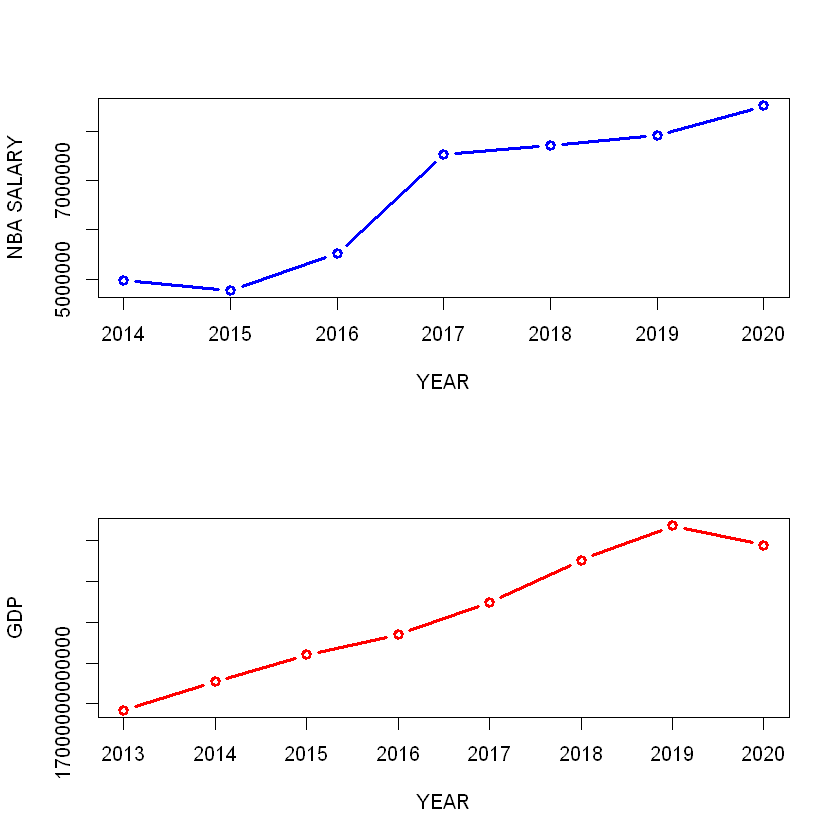

In [342]:
par(mfrow =c(2, 1))
plot(sal, type='b', lwd=3, col='blue', ylab='NBA SALARY')

us.gdp <- as.numeric(us[1,])
plot(c(2013:max(data$YEAR)), us.gdp, type='b', lwd=3, col='red', xlab='YEAR', ylab='GDP')

### UER

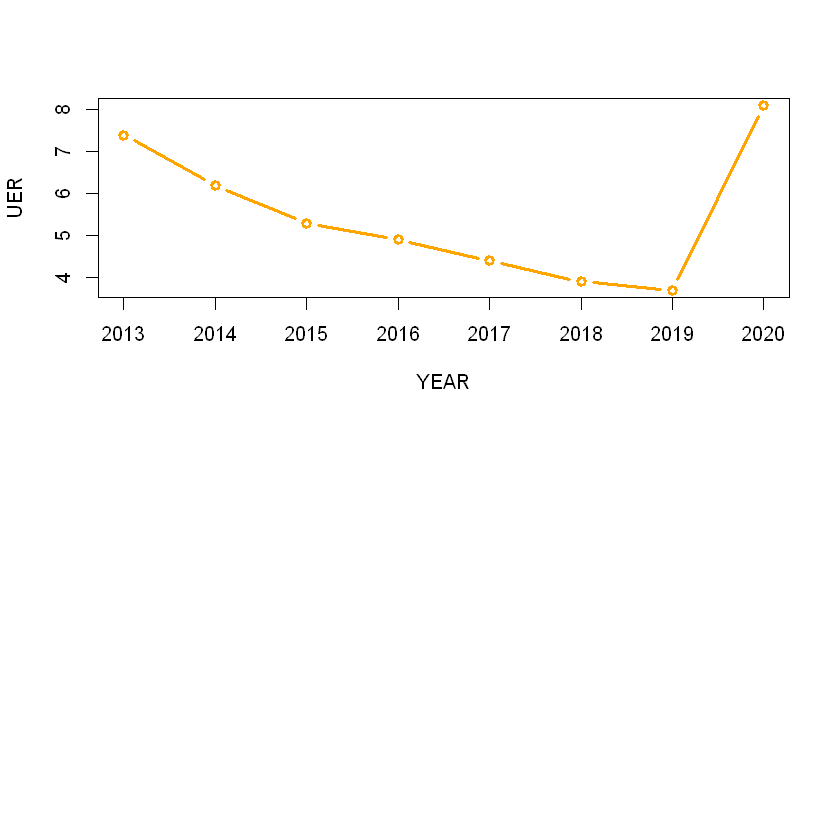

In [343]:
# https://data.bls.gov/pdq/SurveyOutputServlet

par(mfrow =c(2, 1))
uer <- read.csv('data/US_UnemploymentRate_UER.csv')
uer <- uer[uer$Year <= max(data$YEAR), ]
plot(uer$Year, uer$Mean, type='b', lwd=3, col='orange', xlab='YEAR', ylab='UER')

In [344]:
# Append UER
data$UER <- as.numeric(pmap(list(data$YEAR), function(y) { uer[uer$Year==y, ]$Mean }))
length(data$TARGET)

[1] 2259

In [345]:
# Append GDP
data$GDP <- as.numeric(pmap(list(data$YEAR), function(y) { us[[glue('X{y}')]] }))
length(data$TARGET)

[1] 2259

## Team and League Revenue

In [346]:
# https://runrepeat.com/nba-revenue-statistics
# in Billions
rev <- read.csv('data/revenue_by_team.csv')
t = 'Chicago Bulls'
y = 2016
res <- rev[rev$X == t, ][[glue('X{y}')]]
# rev

### League Revenue

In [347]:
data$LEAGUE_REVENUE <- as.numeric(pmap(list(data$YEAR), function(y) { sum(rev[[glue('X{y}')]]) }))
length(data$TARGET)

[1] 2259

### Team Revenue

In [348]:
data$TEAM_REVENUE <- as.numeric(pmap(list(data$YEAR, data$team), function(y,t) { rev[rev$X == t, ][[glue('X{y}')]] }))
length(data$TARGET)

[1] 2259

# Salary Dispersion

Teams with more balanced salary dispersion will have a flatter more elastic demand curve (Rosen et al, 2000, Schouten, 2012).

NOTE: we calculate based on players present in the dataset for a particular year, we use coefficient of variation. If CV is close to 1, then the data is evenly dispersed.

In [350]:
unique(data[data$YEAR==2014 & data$team=='Miami Heat',]$PLAYER)

[1] "Chris Bosh"     "Dwyane Wade"    "LeBron James"   "Mario Chalmers"
[5] "Ray Allen"      "Shane Battier"  "Udonis Haslem"

In [351]:
dispersion <- function (y,t) {
    team_sal <- data[data$YEAR==y,] %>%
    group_by(team)
    
    team_sal = team_sal[team_sal$team==t,]$TARGET
    
    cv <- sd(team_sal) / mean(team_sal)
    return (ifelse(cv <=1 & cv > 0.95, 1, 0))
}

data$DISPERSION <- as.numeric(pmap(list(data$YEAR, data$team), function(y,t) { dispersion(y,t) }))
length(data$TARGET)

[1] 2259

# Encode positions

In [352]:
data = subset(dummy_cols(data, select_columns = c('POS', 'POS.2')), select=-c(POS, POS.2))

# Award Voting

In [353]:
# https://www.sportingnews.com/us/nba/news/award-voting-all-nba-mvp-salaries-contracts-supermax/xcuokxcwgqropuhnemfcprzq
# https://www.kaggle.com/datasets/danchyy/nba-mvp-votings-through-history
mvp = read.csv('data/mvp_votings.csv')

In [354]:
mvp$YEAR <- str_replace(mvp$season, '-.*', '')
mvp$PLAYER <- mvp$player

In [355]:
mvp = mvp[mvp$PLAYER %in% data$PLAYER, ]
length(mvp)

[1] 29

In [356]:
# SKIP, not enough players
# data = merge(data, subset(mvp, select=c('PLAYER', 'YEAR', 'award_share')), by=c('PLAYER', 'YEAR'), all.x=T)

## Variable name clean up

Remove extra spaces where needed

In [357]:
# Clean up variable names
for (i in c(1:length(names(data)))) {
    names(data)[i] <- str_replace(names(data)[i], '\\s', '')
}

names(data)

[1] "PLAYER"               "YEAR"                 "GP"                  
 [4] "MPG"                  "FG."                  "FT."                 
 [7] "PTS"                  "RPG"                  "APG"                 
[10] "STPG"                 "BLKPG"                "SALARY.x"            
[13] "CAP"                  "SAL_CAP"              "TARGET"              
[16] "SALARY.y"             "team"                 "INJURIES"            
[19] "EXPERIENCE"           "player_id"            "poss"                
[22] "mp"                   "raptor_box_offense"   "raptor_box_defense"  
[25] "raptor_box_total"     "raptor_onoff_offense" "raptor_onoff_defense"
[28] "raptor_onoff_total"   "raptor_offense"       "raptor_defense"      
[31] "raptor_total"         "war_total"            "war_reg_season"      
[34] "war_playoffs"         "predator_offense"     "predator_defense"    
[37] "predator_total"       "pace_impact"          "MOST_PLAYOFFS_LIST"  
[40] "TW_FOLLOWERS"         "UER"                  "GDP"                 
[43] "LEAGUE_REVENUE"       "TEAM_REVENUE"         "DISPERSION"          
[46] "POS_C"                "POS_F"                "POS_G"               
[49] "POS_PF"               "POS_PG"               "POS_SF"              
[52] "POS_SG"               "POS.2_C"              "POS.2_F"             
[55] "POS.2_G"              "POS.2_PF"             "POS.2_PG"            
[58] "POS.2_SF"             "POS.2_SG"             "POS.2_C"             
[61] "POS.2_F"              "POS.2_G"              "POS.2_PF"            
[64] "POS.2_PG"             "POS.2_SF"             "POS.2_SG"

# Address Outliers

According to Wang et al. (2016), xgboost's ability to handle outliers is due to the algorithm's ability to adapt to different distributions, including those with outliers. The paper also states that xgboost's regularization techniques, such as L1 and L2 regularization, help to reduce the effect of outliers on the model's performance.

Wang, B., Deng, Y., Li, Y., Li, J., & Wu, X. (2016). Xgboost: A Scalable Tree Boosting System. arXiv Preprint arXiv:1603.02754.

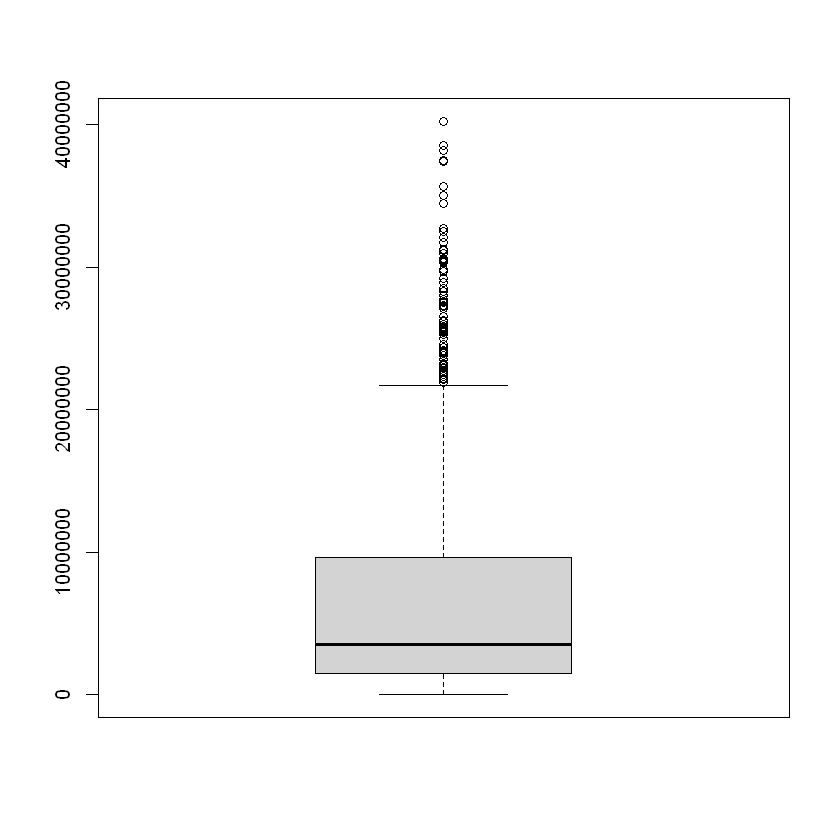

In [358]:
boxplot(data$TARGET)

In [359]:
summary(data$TARGET)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    4737  1512601  3526440  6737982  9603750 40231758 

In [360]:
Q <- quantile(data$TARGET, probs=c(.1, .95), na.rm = FALSE)

iqr <- IQR(data$TARGET)

up <- Q[2]+(1.5*iqr)# Upper Range  
# low <- Q[1]-(1.5*iqr) # Lower Range

up

95% 
35317050

## Start with retaining outliers

XGBoost is robust to outliers

In [361]:
# remove only the upper bounds
# league_min = 925258 # 2021

# data <- data[data$TARGET > league_min, ]
# length(data$TARGET)

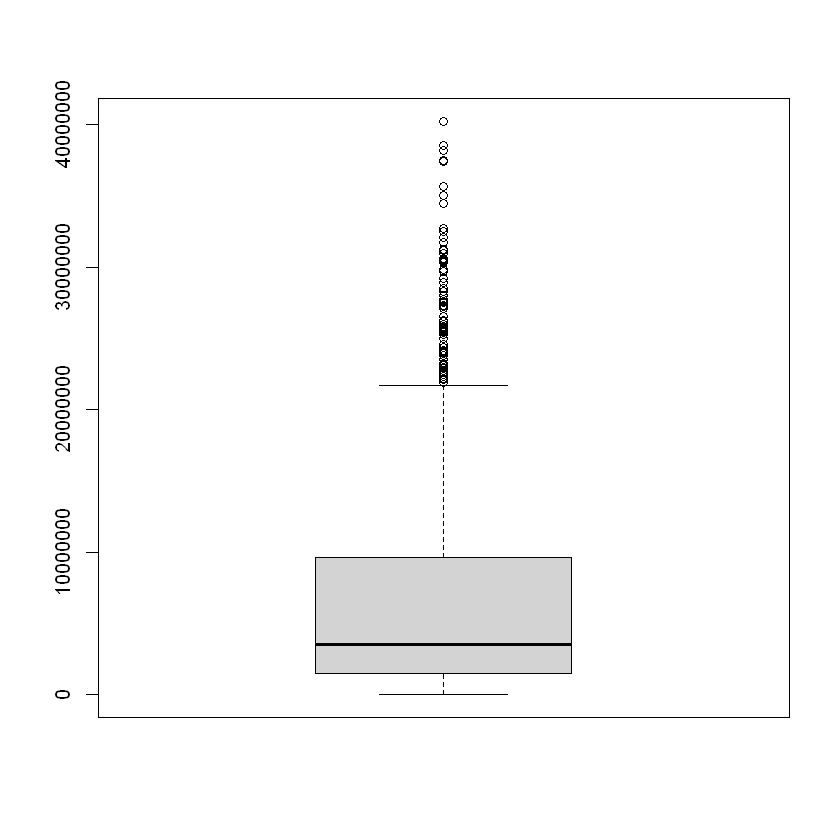

In [362]:
boxplot(data$TARGET)

In [363]:
data = data[!duplicated(data), ]
length(data$TARGET)

[1] 2259

# Dev dataset

In [364]:
write.csv(data, 'data/Final_Dev_Outliers_In.csv')

In [365]:
data <- read.csv('data/Final_Dev_Outliers_In.csv')

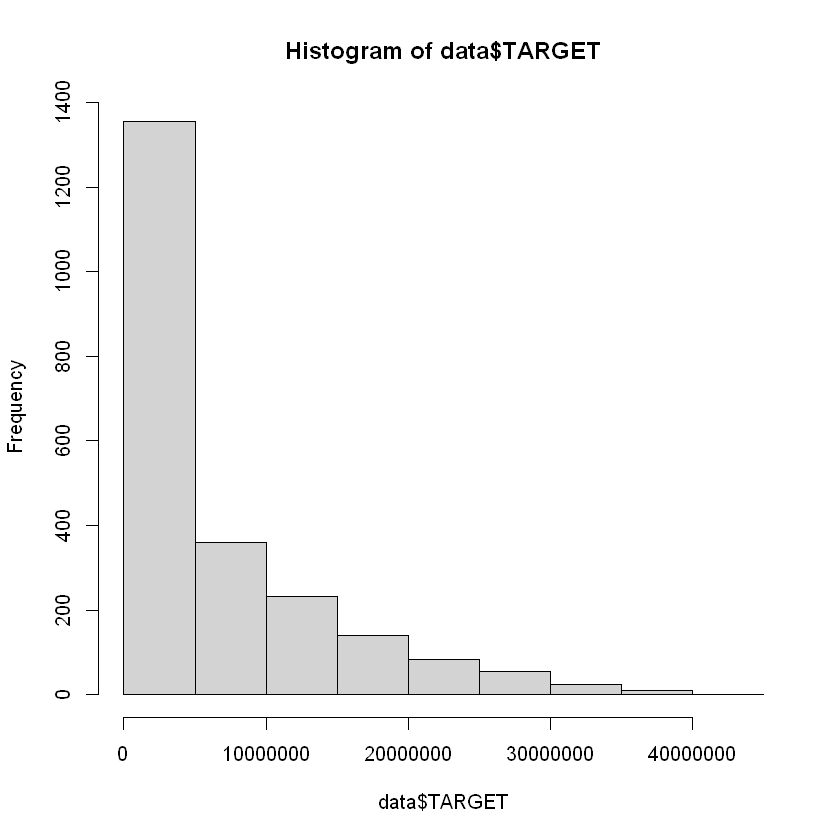

In [366]:
hist(data$TARGET)

# Start with all features

In [367]:
X = subset(data, select = -c(SALARY.y, SALARY.x, PLAYER, team, CAP, player_id, X, YEAR))
length(names(X))
str(X)

[1] 59

'data.frame':	2259 obs. of  59 variables:
 $ GP                  : int  72 32 65 82 69 62 80 50 78 47 ...
 $ MPG                 : num  21.6 5.9 13.8 23 16.1 32.5 28.7 27.7 23.9 17 ...
 $ FG.                 : num  0.401 0.486 0.403 0.421 0.401 0.437 0.454 0.463 0.473 0.447 ...
 $ FT.                 : num  0.874 0.727 0.8 0.833 0.766 0.674 0.719 0.651 0.668 0.721 ...
 $ PTS                 : num  9 2.3 5 11.6 7.1 14.4 12.7 12.4 9.2 5.2 ...
 $ RPG                 : num  1.9 0.5 1.1 2 1.5 7.7 5.1 5.7 6.5 3.6 ...
 $ APG                 : num  3.2 0.6 1.9 3.2 2.6 3.7 1.9 3.2 1.6 0.7 ...
 $ STPG                : num  0.7 0.19 0.4 0.7 0.4 0.8 0.8 0.7 0.8 0.4 ...
 $ BLKPG               : num  0.2 0 0.1 0.2 0.1 0.6 0.5 0.7 0.7 0.5 ...
 $ SAL_CAP             : int  63065000 101869000 99093000 70000000 94100000 109140000 99093000 109140000 94100000 70000000 ...
 $ TARGET              : int  884293 1471382 2700000 915243 2250000 21590909 4351320 19863636 4171680 3992040 ...
 $ INJURIES          

In [504]:
toy_xgb = function (X) {
       
    # establish random seed
    set.seed(111)

    # create training sample
    all.train = sample(nrow(X), nrow(X)* 0.7)

    # create train, test split
    all.train_x = subset(X[all.train, ], select=-c(TARGET))
    all.train_y = X[all.train, ]$TARGET

    all.test_x = subset(X[-all.train, ], select=-c(TARGET))
    all.test_y = X[-all.train, ]$TARGET

    all.xgb_train = xgb.DMatrix(data = as.matrix(all.train_x), label = as.matrix(all.train_y))
    all.xgb_test = xgb.DMatrix(data = as.matrix(all.test_x), label = as.matrix(all.test_y))

    all.watchlist = list(train=all.xgb_train, test=all.xgb_test)

    all.params <- list(
        booster = "gbtree", 
        objective = "reg:squarederror", 
        eta=0.1, 
        gamma=0, 
        max_depth=4, 
        min_child_weight=1, 
        subsample=1, 
        colsample_bytree=1,
        tree_method='approx'
    )

    set.seed(54321)

    return (all.xgbcv <- xgb.cv( 
        params = all.params, 
        data = all.xgb_train, 
        nrounds = 100, 
        nfold = 10, 
        showsd = T, 
        stratified = T, 
        print_every_n = 2, 
        early_stopping_rounds = 50, 
        maximize = F,
        eval_metric='mae'))
}

all.xgbcv = toy_xgb(X)

[1]	train-mae:6016456.992235+35632.887666	test-mae:6016428.804927+340918.020023 
Multiple eval metrics are present. Will use test_mae for early stopping.
Will train until test_mae hasn't improved in 50 rounds.

[3]	train-mae:4970233.055368+28014.145618	test-mae:4998076.664732+305096.087110 
[5]	train-mae:4235903.920882+22287.847231	test-mae:4319545.567335+293954.209226 
[7]	train-mae:3711013.907251+22338.106433	test-mae:3853859.788231+282288.726708 
[9]	train-mae:3335300.559500+21338.751182	test-mae:3547341.721959+277546.537211 
[11]	train-mae:3066799.472878+20157.957219	test-mae:3341667.872439+255713.810711 
[13]	train-mae:2868627.814873+20003.463003	test-mae:3191610.038901+247346.482691 
[15]	train-mae:2715599.594433+18098.083530	test-mae:3096633.447192+229392.613582 
[17]	train-mae:2597939.108406+20043.971171	test-mae:3020832.335176+209815.179350 
[19]	train-mae:2504151.874691+19521.867274	test-mae:2968874.002302+200418.947647 
[21]	train-mae:2426758.978879+20320.531360	test-mae:292

# Recursive Feature Selection

## Random Forest


Recursive feature selection

Outer resampling method: Cross-Validated (10 fold) 

Resampling performance over subset size:

 Variables    RMSE Rsquared     MAE RMSESD RsquaredSD  MAESD Selected
         1 6071400   0.3724 4464609 571621    0.08334 407071         
         2 5262761   0.5210 3737120 633172    0.10409 391451         
         3 4818141   0.6001 3458766 489794    0.09356 437550         
         4 4764080   0.6109 3414210 416460    0.09765 394621         
         5 4779100   0.6120 3436128 436240    0.09493 387213         
         6 4710240   0.6165 3371658 358322    0.09818 334127        *
         7 4742488   0.6138 3390284 327159    0.09466 315051         
         8 4797586   0.6058 3438218 341770    0.09564 326276         
         9 4789047   0.6054 3423384 344108    0.09233 321974         
        10 4829245   0.5975 3462345 387694    0.09888 334919         
        11 4838400   0.5976 3481248 400364    0.09682 338746         
        12 4809475   0.6015 3451961

[1] "EXPERIENCE"   "TW_FOLLOWERS" "MPG"          "PTS"          "RPG"         
[6] "poss"

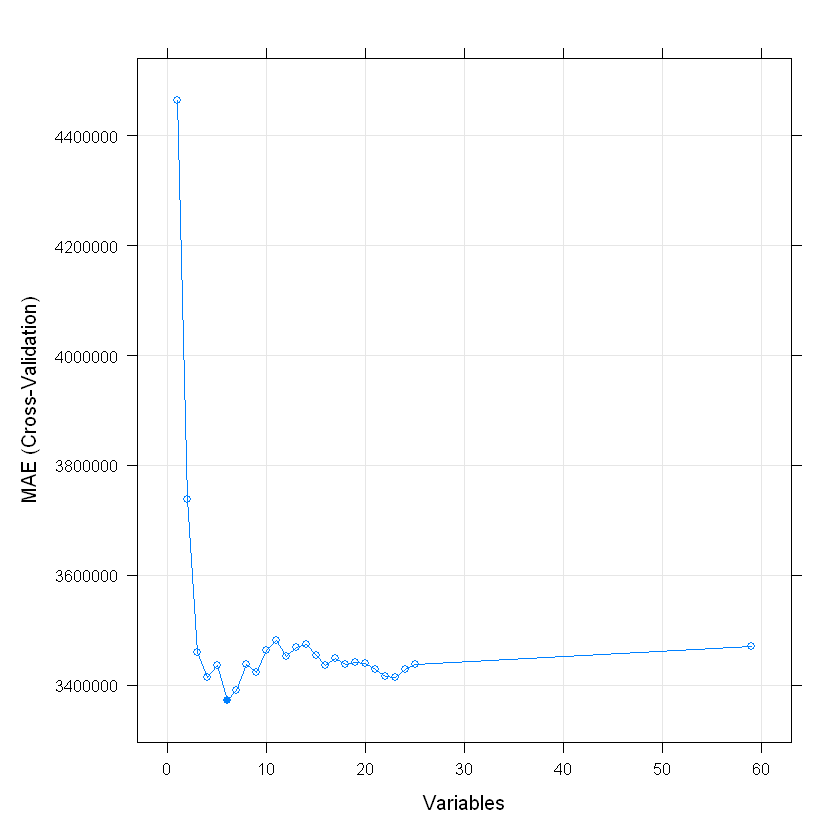

In [374]:
# https://rdrr.io/cran/caret/man/rfeControl.html  
# ensure the results are repeatable
set.seed(7)

samp = na.omit(data[sample(nrow(data ), nrow(data )* 0.5),])

samp_X = subset(samp, select=-c(
    TARGET, YEAR, SALARY.y, SALARY.x, PLAYER, team, CAP, player_id
))
samp_y = samp$TARGET

# define the control using a random forest selection function
control <- rfeControl(functions=rfFuncs, method="cv", number=10)
# run the RFE algorithm
results <- rfe(samp_X, samp_y, sizes=c(1:25), rfeControl=control, metric='MAE')
# summarize the results
print(results)
# list the chosen features
predictors(results)
# plot the results
plot(results, type=c("g", "o"))

In [375]:
min(results$results$MAE)
min(results$results$RMSE)
max(results$results$Rsquared)

rf.feat = results$optVariables
rf.feat

[1] 3371658

[1] 4710240

[1] 0.6165037

[1] "EXPERIENCE"   "TW_FOLLOWERS" "MPG"          "PTS"          "RPG"         
[6] "poss"

## Tree Bagging


Recursive feature selection

Outer resampling method: Cross-Validated (10 fold) 

Resampling performance over subset size:

 Variables    RMSE Rsquared     MAE RMSESD RsquaredSD  MAESD Selected
         1 6340550   0.3141 4735176 727162    0.09305 454847         
         2 6122831   0.3681 4537779 884243    0.09493 511934         
         3 6037710   0.3837 4465014 870928    0.08622 517149         
         4 5232431   0.5323 3794862 932697    0.12282 655069         
         5 4903654   0.5947 3499956 773555    0.06937 500709         
         6 4873036   0.5985 3508091 748799    0.06987 502667         
         7 4824295   0.6072 3464021 722097    0.06362 506835        *
         8 4823683   0.6075 3466568 688411    0.06296 480432         
         9 4907031   0.5940 3534629 728892    0.07043 485874         
        10 4871642   0.6015 3482668 682532    0.05654 469648         
        11 4877091   0.5989 3487859 754530    0.06678 495040         
        12 4847058   0.6038 3474631

[1] "TW_FOLLOWERS" "PTS"          "MPG"          "EXPERIENCE"   "RPG"         
[6] "poss"         "mp"

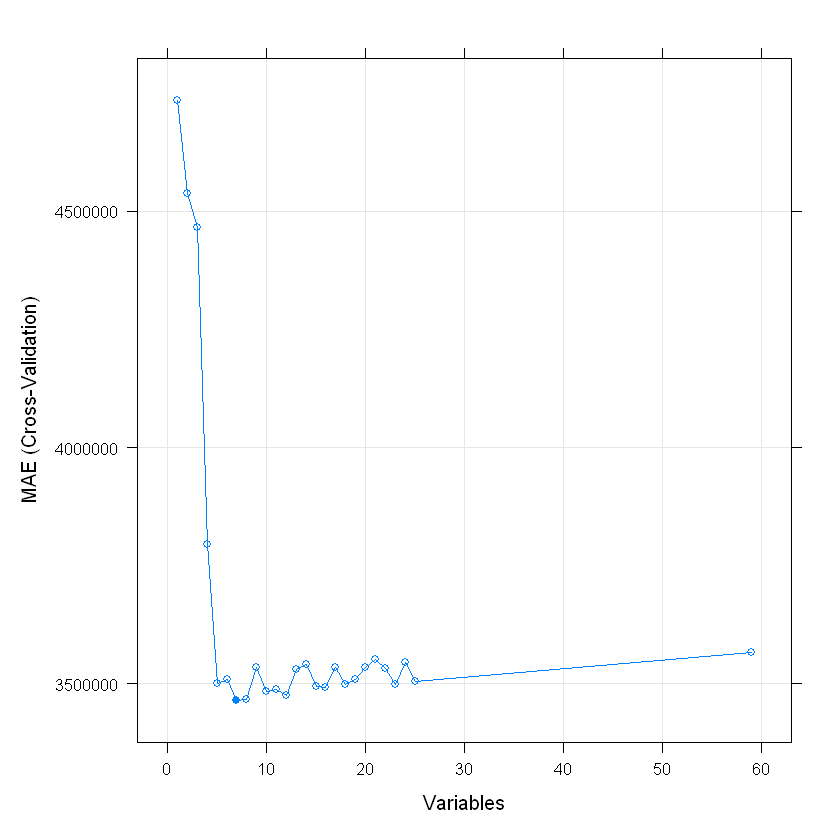

In [376]:
# ensure the results are repeatable
set.seed(8)
control <- rfeControl(functions=treebagFuncs, method="cv", number=10)
results2 <- rfe(samp_X, samp_y, sizes=c(1:25), rfeControl=control, metric='MAE')
print(results2)
predictors(results2)
plot(results2, type=c("g", "o"))

In [377]:
min(results2$results$MAE)
min(results2$results$RMSE)
max(results2$results$Rsquared)

[1] 3464021

[1] 4823683

[1] 0.6074969

In [378]:
tb.feat = results2$optVariables
tb.feat

[1] "TW_FOLLOWERS" "PTS"          "MPG"          "EXPERIENCE"   "RPG"         
[6] "poss"         "mp"

# Find consensus of RFE

In [382]:
all_results_min = c(
    min(results$results$MAE),
    min(results2$results$MAE), 
    min(all.xgbcv$evaluation_log$test_mae_mean)
)

all_results.df = data.frame(c(MAE=all_results_min), Method=c('Random Forest', 'Tree Bagging', 'XGBoost'))
all_results.df

,c.MAE...all_results_min.,Method
,<dbl>,<chr>
MAE1,3371658,Random Forest
MAE2,3464021,Tree Bagging
MAE3,2850397,XGBoost


In [392]:
rf.xgb = toy_xgb(subset(X, select=c(rf.feat, 'TARGET')))

[1]	train-mae:5701845.072313+32890.818672	test-mae:5717173.161890+337929.755050 
Multiple eval metrics are present. Will use test_mae for early stopping.
Will train until test_mae hasn't improved in 50 rounds.

[3]	train-mae:4367485.446217+27033.719282	test-mae:4443883.575470+297839.699200 
[5]	train-mae:3591328.123385+25772.375256	test-mae:3728149.949318+267773.340454 
[7]	train-mae:3137265.129029+23247.349849	test-mae:3348068.717629+255774.236308 
[9]	train-mae:2870624.304487+23726.318984	test-mae:3147102.298154+247814.163473 
[11]	train-mae:2699264.163773+27910.219690	test-mae:3028502.314920+240576.748920 
[13]	train-mae:2583019.079672+24721.232342	test-mae:2965284.117148+225182.628239 
[15]	train-mae:2502441.324171+26841.255893	test-mae:2929782.317218+228156.922544 
[17]	train-mae:2443194.813706+25365.797886	test-mae:2911563.534161+232603.944372 
[19]	train-mae:2400407.679868+28461.042759	test-mae:2906344.770127+235513.236970 
[21]	train-mae:2362016.255420+28090.354050	test-mae:289

In [386]:
tb.xgb = toy_xgb(subset(X, select=c(tb.feat, 'TARGET')))

[1]	train-mae:5701796.958407+32901.036913	test-mae:5716821.985909+339523.684595 
Multiple eval metrics are present. Will use test_mae for early stopping.
Will train until test_mae hasn't improved in 50 rounds.

[3]	train-mae:4367082.754176+26681.415094	test-mae:4441045.352358+299363.468091 
[5]	train-mae:3590601.659803+23756.443555	test-mae:3738715.464786+269682.121570 
[7]	train-mae:3138992.399029+24231.626377	test-mae:3355814.942641+255168.127544 
[9]	train-mae:2871453.203977+25027.201433	test-mae:3158464.873897+243393.309942 
[11]	train-mae:2696755.793454+26652.668523	test-mae:3052773.716085+230850.094439 
[13]	train-mae:2584318.756869+27859.458656	test-mae:2984640.531858+221785.874868 
[15]	train-mae:2502394.411989+28391.459616	test-mae:2948963.737571+221174.395627 
[17]	train-mae:2443328.934437+25946.071352	test-mae:2934261.046625+224545.354221 
[19]	train-mae:2401579.181102+27244.753192	test-mae:2932944.084226+221220.139472 
[21]	train-mae:2364328.771833+25984.884201	test-mae:291

In [393]:
min(rf.xgb$evaluation_log$test_mae_mean)
min(tb.xgb$evaluation_log$test_mae_mean)

[1] 2877367

[1] 2898042

## Consider RFE from Python

NOTE: RFE implementation for XGBoost in R was not available

In [458]:
# TODO combine with from Python RFE
py = read.csv('data/xgb_rfe_py.csv')
py.feat = py$X0[3:length(py$X0)]

# consenus of RFE's
py.feat
rf.feat
tb.feat

final = unique(Reduce(union, c(py$X0[3:length(py$X0)], rf.feat, tb.feat)))
final

[1] "FG." "FT." "APG" "GP"  "RPG" "MPG" "PTS"

[1] "EXPERIENCE"   "TW_FOLLOWERS" "MPG"          "PTS"          "RPG"         
[6] "poss"

[1] "TW_FOLLOWERS" "PTS"          "MPG"          "EXPERIENCE"   "RPG"         
[6] "poss"         "mp"

[1] "FG."          "FT."          "APG"          "GP"           "RPG"         
 [6] "MPG"          "PTS"          "EXPERIENCE"   "TW_FOLLOWERS" "poss"        
[11] "mp"

# Final Features

In [459]:
features <- final
features

[1] "FG."          "FT."          "APG"          "GP"           "RPG"         
 [6] "MPG"          "PTS"          "EXPERIENCE"   "TW_FOLLOWERS" "poss"        
[11] "mp"

## Final feature types

In [460]:
str(subset(data, select=features))

'data.frame':	2259 obs. of  11 variables:
 $ FG.         : num  0.401 0.486 0.403 0.421 0.401 0.437 0.454 0.463 0.473 0.447 ...
 $ FT.         : num  0.874 0.727 0.8 0.833 0.766 0.674 0.719 0.651 0.668 0.721 ...
 $ APG         : num  3.2 0.6 1.9 3.2 2.6 3.7 1.9 3.2 1.6 0.7 ...
 $ GP          : int  72 32 65 82 69 62 80 50 78 47 ...
 $ RPG         : num  1.9 0.5 1.1 2 1.5 7.7 5.1 5.7 6.5 3.6 ...
 $ MPG         : num  21.6 5.9 13.8 23 16.1 32.5 28.7 27.7 23.9 17 ...
 $ PTS         : num  9 2.3 5 11.6 7.1 14.4 12.7 12.4 9.2 5.2 ...
 $ EXPERIENCE  : int  2 6 5 3 4 4 3 5 2 1 ...
 $ TW_FOLLOWERS: int  59556 59556 59556 59556 59556 208168 208168 208168 208168 208168 ...
 $ poss        : int  3238 404 1819 3956 2256 5774 4687 4190 3823 1603 ...
 $ mp          : int  1557 192 901 2017 1108 2797 2298 2017 1863 797 ...


## Final feature correlation

In [461]:
cor(subset(data, select=features))

,FG.,FT.,APG,GP,RPG,MPG,PTS,EXPERIENCE,TW_FOLLOWERS,poss,mp
FG.,1.00000000,-0.12721960,-0.0660428,0.14349941,0.37315142,0.09160147,0.1332667,0.09263735,0.05087638,0.1091348,0.1080640
FT.,-0.12721960,1.00000000,0.2353380,0.22724471,-0.01465358,0.27003045,0.2847231,0.11344029,0.06136902,0.2308188,0.2300883
APG,-0.06604280,0.23533801,1.0000000,0.24443215,0.20708349,0.64957471,0.6640782,0.20685221,0.34566623,0.5286084,0.5220241
GP,0.14349941,0.22724471,0.2444322,1.00000000,0.34185140,0.53455622,0.3844849,0.03091727,0.07287355,0.6839091,0.6926734
RPG,0.37315142,-0.01465358,0.2070835,0.34185140,1.00000000,0.59499183,0.5345648,0.17332300,0.19018731,0.5071241,0.5086803
MPG,0.09160147,0.27003045,0.6495747,0.53455622,0.59499183,1.00000000,0.8672810,0.22276323,0.23585757,0.8261611,0.8276994
PTS,0.13326670,0.28472306,0.6640782,0.38448489,0.53456480,0.86728103,1.0000000,0.23262655,0.35847663,0.7201589,0.7155125
EXPERIENCE,0.09263735,0.11344029,0.2068522,0.03091727,0.17332300,0.22276323,0.2326265,1.00000000,0.10220095,0.2517089,0.2338400
TW_FOLLOWERS,0.05087638,0.06136902,0.3456662,0.07287355,0.19018731,0.23585757,0.3584766,0.10220095,1.00000000,0.2299113,0.2315299
poss,0.10913481,0.23081884,0.5286084,0.68390914,0.50712407,0.82616109,0.7201589,0.25170891,0.22991130,1.0000000,0.9978159


## Final feature relationships

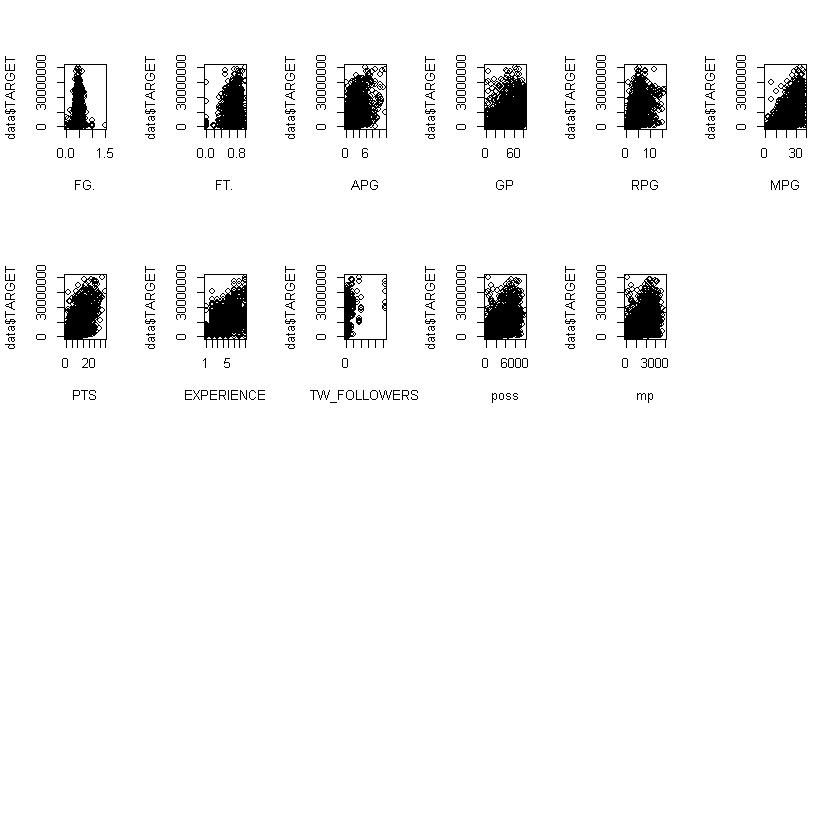

In [462]:
par(mfrow =c(4, 6))

for (f in features) {
    plot(data$TARGET~data[[f]], xlab=f)
}


## Distributional Analysis

In [463]:
summary(data$TARGET)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    4737  1512601  3526440  6737982  9603750 40231758 

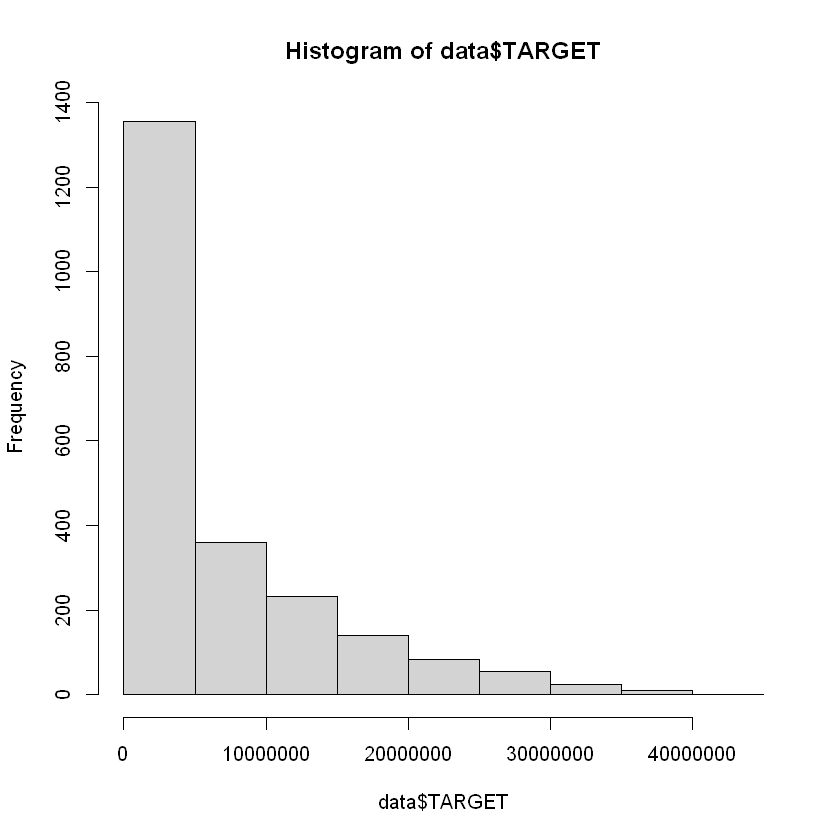

In [464]:
hist(data$TARGET)

## Consider transformation of target

XGboost will not take distribution into consideration. As such, transformations are not needed.

# OLS Baseline

In [465]:
ols <- lm(formula = TARGET~., data=X)
summary(ols)


Call:
lm(formula = TARGET ~ ., data = X)

Residuals:
      Min        1Q    Median        3Q       Max 
-14895740  -2708422   -212750   2422472  17098348 

Coefficients: (13 not defined because of singularities)
                                Estimate          Std. Error t value
(Intercept)          36353041.4950217158 14005404.8133775052   2.596
GP                     -43193.7584989662     9524.3139910228  -4.535
MPG                    -23779.8499459761    47995.9503222143  -0.495
FG.                  -4669868.9232473169  2124067.6937121516  -2.199
FT.                  -1695601.8552718966  1007453.8596029691  -1.683
PTS                    371559.3582571236    52833.5366100094   7.033
RPG                    533410.8994400324    99149.9214840180   5.380
APG                    448083.7079741639   123133.5634367461   3.639
STPG                 -1373157.8071621135   539544.3500419458  -2.545
BLKPG                 -263734.7745910230   404085.3826302887  -0.653
SAL_CAP                    -

## Remove insignificant features

In [466]:
ols.pval = summary(ols)$coefficients[,4]
# ols.f[ols.f['Pr(>|t|)'] < 1, ]
pres = data.frame(ols.pval)
pres$Features = rownames(pres)
pval = pres[pres$ols.pval<0.05,]
pval$Features

[1] "(Intercept)"        "GP"                 "FG."               
 [4] "PTS"                "RPG"                "APG"               
 [7] "STPG"               "INJURIES"           "EXPERIENCE"        
[10] "poss"               "mp"                 "MOST_PLAYOFFS_LIST"
[13] "TW_FOLLOWERS"       "GDP"                "LEAGUE_REVENUE"    
[16] "POS_SF"             "POS.2_C"            "POS.2_PF"          
[19] "POS.2_PG"           "POS.2_SF"           "POS.2_SG"

In [467]:
ols.p <- lm(formula=TARGET~GP+
FG.+PTS+RPG+APG+STPG+INJURIES+EXPERIENCE+poss+mp+MOST_PLAYOFFS_LIST+TW_FOLLOWERS+GDP+LEAGUE_REVENUE+POS_SF+POS.2_C+POS.2_PF+POS.2_PG+POS.2_SF+POS.2_SG, 
data=X)
summary(ols.p)   


Call:
lm(formula = TARGET ~ GP + FG. + PTS + RPG + APG + STPG + INJURIES + 
    EXPERIENCE + poss + mp + MOST_PLAYOFFS_LIST + TW_FOLLOWERS + 
    GDP + LEAGUE_REVENUE + POS_SF + POS.2_C + POS.2_PF + POS.2_PG + 
    POS.2_SF + POS.2_SG, data = X)

Residuals:
      Min        1Q    Median        3Q       Max 
-15433119  -2782077   -164444   2446395  19388137 

Coefficients:
                              Estimate          Std. Error t value
(Intercept)         6569014.5134413745  7383382.6273544282   0.890
GP                   -55653.9552647734     8768.2305995405  -6.347
FG.                -3085543.0014327611  1735008.8258811568  -1.778
PTS                  340938.9420226744    33994.9983171911  10.029
RPG                  639760.8105187913    69338.0381894841   9.227
APG                  513972.5771584744   103069.4343103836   4.987
STPG               -1403206.9425286758   410214.8118923760  -3.421
INJURIES             104123.5594913801    38762.8815805303   2.686
EXPERIENCE          1

In [468]:
ols.pval = summary(ols.p)$coefficients[,4]
pres = data.frame(ols.pval)
pres$Features = rownames(pres)
pval = pres[pres$ols.pval<0.05,]
pval$Features

ols.p <- lm(formula=TARGET~GP+PTS+RPG+APG+STPG+INJURIES+EXPERIENCE+poss+mp+MOST_PLAYOFFS_LIST+TW_FOLLOWERS+POS_SF+POS.2_PG+POS.2_SF, data=X)
summary(ols.p)

[1] "GP"                 "PTS"                "RPG"               
 [4] "APG"                "STPG"               "INJURIES"          
 [7] "EXPERIENCE"         "poss"               "mp"                
[10] "MOST_PLAYOFFS_LIST" "TW_FOLLOWERS"       "POS_SF"            
[13] "POS.2_PG"           "POS.2_SF"


Call:
lm(formula = TARGET ~ GP + PTS + RPG + APG + STPG + INJURIES + 
    EXPERIENCE + poss + mp + MOST_PLAYOFFS_LIST + TW_FOLLOWERS + 
    POS_SF + POS.2_PG + POS.2_SF, data = X)

Residuals:
      Min        1Q    Median        3Q       Max 
-15536569  -2682295   -152190   2466790  19315146 

Coefficients:
                         Estimate     Std. Error t value             Pr(>|t|)
(Intercept)        -3674767.61448   469482.18741  -7.827  0.00000000000000882
GP                   -55440.31042     8434.83125  -6.573  0.00000000006596655
PTS                  330818.20094    33638.15166   9.835 < 0.0000000000000002
RPG                  631303.36457    59969.64225  10.527 < 0.0000000000000002
APG                  539159.00295   101274.40982   5.324  0.00000011555649246
STPG               -1490058.86656   405604.36165  -3.674             0.000247
INJURIES             114828.03919    37428.47138   3.068             0.002190
EXPERIENCE          1764426.45198    68119.25885  25.902 < 0.00000

## Gauss-Markov Assumptions, BLUE

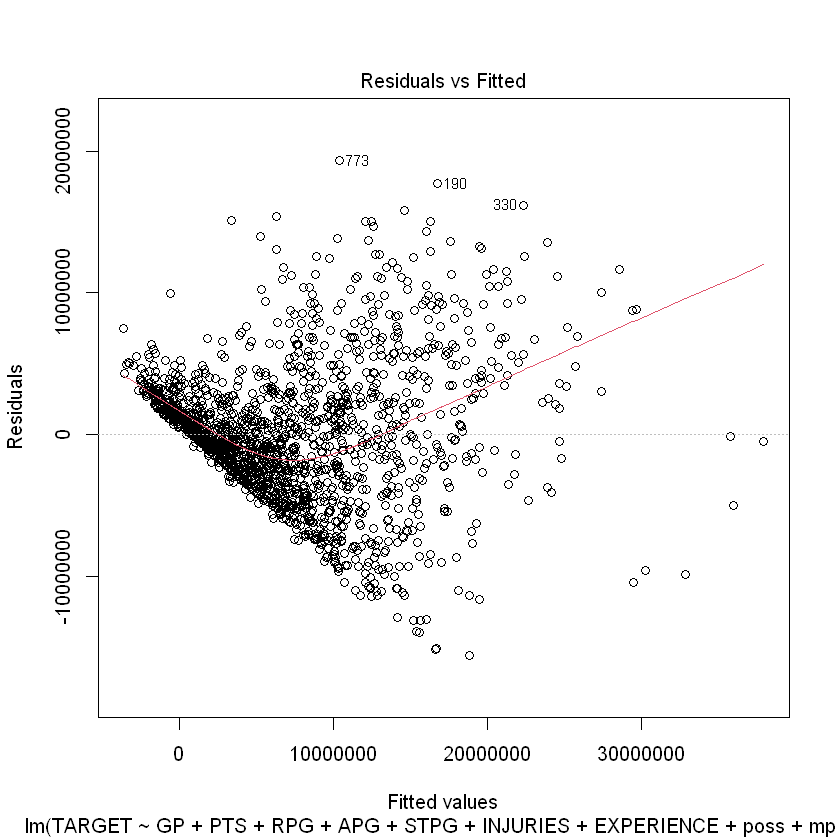

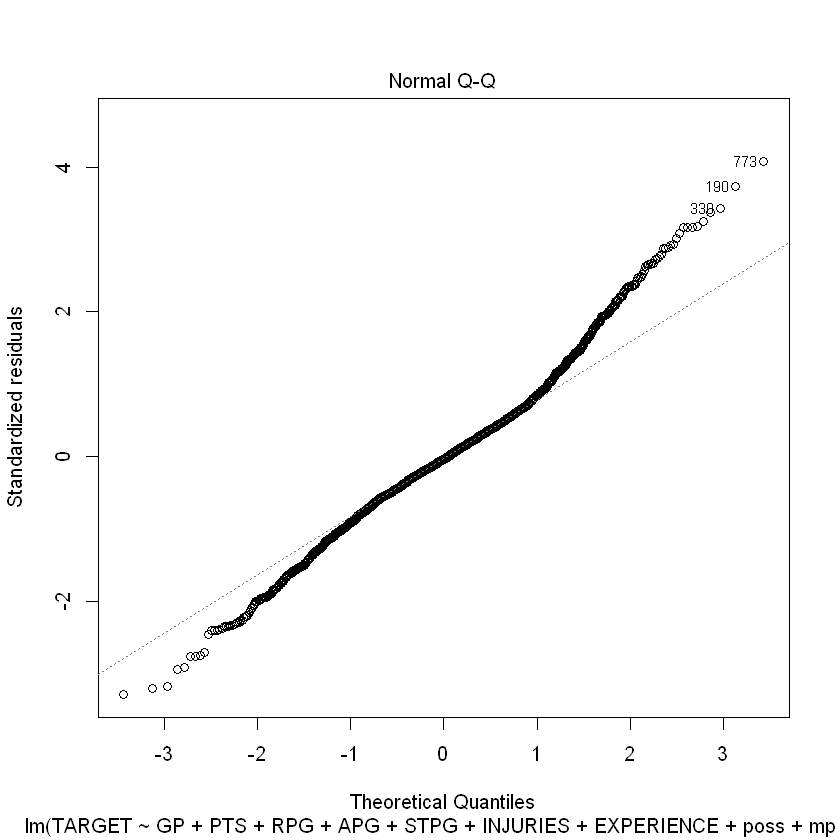

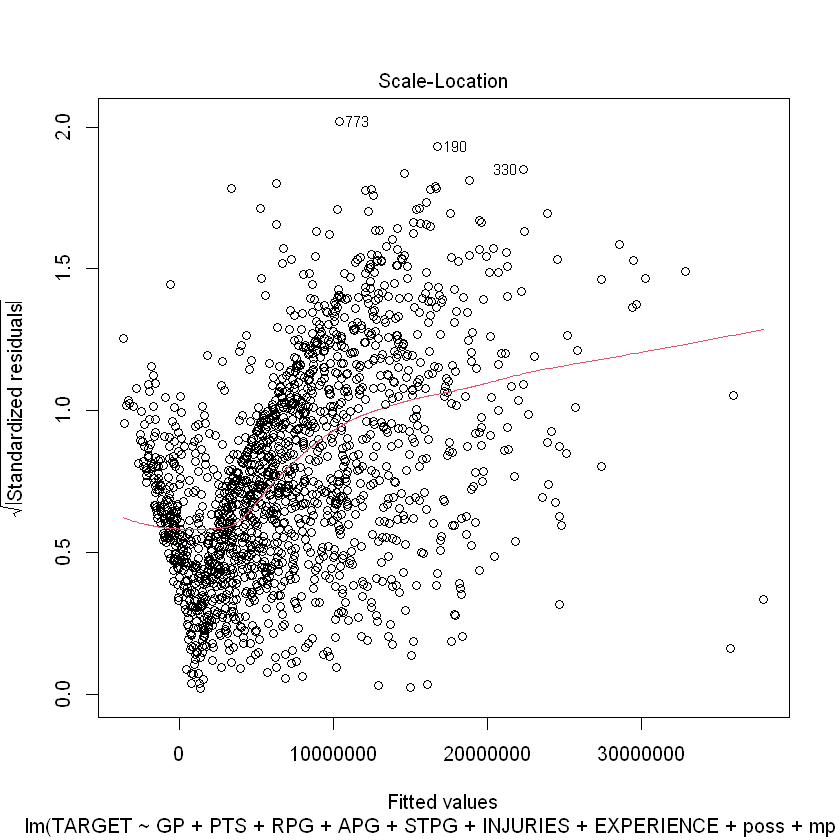

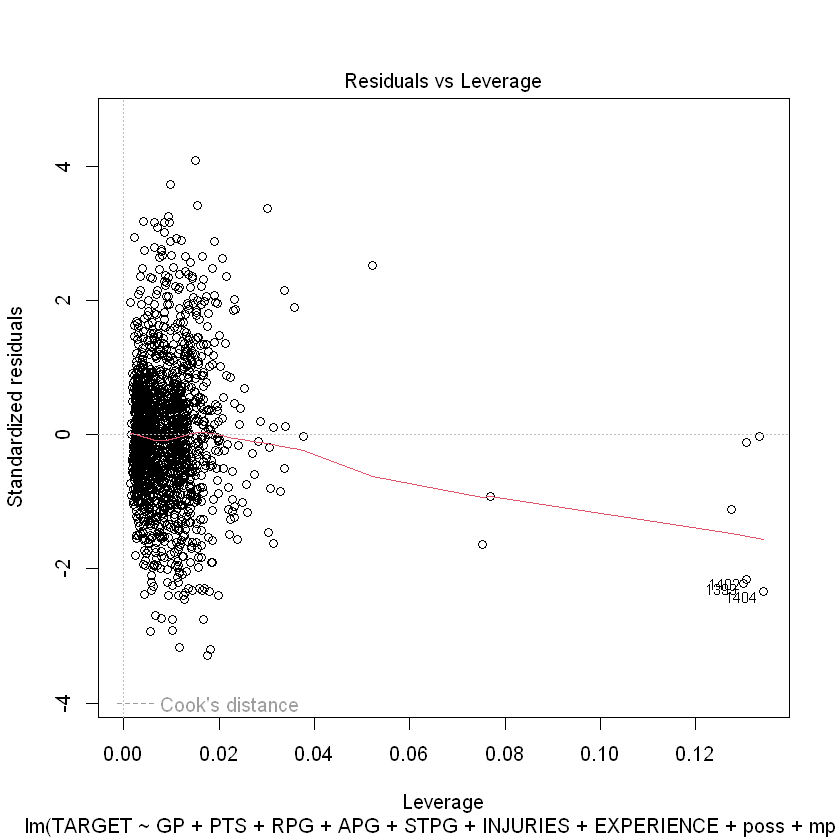

In [469]:
plot(ols.p)

In [470]:
names(ols)

[1] "coefficients"  "residuals"     "effects"       "rank"         
 [5] "fitted.values" "assign"        "qr"            "df.residual"  
 [9] "na.action"     "xlevels"       "call"          "terms"        
[13] "model"

In [471]:
currency(4745000)

[1] $4,745,000.00

In [472]:
# BLUE - mean of resids
mean(ols.p$resid)

[1] -0.00000000007076489

In [473]:
# BLUE - no perfect multicollinearity VIF > 5 
vif(ols.p)

GP                PTS                RPG                APG 
          2.174780           3.310996           1.663762           2.913758 
              STPG           INJURIES         EXPERIENCE               poss 
          2.320843           1.071896           1.264232         256.360922 
                mp MOST_PLAYOFFS_LIST       TW_FOLLOWERS             POS_SF 
        256.891241           1.283912           1.339917           1.969720 
          POS.2_PG           POS.2_SF 
          1.319701           1.959715

In [474]:
# BLUE - Homoscedasticity
# inconclusive or not satisfied - https://stats.stackexchange.com/questions/468778/contradictory-results-between-breusch-pagan-test-and-goldfeld-quandt-test-in-pyt

par(mfrow=c(2,2))  # set 2 rows and 2 column plot layout
# plot(ols)

# Breusch-Pagan test
print(bptest(ols.p, data = X, studentize = TRUE))
# Goldfeld-Quandt
print(gqtest(ols.p))


	studentized Breusch-Pagan test

data:  ols.p
BP = 324.02, df = 14, p-value < 0.00000000000000022


	Goldfeld-Quandt test

data:  ols.p
GQ = 0.92326, df1 = 821, df2 = 821, p-value = 0.8736
alternative hypothesis: variance increases from segment 1 to 2




	Durbin-Watson test

data:  ols.p
DW = 1.6978, p-value = 0.0000000001355
alternative hypothesis: true autocorrelation is greater than 0


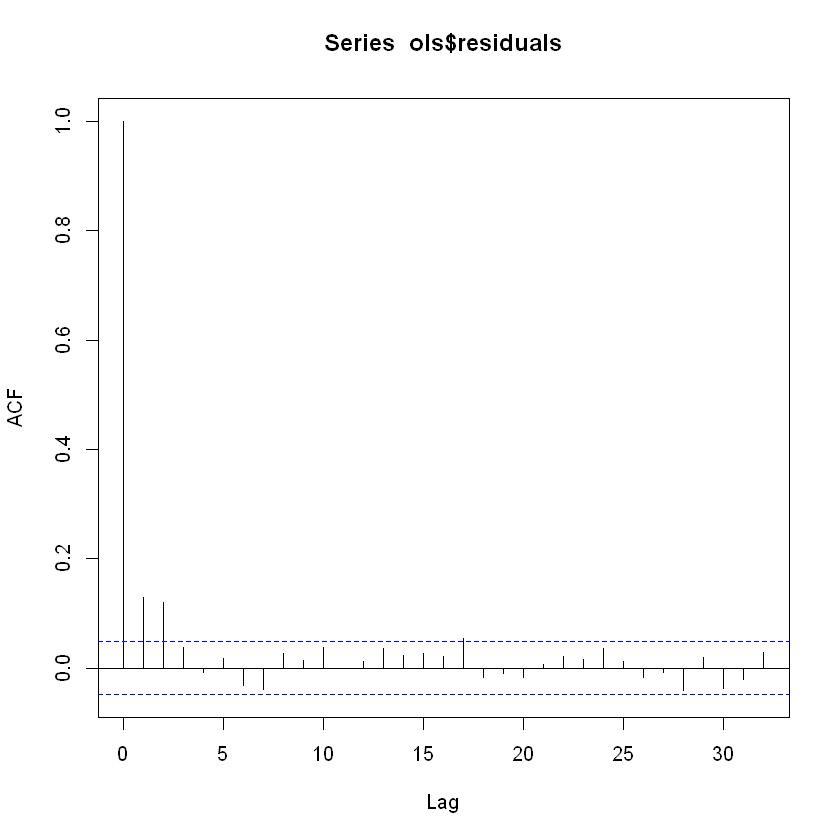

In [475]:
# BLUE no autocorrelation of resid
acf(ols$residuals)  
dwtest(ols.p)

# Train-test Split

In [546]:
# establish random seed
set.seed(111)

# create training sample
train = sample(nrow(X), nrow(X)* 0.7)

# create train, test split
train_x = subset(X[train, ], select=-c(TARGET))
train_y = X[train, ]$TARGET

test_x = subset(X[-train, ], select=-c(TARGET))
test_y = X[-train, ]$TARGET

xgb_train = xgb.DMatrix(data = as.matrix(train_x), label = as.matrix(train_y))
xgb_test = xgb.DMatrix(data = as.matrix(test_x), label = as.matrix(test_y))

watchlist = list(train=xgb_train, test=xgb_test)

In [529]:
# TODO: parallel tuning
# https://www.hackerearth.com/practice/machine-learning/machine-learning-algorithms/beginners-tutorial-on-xgboost-parameter-tuning-r/tutorial/

In [549]:
params <- list(
    booster = "gbtree", 
    objective = "reg:squarederror", 
    eta=0.1, 
    gamma=0, 
    max_depth=4, 
    min_child_weight=1, 
    subsample=1, 
    colsample_bytree=1,
    tree_method='approx'
)

# 10-Fold Cross Validation

In [550]:
set.seed(54321)
xgbcv <- xgb.cv( 
    params = params, 
    data = xgb_train, 
    nrounds = 100, 
    nfold = 10, 
    showsd = T, 
    stratified = T, 
    print_every_n = 2, 
    early_stopping_rounds = 20, 
    maximize = F,
    eval_metric='mae')

[1]	train-mae:6016456.992235+35632.887666	test-mae:6016428.804927+340918.020023 
Multiple eval metrics are present. Will use test_mae for early stopping.
Will train until test_mae hasn't improved in 20 rounds.

[3]	train-mae:4970233.055368+28014.145618	test-mae:4998076.664732+305096.087110 
[5]	train-mae:4235903.920882+22287.847231	test-mae:4319545.567335+293954.209226 
[7]	train-mae:3711013.907251+22338.106433	test-mae:3853859.788231+282288.726708 
[9]	train-mae:3335300.559500+21338.751182	test-mae:3547341.721959+277546.537211 
[11]	train-mae:3066799.472878+20157.957219	test-mae:3341667.872439+255713.810711 
[13]	train-mae:2868627.814873+20003.463003	test-mae:3191610.038901+247346.482691 
[15]	train-mae:2715599.594433+18098.083530	test-mae:3096633.447192+229392.613582 
[17]	train-mae:2597939.108406+20043.971171	test-mae:3020832.335176+209815.179350 
[19]	train-mae:2504151.874691+19521.867274	test-mae:2968874.002302+200418.947647 
[21]	train-mae:2426758.978879+20320.531360	test-mae:292

In [551]:
xgbcv$params

$booster
[1] "gbtree"

$objective
[1] "reg:squarederror"

$eta
[1] 0.1

$gamma
[1] 0

$max_depth
[1] 4

$min_child_weight
[1] 1

$subsample
[1] 1

$colsample_bytree
[1] 1

$tree_method
[1] "approx"

$eval_metric
[1] "mae"

$silent
[1] 1

# Hyperparameter Tuning

In [552]:
#create learner
lrn <- makeLearner("regr.xgboost", predict.type = "response") # response is se
lrn$par.vals <- list(
    objective = "reg:squarederror", 
    # eval_metric="rmse", 
    nrounds=100L)

#set parameter space
tparams <- makeParamSet( 
    makeDiscreteParam(
        "booster", values = c("gbtree","gblinear")), 
    makeIntegerParam("max_depth",lower = 3L,upper = 10L),
    makeNumericParam("min_child_weight",lower = 1L,upper = 10L), 
    makeNumericParam("subsample",lower = 0.5,upper = 1), 
    makeNumericParam("colsample_bytree",lower = 0.5,upper = 1),
    makeDiscreteParam("tree_method", c("auto", "hist", "exact", "approx")),
    makeNumericParam("eta", lower=0.1, upper=0.2),
    makeDiscreteParam("grow_policy", c("depthwise", "lossguide")),
    makeNumericParam("lambda", lower=0, upper=1),
    makeNumericParam("alpha", lower=0, upper=1),
    makeDiscreteParam("eval_metric", values = c(
        "rmse", "mae", "mape", "rmsle", "mphe", "logloss", "error"
    ))
)

#set resampling strategy
rdesc <- makeResampleDesc("CV", iters=10L)

# random search 
# TODO: other search types
ctrl <- makeTuneControlRandom(maxit = 20L)
parallelStartSocket(cpus = detectCores())

traintask <- makeRegrTask (data = feat[train, ], target = "TARGET")
testtask <- makeRegrTask (data = feat[-train, ], target = "TARGET")

#parameter tuning
set.seed(4444)
mytune <- tuneParams(
    learner = lrn, 
    task = traintask, 
    resampling = rdesc, 
    par.set = tparams, 
    control = ctrl, 
    show.info = T)

currency(sqrt(mytune$y))

Warning message in parallelStart(mode = MODE_SOCKET, cpus = cpus, socket.hosts = socket.hosts, :
"Parallelization was not stopped, doing it now."
Stopped parallelization. All cleaned up.

Starting parallelization in mode=socket with cpus=8.

[Tune] Started tuning learner regr.xgboost for parameter set:

                     Type len Def                                 Constr Req
booster          discrete   -   -                        gbtree,gblinear   -
max_depth         integer   -   -                                3 to 10   -
min_child_weight  numeric   -   -                                1 to 10   -
subsample         numeric   -   -                               0.5 to 1   -
colsample_bytree  numeric   -   -                               0.5 to 1   -
tree_method      discrete   -   -                 auto,hist,exact,approx   -
eta               numeric   -   -                             0.1 to 0.2   -
grow_policy      discrete   -   -                    depthwise,lossguide   -
la

mse.test.mean 
$4,196,977.29

In [553]:
mytune$x

$booster
[1] "gbtree"

$max_depth
[1] 3

$min_child_weight
[1] 8.214829

$subsample
[1] 0.8646668

$colsample_bytree
[1] 0.8585325

$tree_method
[1] "exact"

$eta
[1] 0.1592095

$grow_policy
[1] "lossguide"

$lambda
[1] 0.6881295

$alpha
[1] 0.1934056

$eval_metric
[1] "mae"

In [554]:
set.seed(5555)

tuned = (xgb.train(
    data = xgb_train, 
    early_stopping_rounds=20, 
    params=mytune$x,
    watchlist=watchlist, 
    nrounds = 300)
)

tuned$best_score
model = tuned

[1]	train-mae:5643638.199458	test-mae:5876673.623479 
Multiple eval metrics are present. Will use test_mae for early stopping.
Will train until test_mae hasn't improved in 20 rounds.

[2]	train-mae:4872547.243833	test-mae:5099724.643621 
[3]	train-mae:4334181.905519	test-mae:4556137.009218 
[4]	train-mae:3928290.068311	test-mae:4162658.391040 
[5]	train-mae:3625697.992647	test-mae:3856079.754794 
[6]	train-mae:3388213.582780	test-mae:3625637.002028 
[7]	train-mae:3235117.810958	test-mae:3491248.043695 
[8]	train-mae:3122803.062302	test-mae:3424716.211099 
[9]	train-mae:3005236.030440	test-mae:3349997.944875 
[10]	train-mae:2940622.187856	test-mae:3318725.522493 
[11]	train-mae:2896268.225886	test-mae:3296386.620022 
[12]	train-mae:2820219.537476	test-mae:3260260.040560 
[13]	train-mae:2764608.931847	test-mae:3220836.273783 
[14]	train-mae:2721161.624447	test-mae:3188186.541482 
[15]	train-mae:2692908.046490	test-mae:3181313.748156 
[16]	train-mae:2659049.863931	test-mae:3156158.882375 

[1] 3048018

In [555]:
xgbcv$params

$booster
[1] "gbtree"

$objective
[1] "reg:squarederror"

$eta
[1] 0.1

$gamma
[1] 0

$max_depth
[1] 4

$min_child_weight
[1] 1

$subsample
[1] 1

$colsample_bytree
[1] 1

$tree_method
[1] "approx"

$eval_metric
[1] "mae"

$silent
[1] 1

In [556]:
cv_model = (xgb.train(
    data = all.xgb_train, 
    early_stopping_rounds=30, 
    params=xgbcv$params[1:10],
    watchlist=all.watchlist, 
    # eval_metric='mae', # standardize for comparison
    nrounds = 300)
)
cv_model$best_score

[1]	train-mae:6001840.910974	test-mae:6298019.523645 
Multiple eval metrics are present. Will use test_mae for early stopping.
Will train until test_mae hasn't improved in 30 rounds.

[2]	train-mae:5436021.160618	test-mae:5752438.022769 
[3]	train-mae:4954294.454103	test-mae:5288849.039086 
[4]	train-mae:4555158.509646	test-mae:4910307.522308 
[5]	train-mae:4225103.038623	test-mae:4581666.645557 
[6]	train-mae:3945972.843651	test-mae:4313513.087113 
[7]	train-mae:3712129.036962	test-mae:4092287.856379 
[8]	train-mae:3508367.167299	test-mae:3910183.027102 
[9]	train-mae:3338639.244386	test-mae:3758351.099558 
[10]	train-mae:3195343.154807	test-mae:3624304.750184 
[11]	train-mae:3075918.025696	test-mae:3522992.239676 
[12]	train-mae:2978353.961180	test-mae:3435675.983591 
[13]	train-mae:2891132.906546	test-mae:3360870.085730 
[14]	train-mae:2817296.050206	test-mae:3297175.214971 
[15]	train-mae:2751234.309298	test-mae:3248404.204830 
[16]	train-mae:2696305.187540	test-mae:3205836.595686 

[1] 2873191

In [557]:
cv_model$best_score# **2
tuned$best_score# **2

[1] 2873191

[1] 3048018

In [558]:
xgbcv$best_ntreelimit

[1] 36

In [559]:
if (cv_model$best_score < tuned$best_score) {
    model = cv_model
} else {
    model = tuned
}

model$best_score# **2

[1] 2873191

In [560]:
model$params

$booster
[1] "gbtree"

$objective
[1] "reg:squarederror"

$eta
[1] 0.1

$gamma
[1] 0

$max_depth
[1] 4

$min_child_weight
[1] 1

$subsample
[1] 1

$colsample_bytree
[1] 1

$tree_method
[1] "approx"

$eval_metric
[1] "mae"

$validate_parameters
[1] TRUE

In [561]:
# library(DiagrammeR)
# xgb.plot.tree(model = model, trees=1)

In [562]:
## write R^2 from scratch, can't find lib
RSQUARE = function(y_actual,y_predict){
  cor(y_actual,y_predict)^2
}

# Regression Accuracy Metrics

In [563]:
par(mfrow =c(1, 1))

xgb_pred <- predict(model, xgb_test) # **2
xgb_true <- test_y # **2

res <- data.frame(list(
    'MAE'=currency(mae(xgb_true, xgb_pred)), 
    'MAPE'=mape(xgb_true, xgb_pred),
    'R2'=RSQUARE(xgb_true, xgb_pred),
    'RMSE'=currency(rmse(xgb_true, xgb_pred)),
    'Mean.Actual'= currency(mean(xgb_true)),
    'Mean.Pred'= currency(mean(xgb_pred)),
    'Pearson' = cor(xgb_true, xgb_pred)
))

res

MAE,MAPE,R2,RMSE,Mean.Actual,Mean.Pred,Pearson
<formttbl>,<dbl>,<dbl>,<formttbl>,<formttbl>,<formttbl>,<dbl>
"$2,083,995.77",0.7941014,0.8322116,"$3,116,828.06","$6,910,317.44","$6,687,757.61",0.9122563


# Distribution Pred vs Actuals

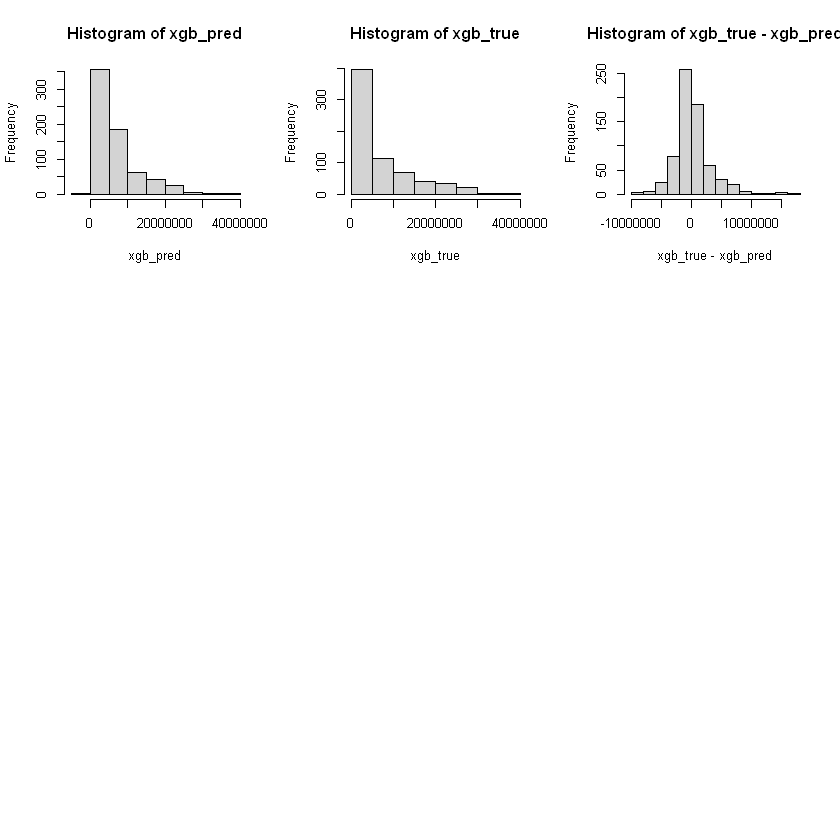

In [637]:
par(mfrow =c(3, 3))

hist(xgb_pred)
hist(xgb_true)
hist(xgb_true-xgb_pred)

# Residual Distribution

In [566]:
currency(mean(xgb_true-xgb_pred))

[1] $222,559.84

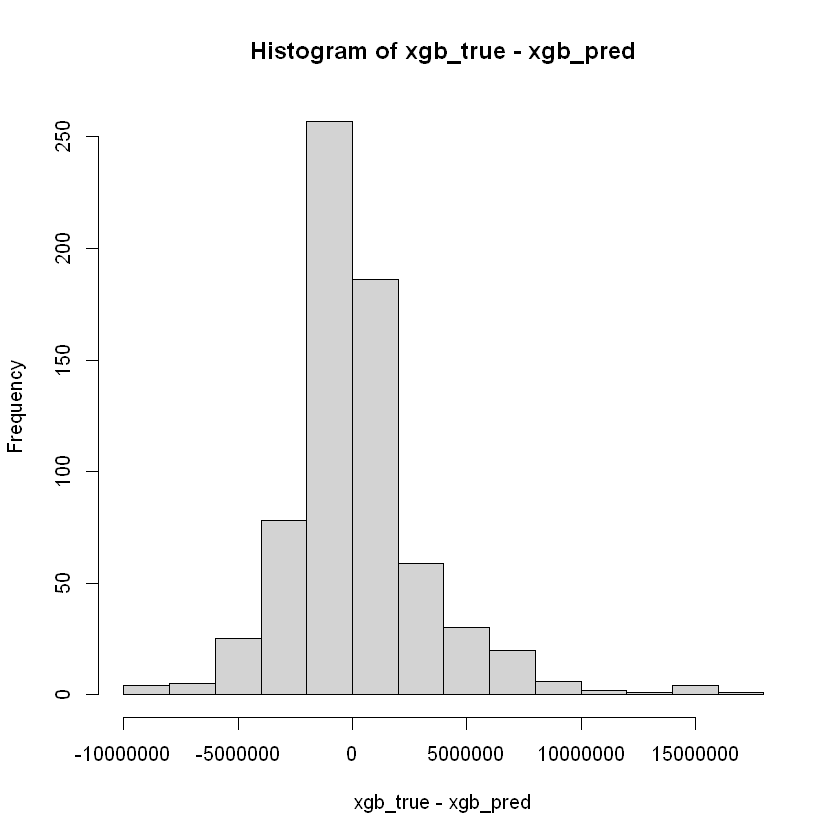

In [567]:
hist(xgb_true-xgb_pred)

# Performance by Decile

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
    4737  1512601  3526440  6737982  9603750 40231758 

dec_t,Mean
<int>,<dbl>
1,721380.4
2,1110834.5
3,1542339.5
4,2213138.6
5,3139618.9
6,4513017.1
7,6586058.8
8,10192711.7
9,15117829.1


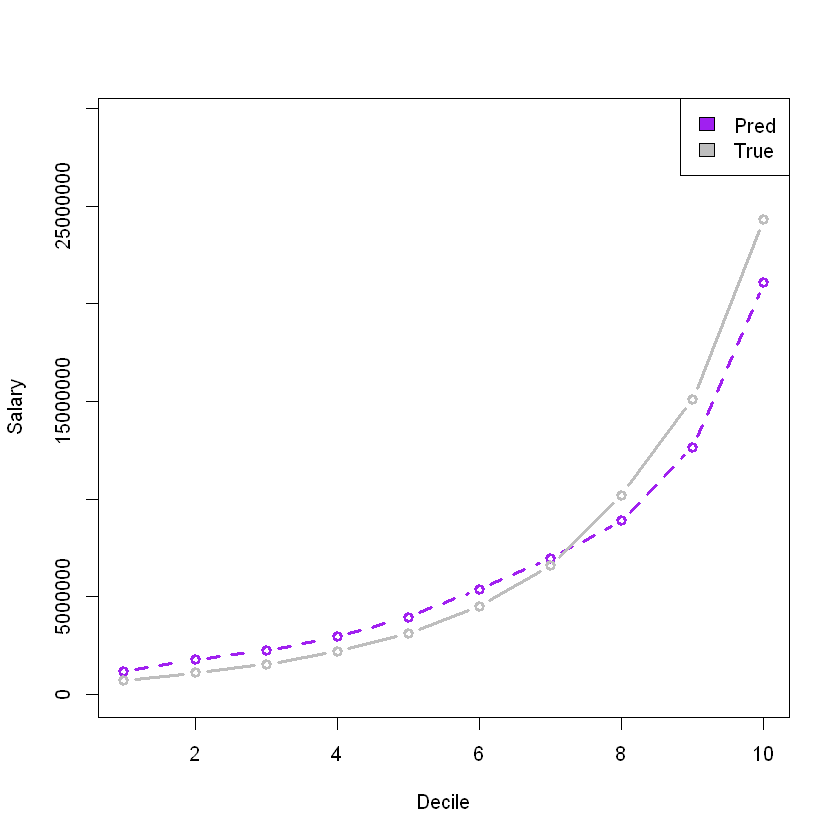

In [568]:
dec_p = ntile(xgb_pred, 10)
dec_t = ntile(xgb_true, 10)

p = data.frame(dec_p, xgb_pred)
t = data.frame(dec_t, xgb_true)

dec_pred <- p %>%
  group_by(dec_p) %>%
  summarise(Mean = mean(xgb_pred))

dec_true <- t %>%
  group_by(dec_t) %>%
  summarise(Mean = mean(xgb_true))

summary(data$TARGET)

dec_true

plot(
    dec_pred$dec_p, 
    dec_pred$Mean, 
    type='b', 
    lwd=3, 
    ylim=c(0, max(dec_true)+5000000), 
    lty=2, 
    col='purple', 
    xlab='Decile',
    ylab='Salary'
)
lines(dec_true$dec_t, dec_true$Mean, type='b', lwd=3, ylim=c(0, max(dec_true)+5000000), col='gray', )

legend(x = "topright", legend=c("Pred", "True"), 
       fill = c("purple","gray")
)

# Regression Acc Metrics Decile Basis

In [569]:
data.frame(list(
    'decile.mean.mae'=currency(mae(dec_true$Mean, dec_pred$Mean)),
    'decile.mean.mape'=mape(dec_true$Mean, dec_pred$Mean),
    'decile.mean.rmse'=currency(rmse(dec_true$Mean, dec_pred$Mean))
))

decile.mean.mae,decile.mean.mape,decile.mean.rmse
<formttbl>,<dbl>,<formttbl>
"$1,167,976.72",0.2974443,"$1,469,040.93"


# Correlation Decile Basis

In [570]:
# rank - pearson correlation
cor(dec_t, dec_p)

[1] 0.8472408

In [571]:
# salary - correlation
cor(xgb_true, xgb_pred)

[1] 0.9122563

In [572]:
# Rank - Kendall's Tau measure of agreement
cor.test(t$dec_t, p$dec_p, method="kendall")


	Kendall's rank correlation tau

data:  t$dec_t and p$dec_p
z = 25.424, p-value < 0.00000000000000022
alternative hypothesis: true tau is not equal to 0
sample estimates:
      tau 
0.7166932 


# Decile Ranking Accuracy

In [573]:
# Rank error
data.frame(list(
    'rank.mae'=mae(t$dec_t, p$dec_p),
    'rank.mape'=mape(t$dec_t, p$dec_p),
    'rank.rmse'=rmse(t$dec_t, p$dec_p)
))

rank.mae,rank.mape,rank.rmse
<dbl>,<dbl>,<dbl>
1.120944,0.3624824,1.585331


# Feature Importance

- Gain represents fractional contribution of each feature to the model based on the total gain of this feature's splits. Higher percentage means a more important predictive feature.

- Cover metric of the number of observation related to this feature;
    - the sum of second order gradient of training data classified to the leaf, if it is square loss, this simply corresponds to the number of instances in that branch. Deeper in the tree a node is, lower this metric will be. [Source](https://github.com/dmlc/xgboost/blob/f5659e17d5200bd7471a2e735177a81cb8d3012b/R-package/man/xgb.plot.tree.Rd)
    
- Frequency percentage representing the relative number of times a feature have been used in trees.

In [574]:
importance_matrix = xgb.importance(colnames(xgb_train), model = model)
importance_matrix

Feature,Gain,Cover,Frequency
<chr>,<dbl>,<dbl>,<dbl>
TW_FOLLOWERS,0.27033307709,0.09699672325,0.0667483160
EXPERIENCE,0.26755374378,0.09212503777,0.0747091243
PTS,0.16058860637,0.03532198898,0.0459277404
MPG,0.05303145970,0.05467257787,0.0496019596
RPG,0.03395468987,0.04207258643,0.0551132884
APG,0.02352321499,0.04556977454,0.0373545622
BLKPG,0.01702010342,0.04412914570,0.0373545622
INJURIES,0.01429202491,0.02583406705,0.0373545622
TEAM_REVENUE,0.01277956938,0.05521848673,0.0428658910


# TOP 10 Features

In [575]:
importance_matrix$Feature[1:10]

[1] "TW_FOLLOWERS" "EXPERIENCE"   "PTS"          "MPG"          "RPG"         
 [6] "APG"          "BLKPG"        "INJURIES"     "TEAM_REVENUE" "poss"

In [576]:
importance_matrix[1:10]

Feature,Gain,Cover,Frequency
<chr>,<dbl>,<dbl>,<dbl>
TW_FOLLOWERS,0.27033308,0.09699672,0.06674832
EXPERIENCE,0.26755374,0.09212504,0.07470912
PTS,0.16058861,0.03532199,0.04592774
MPG,0.05303146,0.05467258,0.04960196
RPG,0.03395469,0.04207259,0.05511329
APG,0.02352321,0.04556977,0.03735456
BLKPG,0.01702010,0.04412915,0.03735456
INJURIES,0.01429202,0.02583407,0.03735456
TEAM_REVENUE,0.01277957,0.05521849,0.04286589


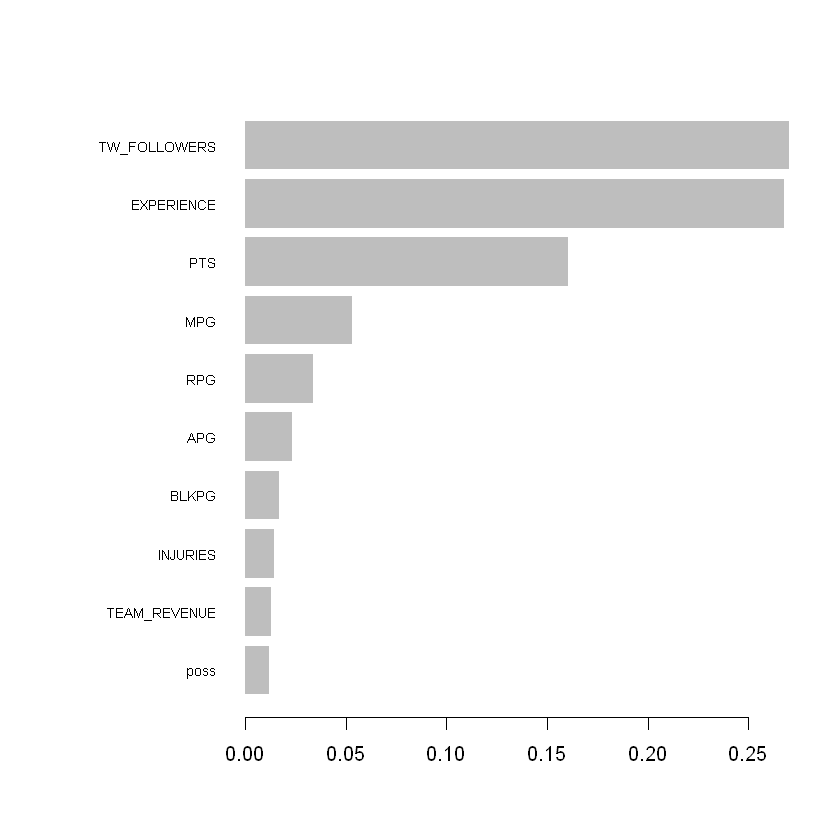

In [577]:
xgb.plot.importance(importance_matrix[1:10])

# XGBoost Explainer

In [578]:
# ?buildExplainer

In [579]:
explainer = buildExplainer(model, xgb_train, type="regression")
pred.breakdown = explainPredictions(model, explainer, xgb_test) 
# https://github.com/AppliedDataSciencePartners/xgboostExplainer/blob/31c49169d17cd426a1f445b42ddeaaab2766c358/R/getLeafBreakdown.R


Creating the trees of the xgboost model...
Getting the leaf nodes for the training set observations...
Building the Explainer...
STEP 1 of 2

Recalculating the cover for each non-leaf... 
  |======================================================================| 100%

Finding the stats for the xgboost trees...
  |======================================================================| 100%

STEP 2 of 2

Getting breakdown for each leaf of each tree...
  |======================================================================| 100%

DONE!



Extracting the breakdown of each prediction...
  |======================================================================| 100%

DONE!


# Calulate Residuals

In [580]:
player_idx <- function(i) {
    p = test_x[i,]
    p1 = merge(data, p, by=names(test_x))
    df <- pred.breakdown[i,]
    
    df$YEAR <- p1$YEAR
    df$PLAYER <- p1$PLAYER
    df$TARGET <- p1$TARGET
    df$PREDICTION <- sum(pred.breakdown[i,])
    df$E <- df$TARGET - df$PREDICTION

    return (df)
}

In [581]:
ncol = length(names(player_idx(1)))

# Create dataframe with log-odds contribution by features and actuals, predictions, quantiles

In [582]:
res <- data.frame(matrix(ncol = ncol, nrow = 0))
colnames(res) <- names(player_idx(1))

for (i in c(1:length(test_x$MPG))) {
    res[nrow(res) + 1,] <- player_idx(i)
}

In [583]:
# validate from above
mean(res$E)
mean(xgb_true-xgb_pred)

[1] 222559.7

[1] 222559.8

# Create Quartile Rankings

In [584]:
res = mutate(res, quantile_rank = ntile(res$TARGET, 4))

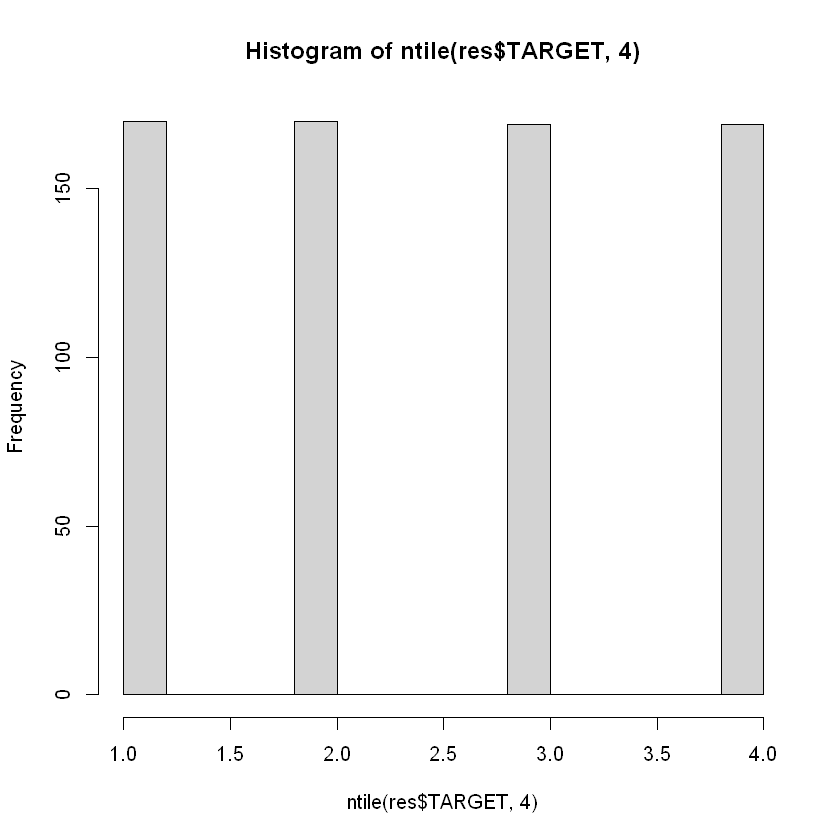

In [585]:
hist(ntile(res$TARGET, 4))

# Create Decile Rankings

In [586]:
res = mutate(res, decile_rank = ntile(res$TARGET, 10))

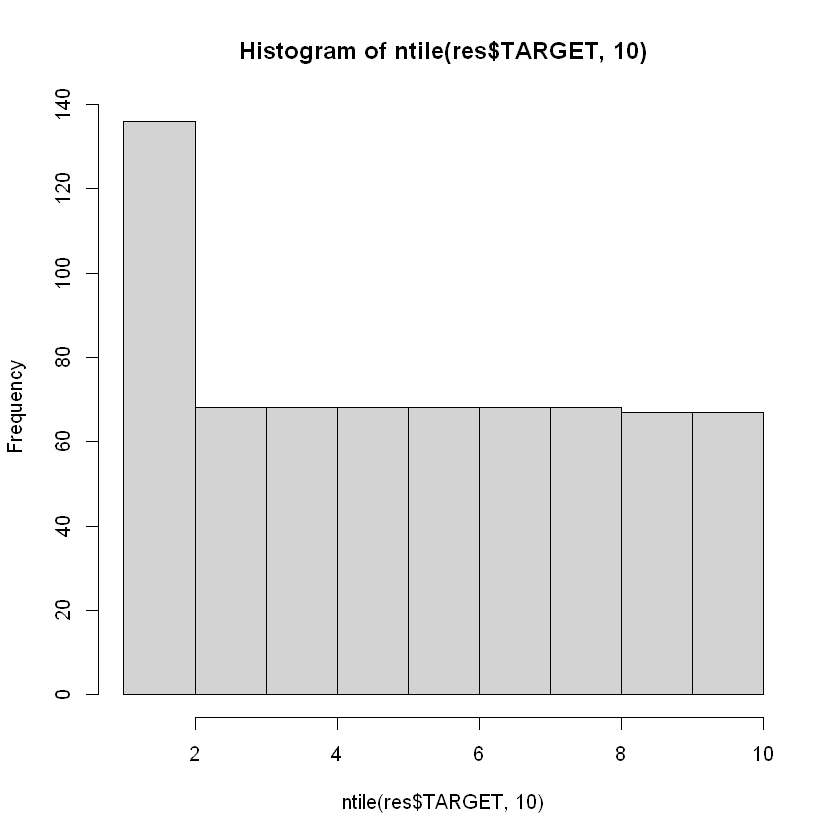

In [587]:
hist(ntile(res$TARGET, 10))

In [588]:
head(res)

,GP,MPG,FG.,FT.,PTS,RPG,APG,STPG,BLKPG,SAL_CAP,⋯,POS.2_SF.1,POS.2_SG.1,intercept,YEAR,PLAYER,TARGET,PREDICTION,E,quantile_rank,decile_rank
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<int>,<chr>,<int>,<dbl>,<dbl>,<int>,<int>
1,60839.430,-412721.9,12984.659,-121920.58,-1557080.2,-290517.3,-915587.93,-801.0301,-394127.705,0.00,⋯,-47360.52,0,6647114,2018,Aaron Brooks,1471382,5359189,-3887807.4,1,3
2,17808.353,-899341.5,-4907.608,-50239.46,-1565101.0,-393817.7,482118.87,-801.0301,-430233.849,0.00,⋯,-47360.52,0,6647114,2017,Aaron Brooks,2700000,5201178,-2501177.6,2,5
3,10296.473,-294699.0,8397.119,32524.34,-659774.4,-216621.5,127498.02,211992.5493,-58869.908,-24977.65,⋯,0.00,0,6647114,2020,Aaron Holiday,2329200,1925532,403667.8,2,4
4,-4786.567,-346641.1,35076.566,-10849.06,-687964.6,-254461.2,-84158.08,-801.0301,-3813.434,-24977.65,⋯,0.00,0,6647114,2018,Abdel Nader,1167333,1515364,-348030.6,1,2
5,-4786.567,-283356.4,37925.295,45312.92,-687964.6,-254461.2,37912.68,-801.0301,-3813.434,-24977.65,⋯,0.00,0,6647114,2019,Abdel Nader,1378242,1728168,-349926.1,1,2
6,56419.418,-396223.3,10135.931,-10849.06,-777993.7,-282665.0,-84158.08,15803.8195,30680.406,-24977.65,⋯,0.00,0,6647114,2017,Adreian Payne,2022240,1866921,155319.0,2,4


# Error Year-over-year

YEAR,MAE,RMSE
<int>,<dbl>,<dbl>
2014,1885346,3049275
2015,2003302,2912502
2016,1799969,2564856
2017,2276718,3041619
2018,2455819,3820170
2019,1975022,2854616
2020,2147567,3365159


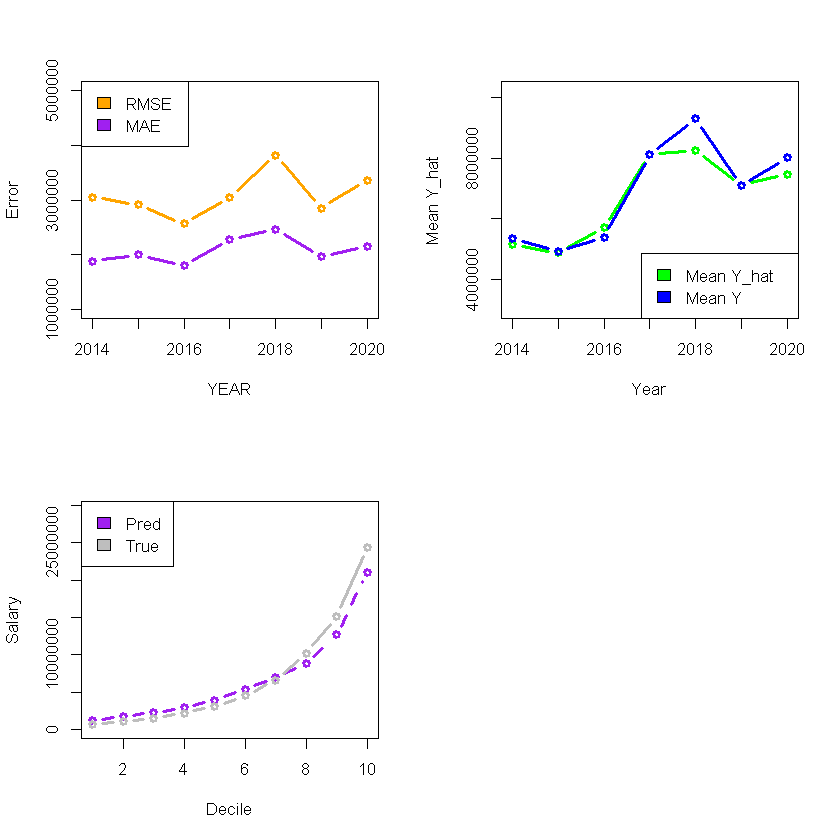

In [655]:
par(mfrow =c(2, 2))
e.yoy <- res %>%
  group_by(YEAR) %>%
  summarise(MAE = mae(PREDICTION, TARGET), RMSE = rmse(PREDICTION, TARGET))

e.yoy

plot(e.yoy$YEAR, e.yoy$RMSE, type='b', lwd=3, col='Orange', ylab='Error',  xlab='YEAR', ylim=c(1000000,5000000))
lines(e.yoy$YEAR, e.yoy$MAE, type='b', lwd=3, col='Purple')

legend(x = "topleft", legend=c("RMSE", "MAE"), 
       fill = c("Orange","Purple")
)

plot(mean.pred$YEAR, mean.pred$Y_PRED_MU, type='b', lwd=3, col='Green', xlab='Year', ylab='Mean Y_hat', ylim=c(3000000, max(mean.pred$Y_PRED_MU) + 2000000), 
)
lines(mean.true$YEAR, mean.true$Y_TRUE_MU, type='b', lwd=3, col='Blue', ylab='Mean Y')

legend(x = "bottomright", legend=c("Mean Y_hat", "Mean Y"), 
       fill = c("Green","Blue")
)

plot(
    dec_pred$dec_p, 
    dec_pred$Mean, 
    type='b', 
    lwd=3, 
    ylim=c(0, max(dec_true)+5000000), 
    lty=2, 
    col='purple', 
    xlab='Decile',
    ylab='Salary'
)
lines(dec_true$dec_t, dec_true$Mean, type='b', lwd=3, ylim=c(0, max(dec_true)+5000000), col='gray', )

legend(x = "topleft", legend=c("Pred", "True"), 
       fill = c("purple","gray")
)

# Mean Accuracy Year-over-year

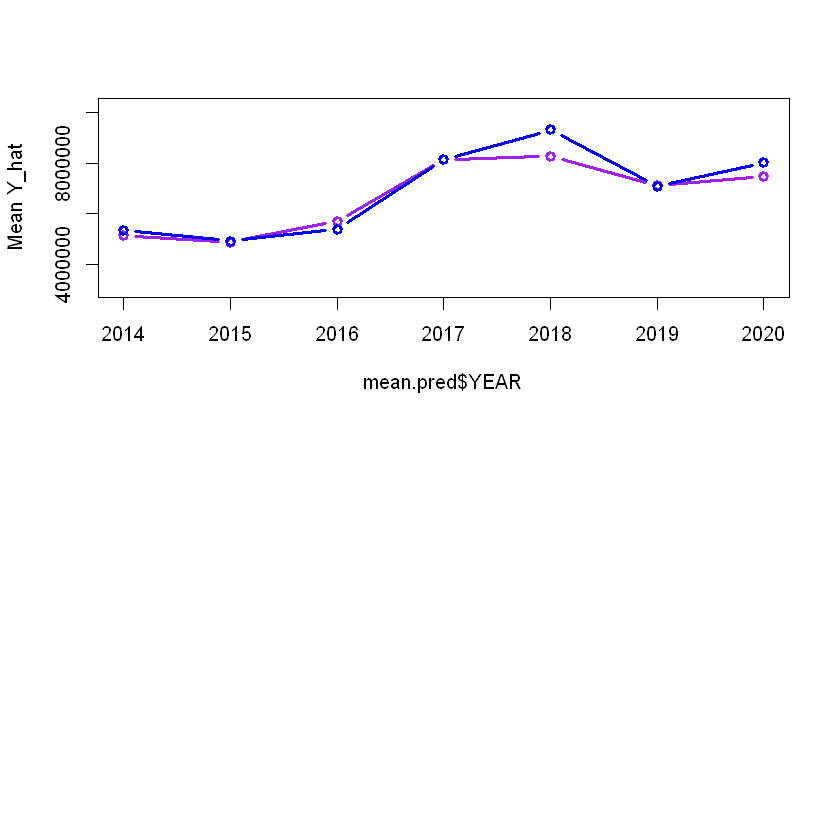

In [590]:
par(mfrow =c(2, 1))

mean.pred <- res %>%
  group_by(YEAR) %>%
  summarise(Y_PRED_MU = mean(PREDICTION))

mean.true <- res %>%
  group_by(YEAR) %>%
  summarise(Y_TRUE_MU = mean(TARGET))
            
plot(mean.pred$YEAR, mean.pred$Y_PRED_MU, type='b', lwd=3, col='Purple', ylab='Mean Y_hat', ylim=c(3000000, max(mean.pred$Y_PRED_MU) + 2000000), 
)
lines(mean.true$YEAR, mean.true$Y_TRUE_MU, type='b', lwd=3, col='Blue', ylab='Mean Y')

# Contribution by Feature

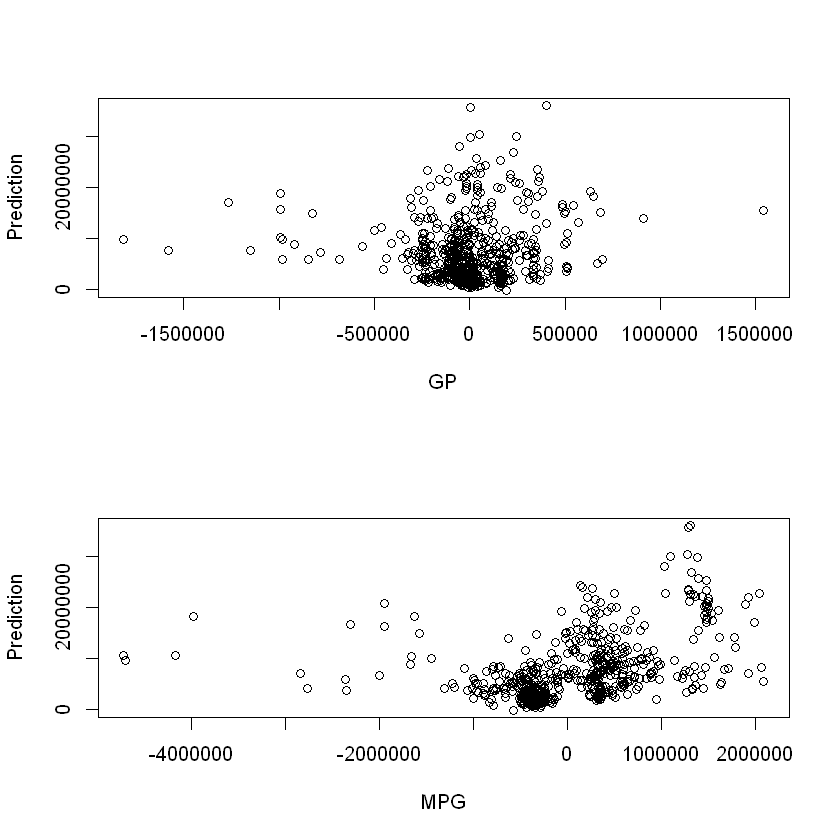

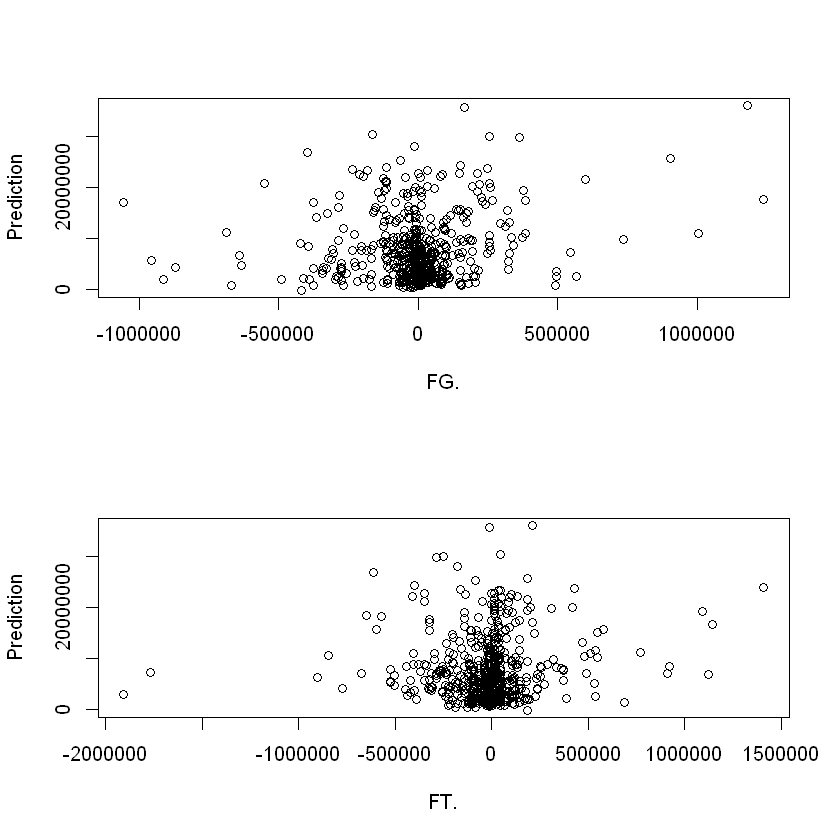

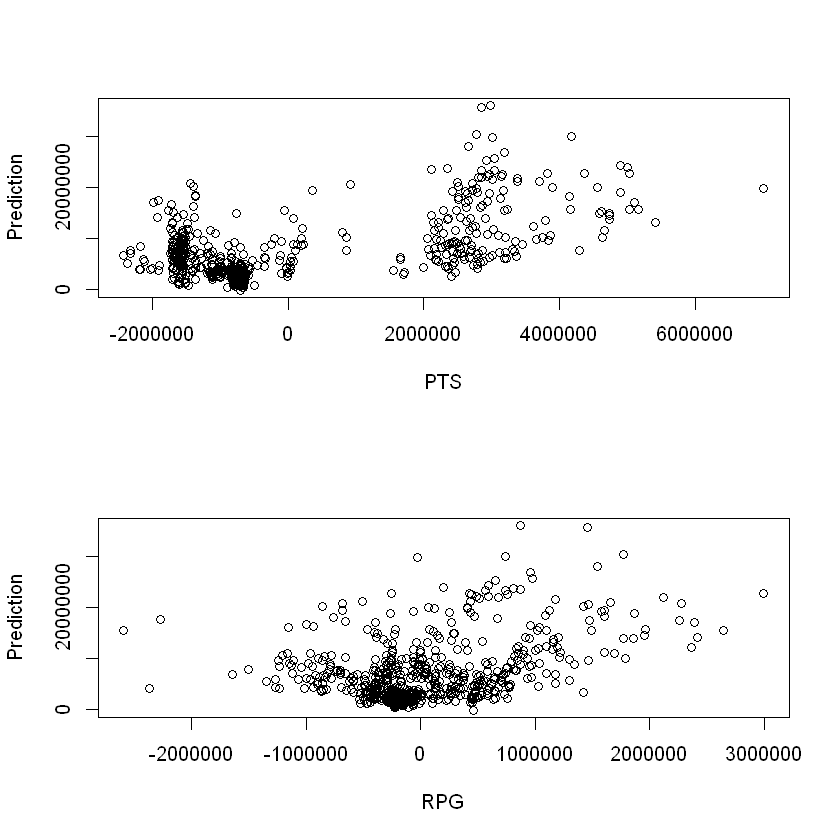

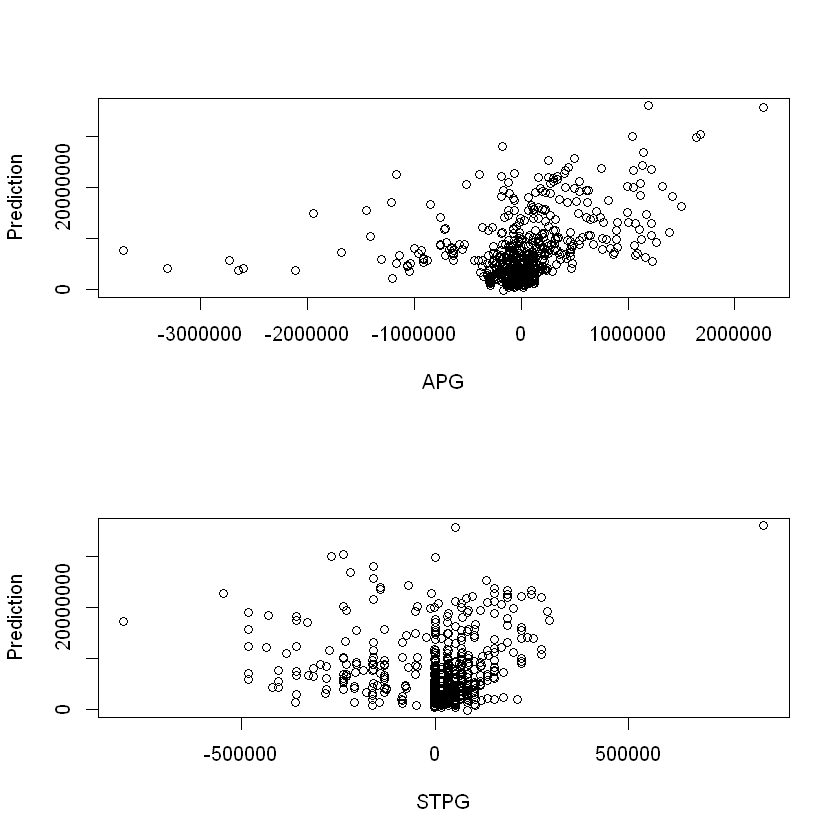

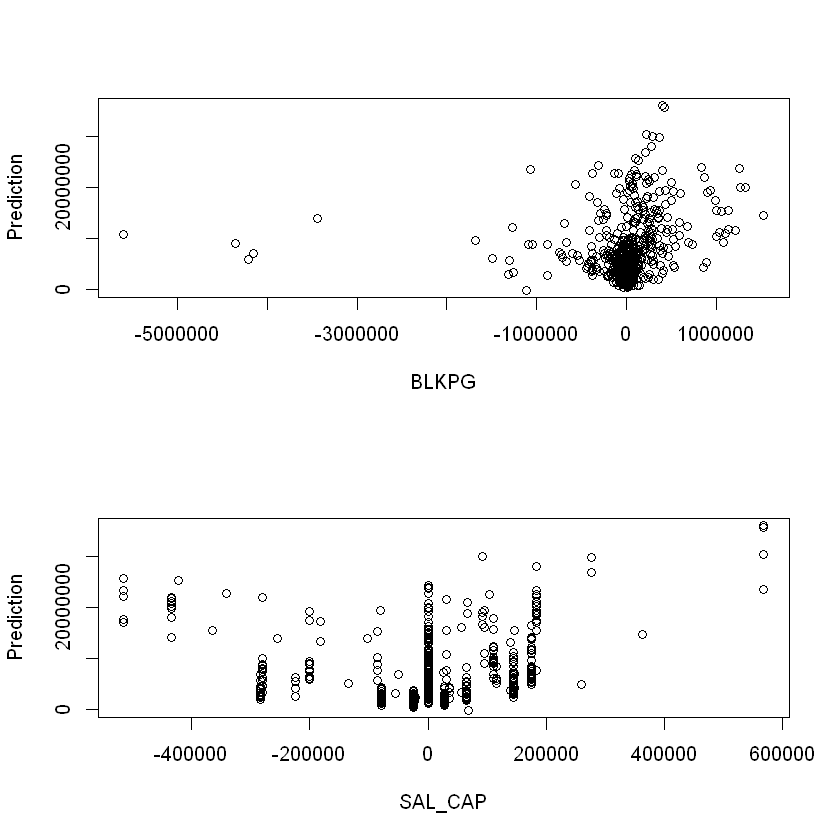

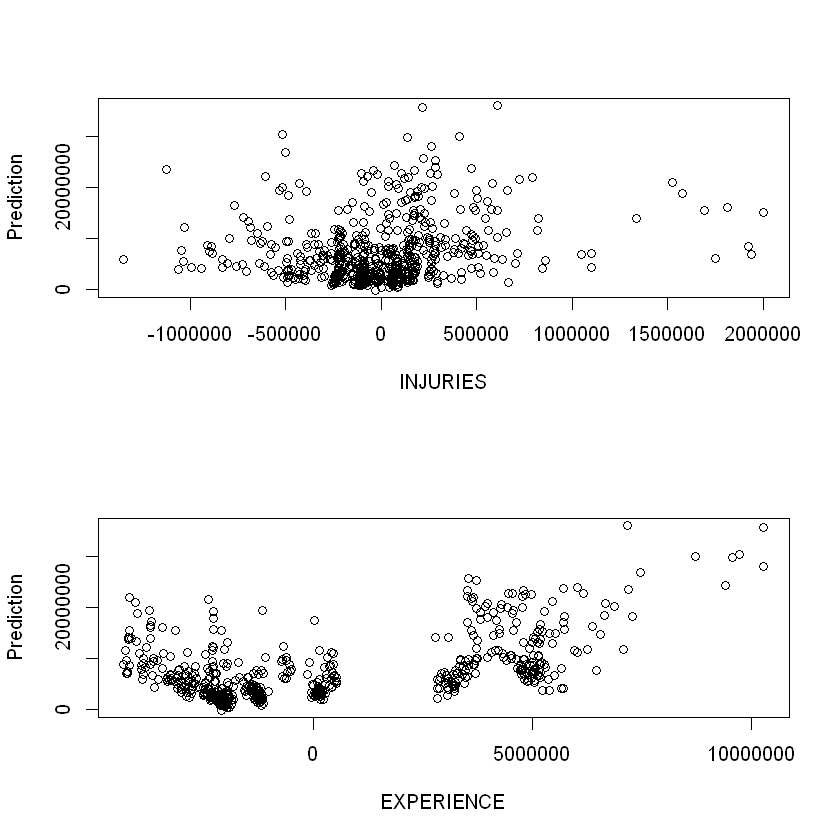

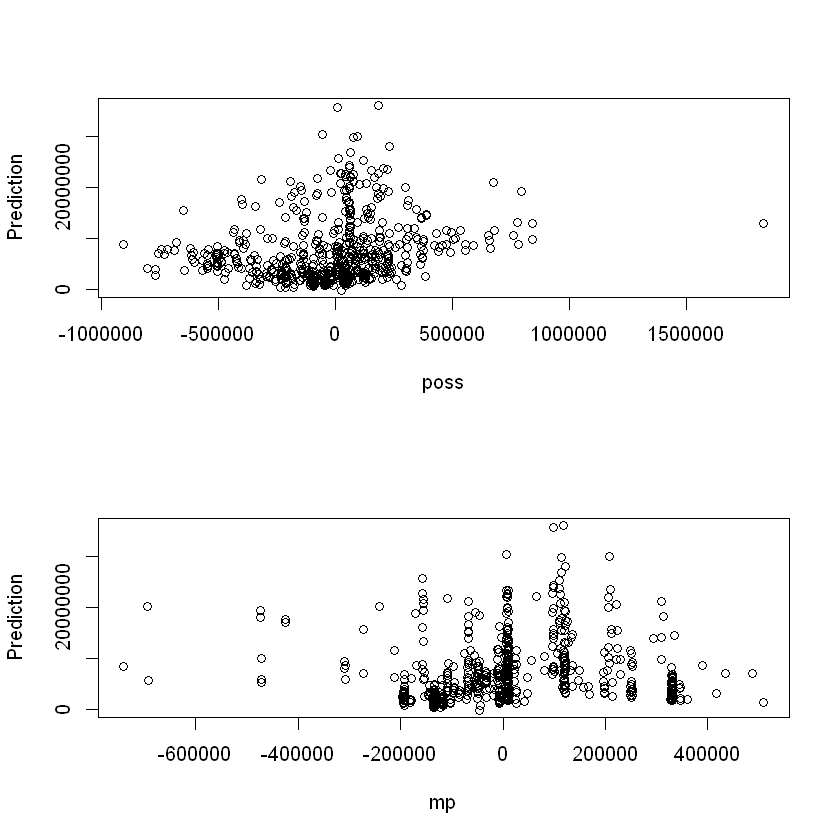

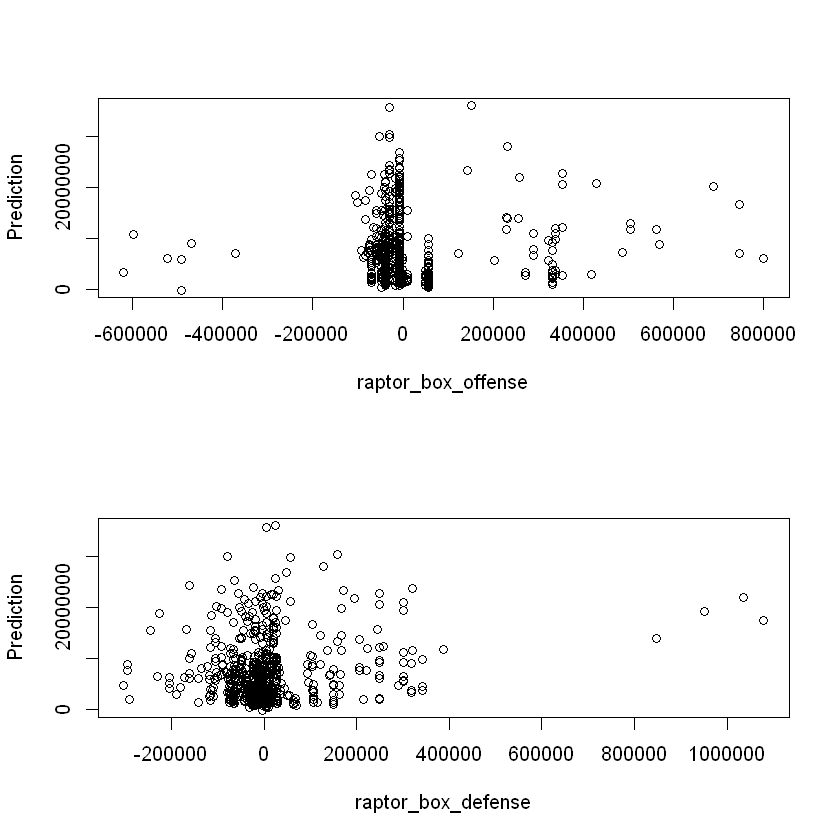

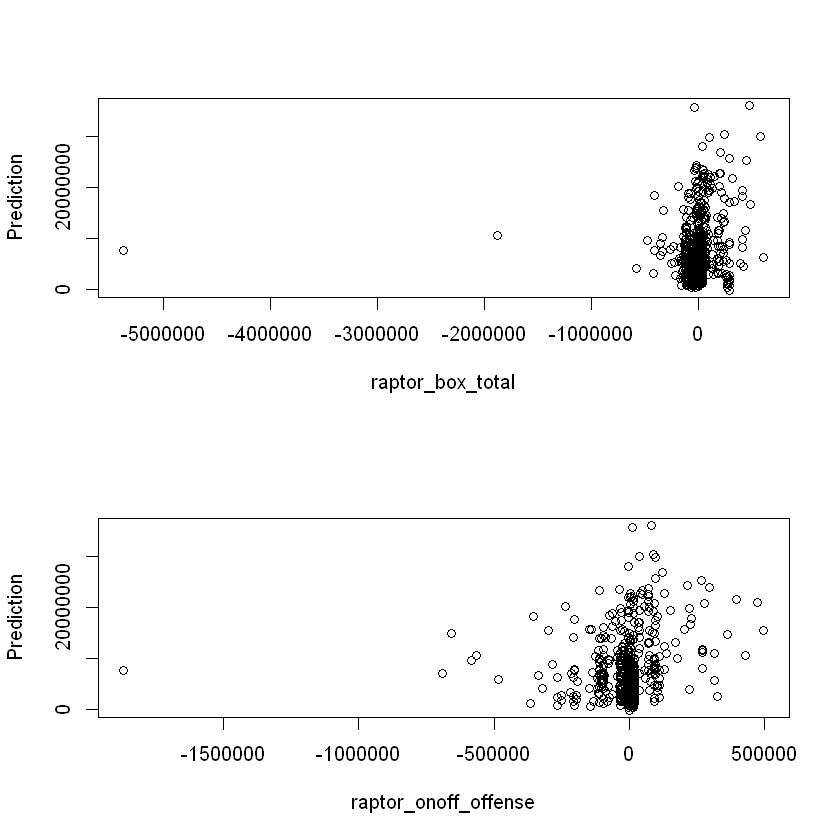

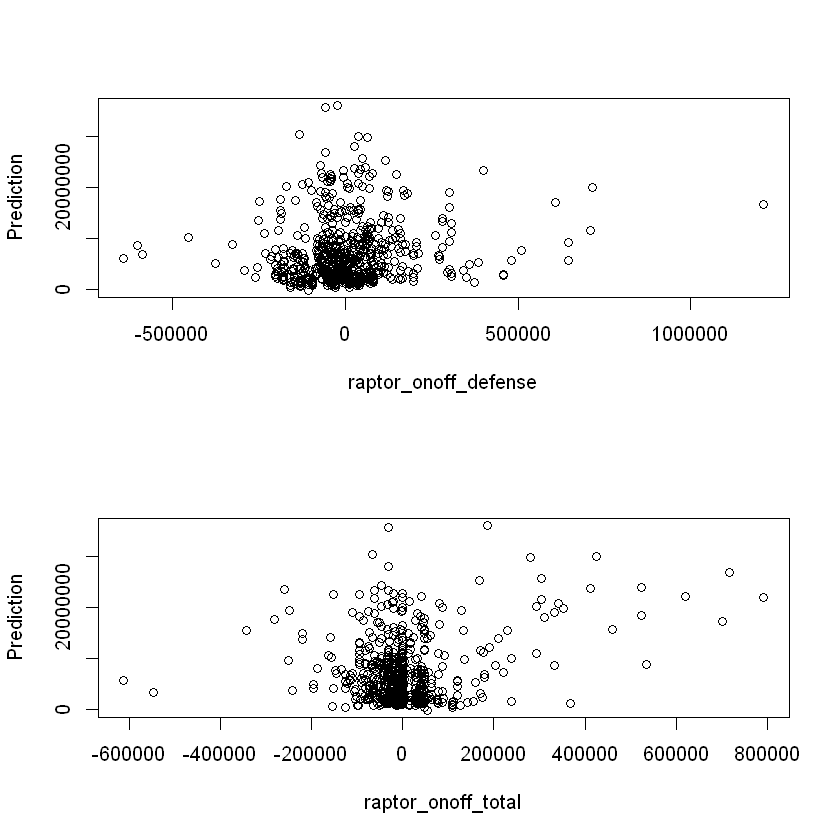

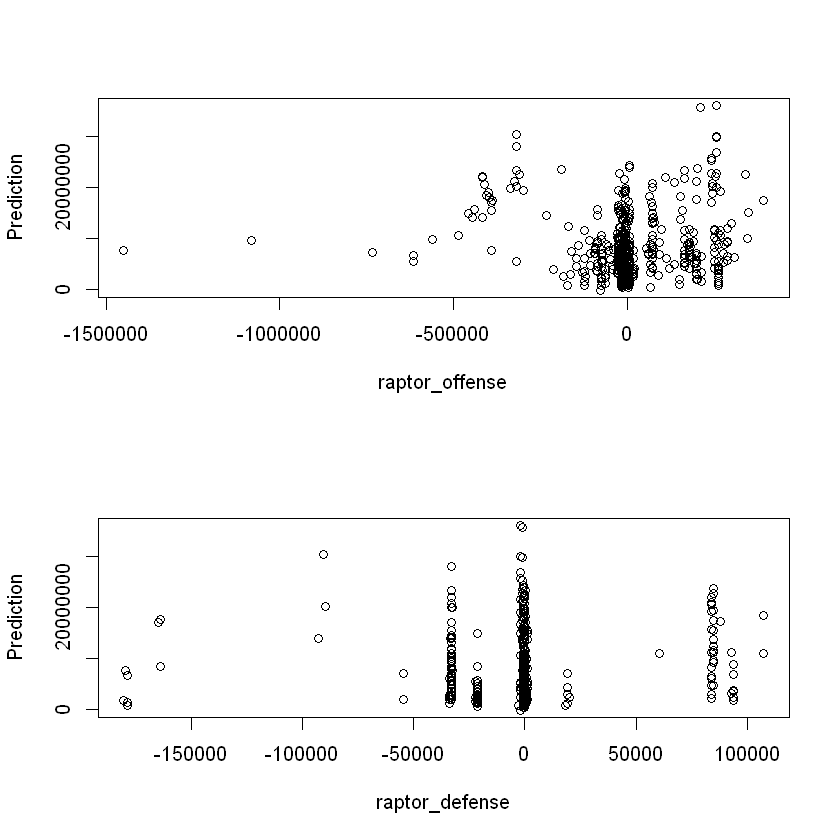

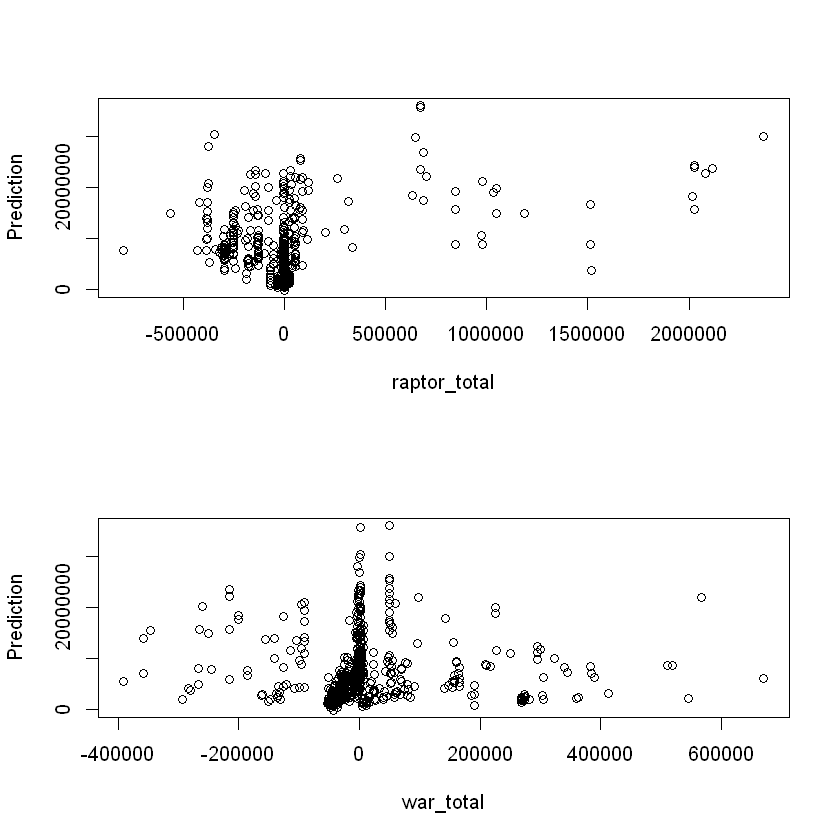

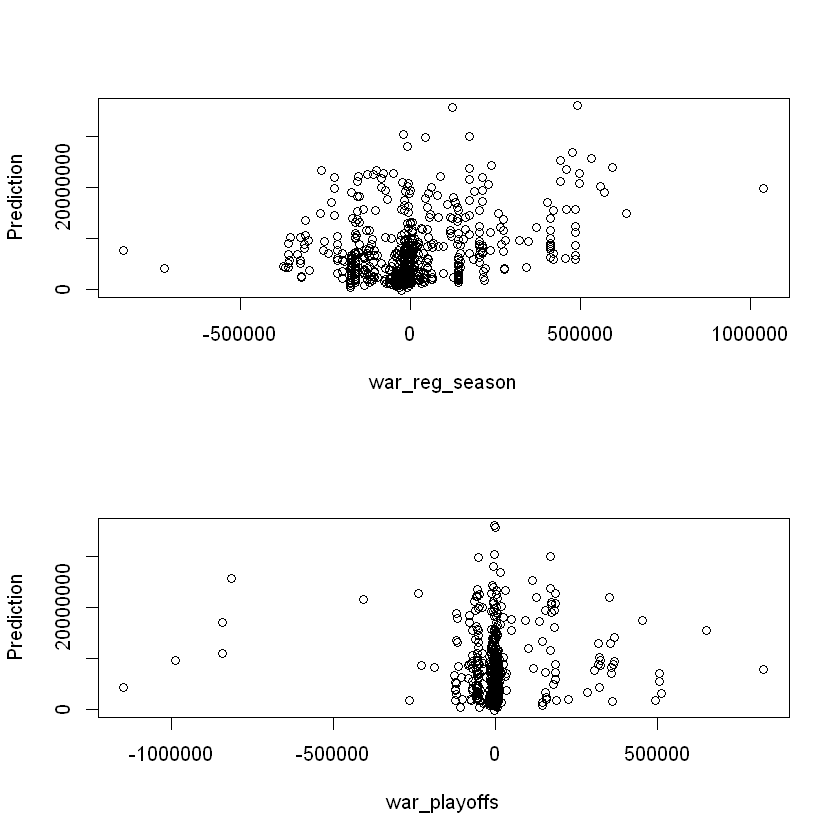

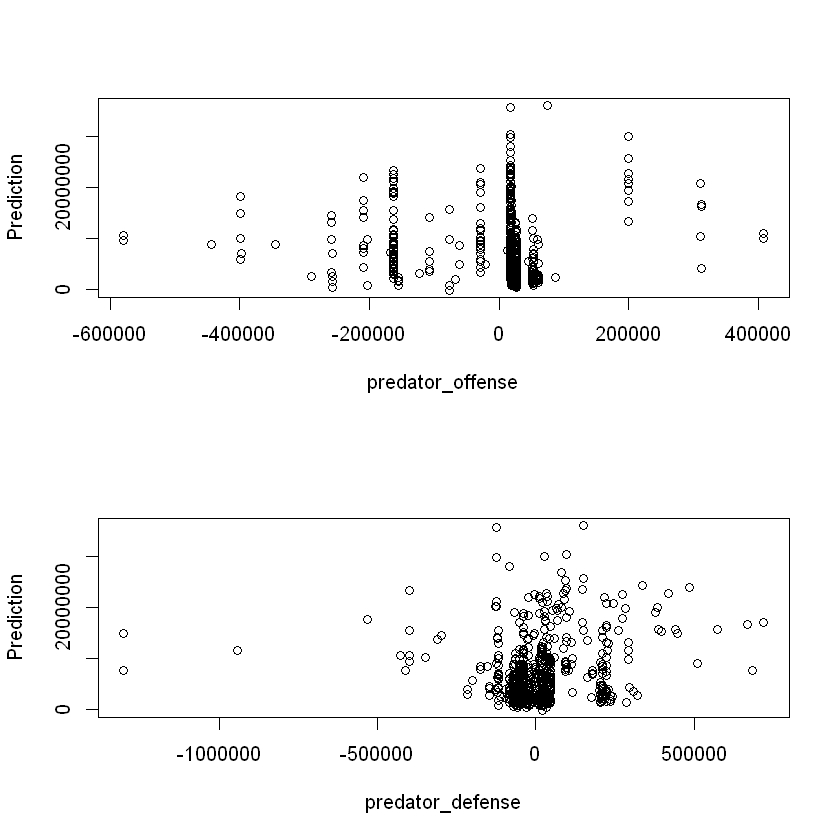

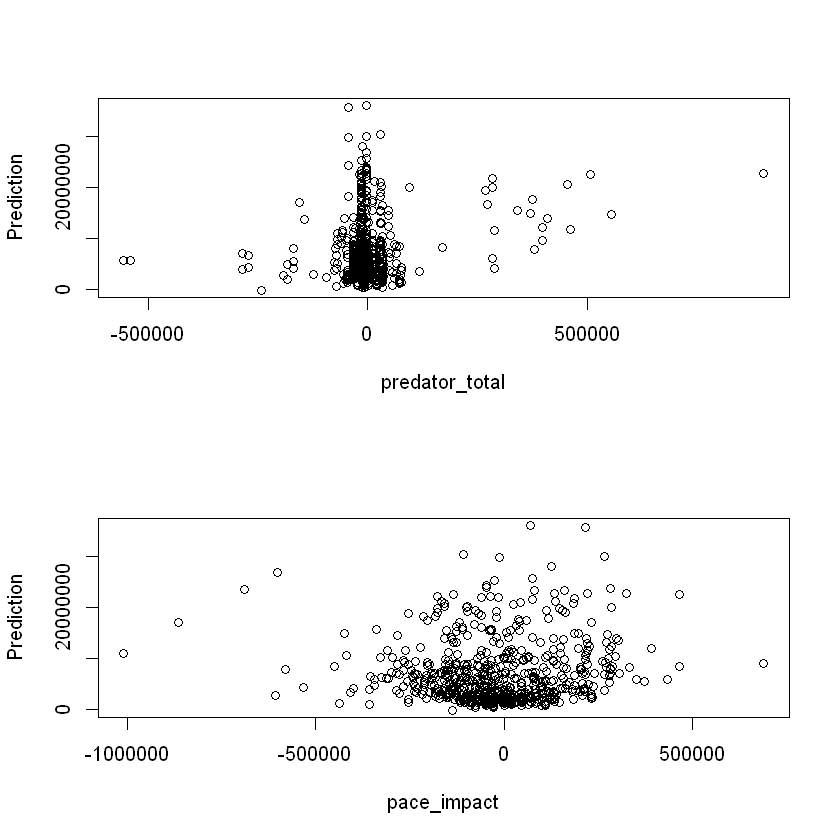

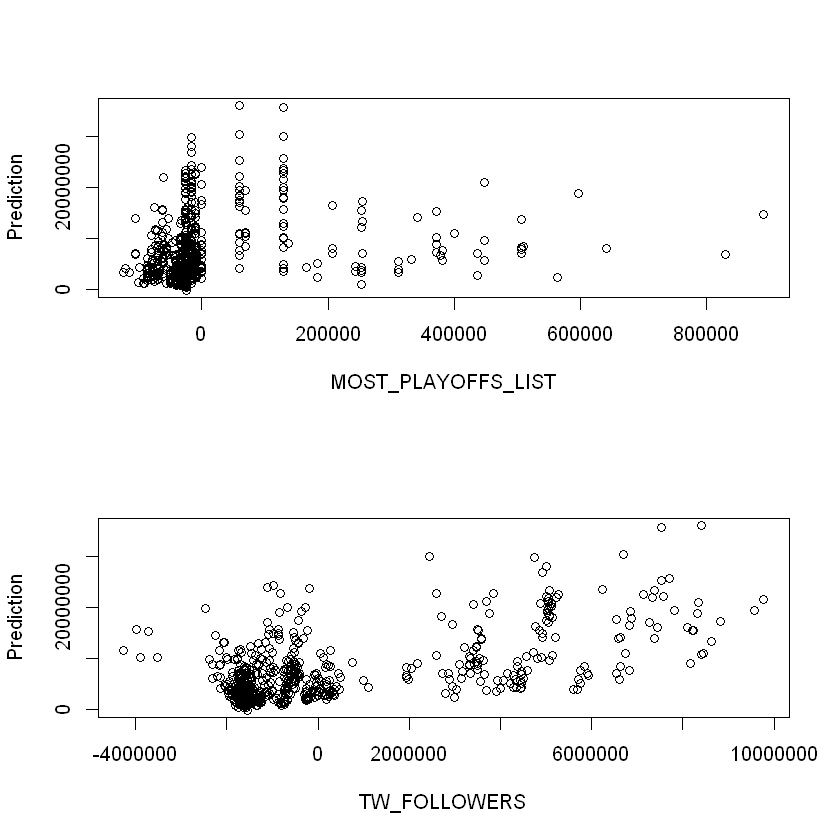

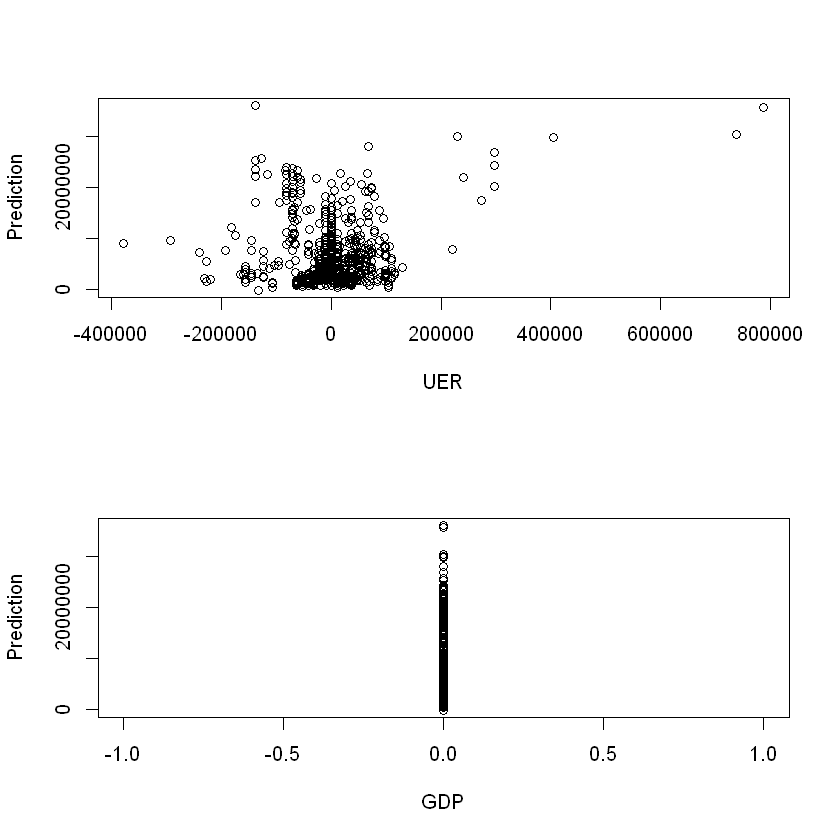

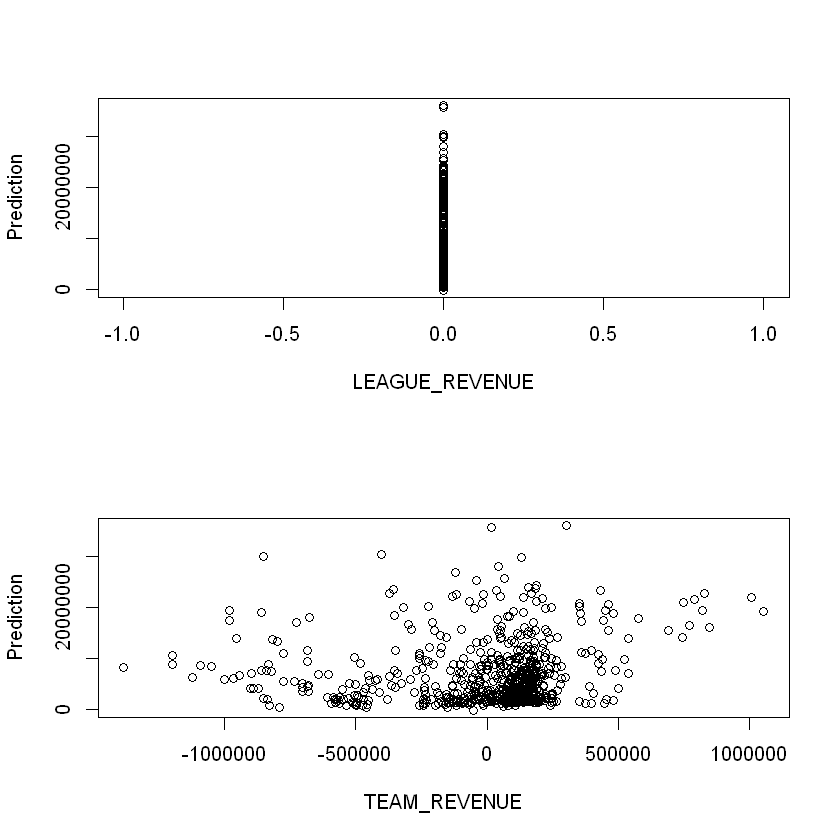

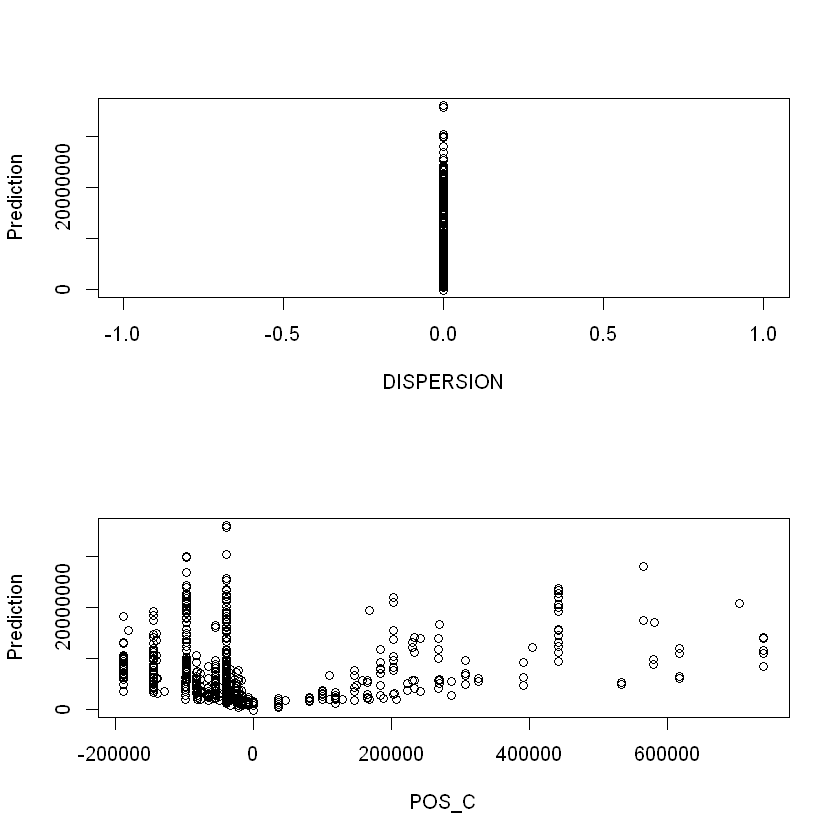

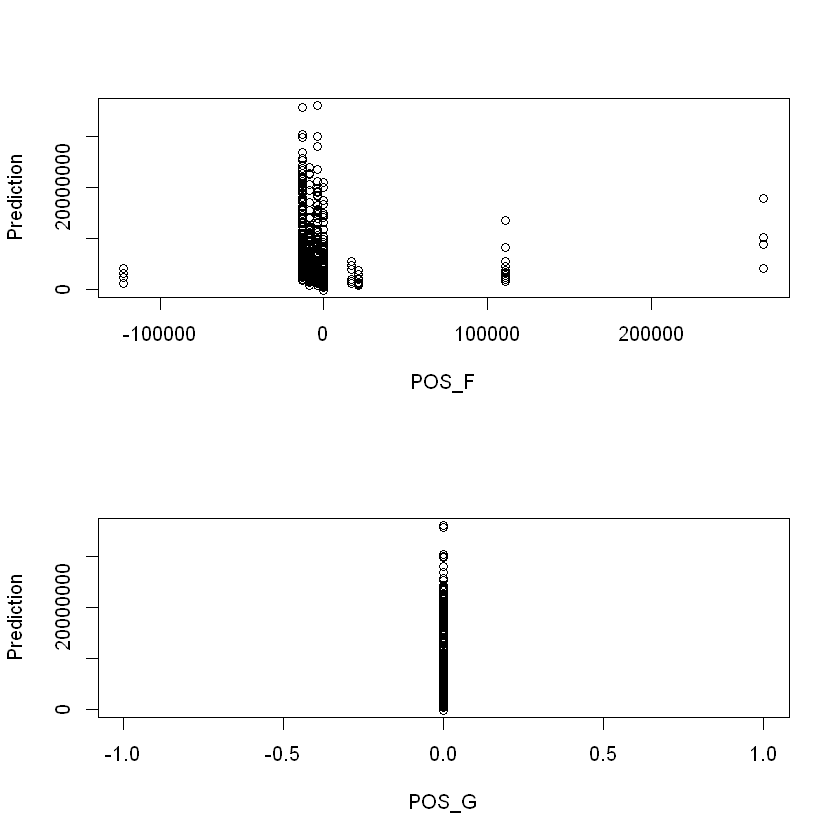

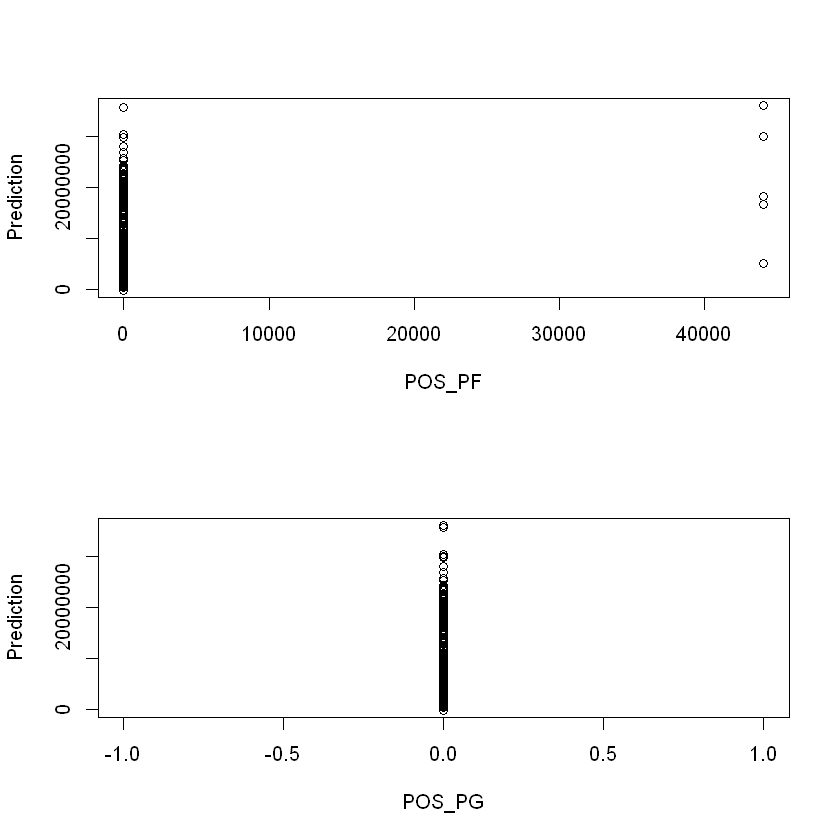

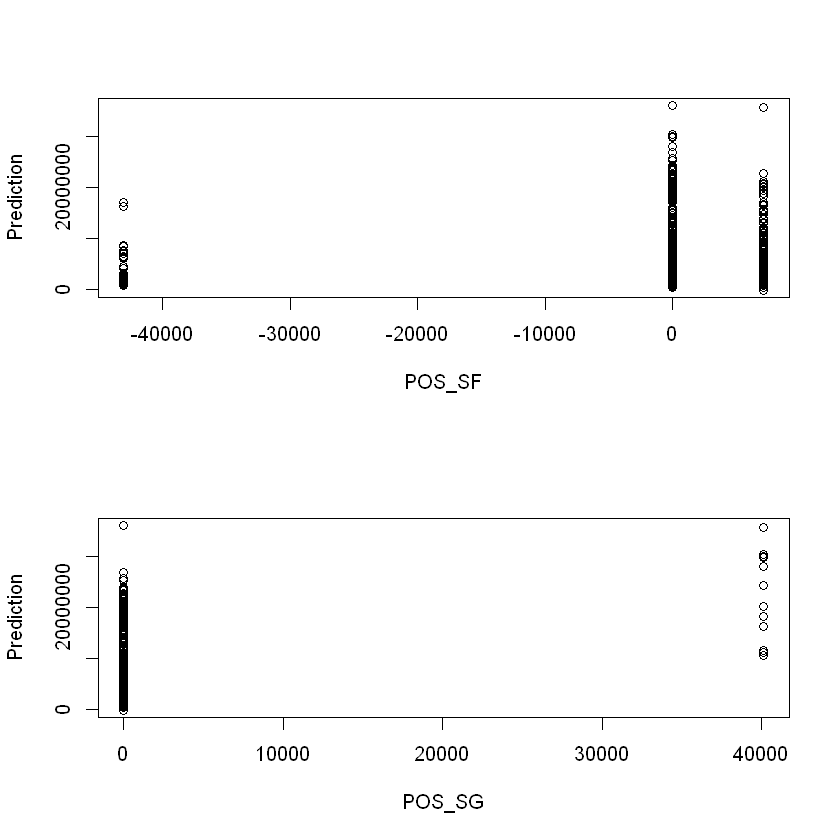

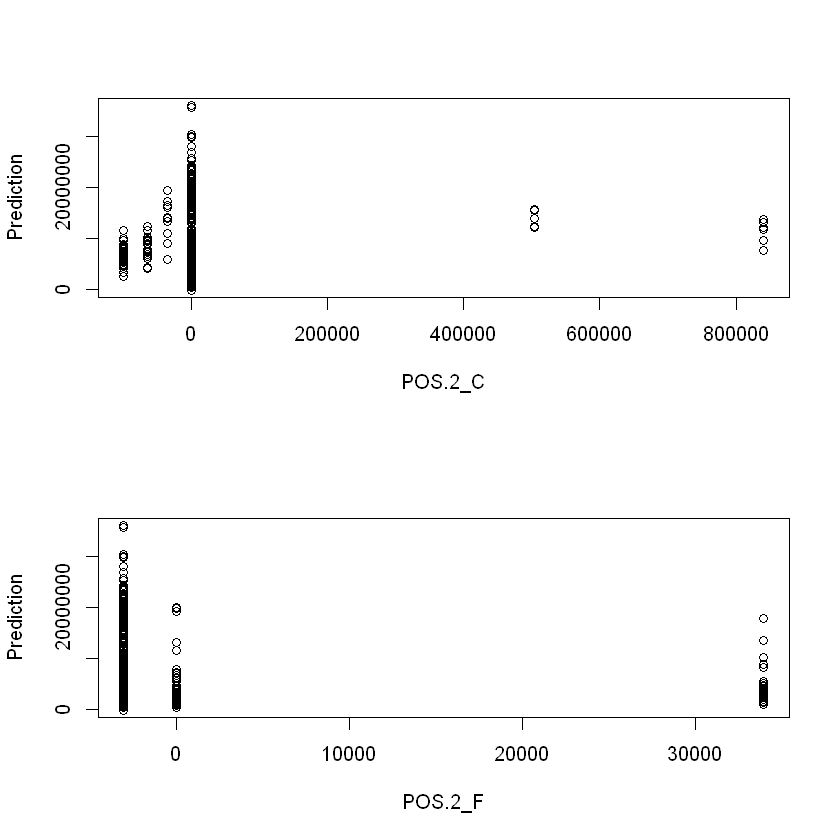

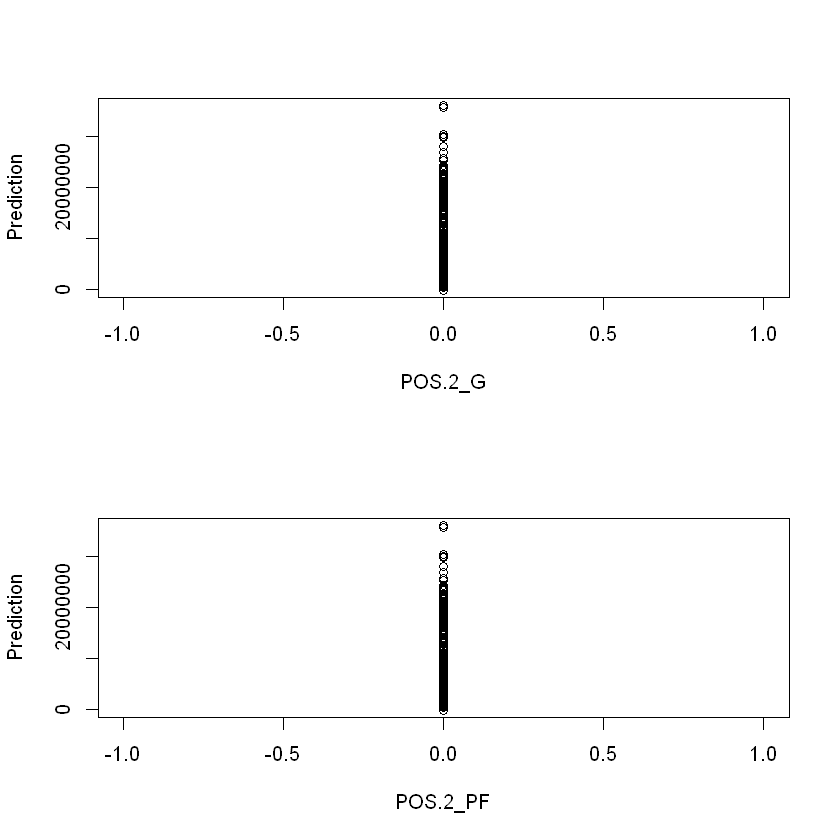

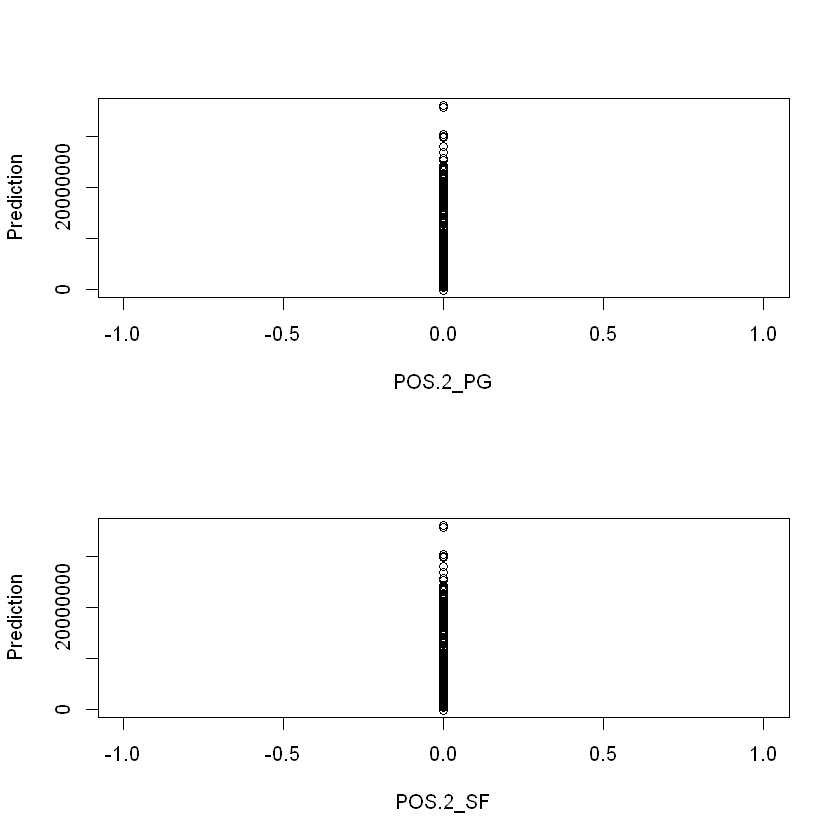

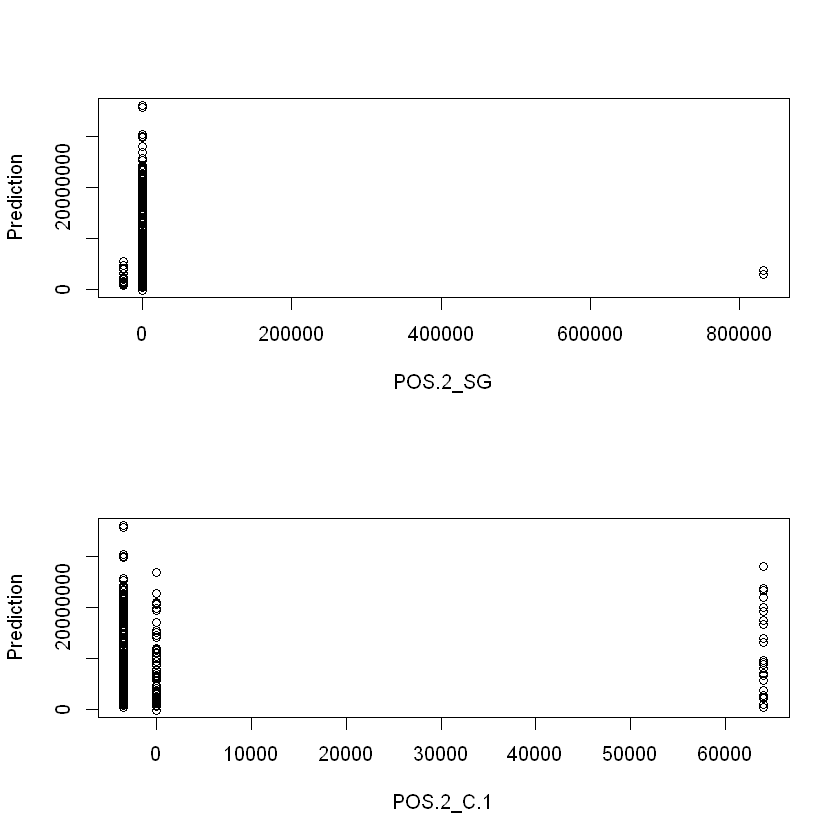

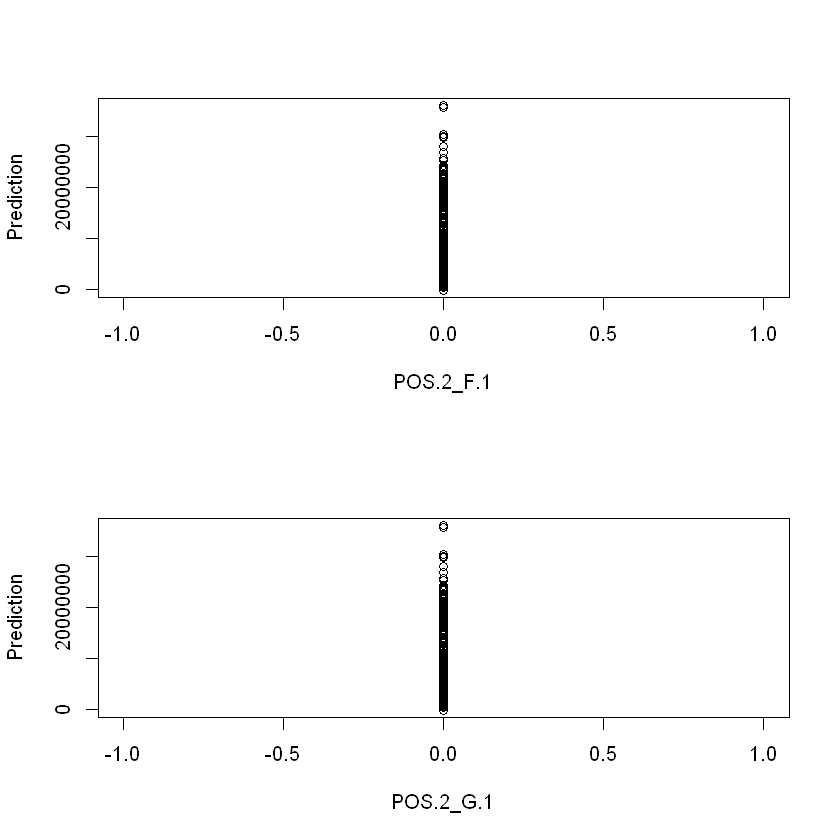

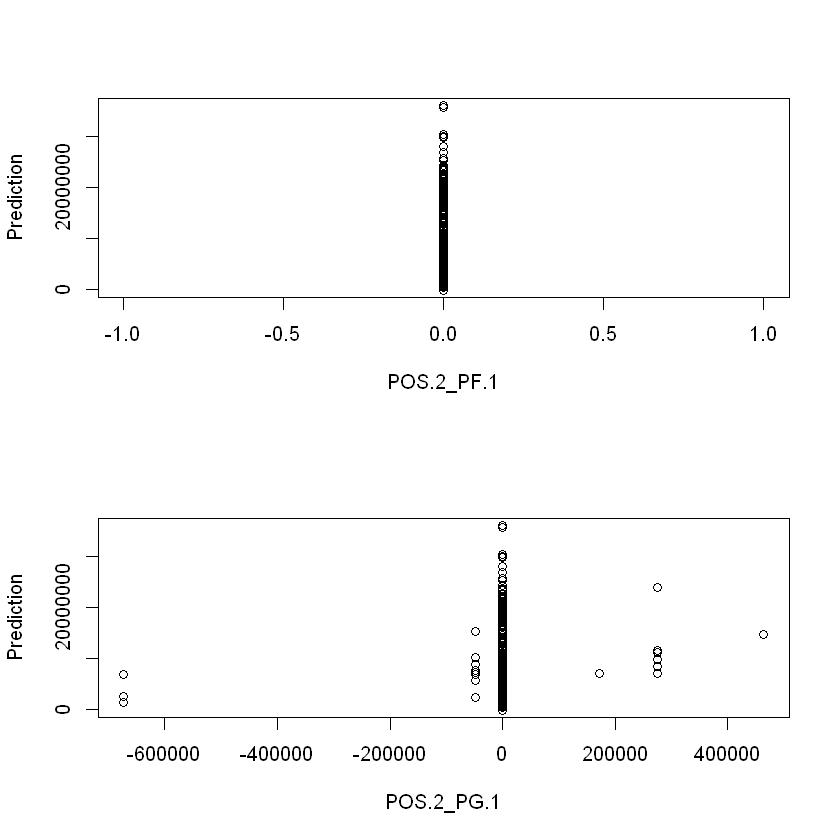

Warning message in xy.coords(x, y, xlabel, ylabel, log):
"NAs introduced by coercion"
Warning message in min(x):
"no non-missing arguments to min; returning Inf"
Warning message in max(x):
"no non-missing arguments to max; returning -Inf"


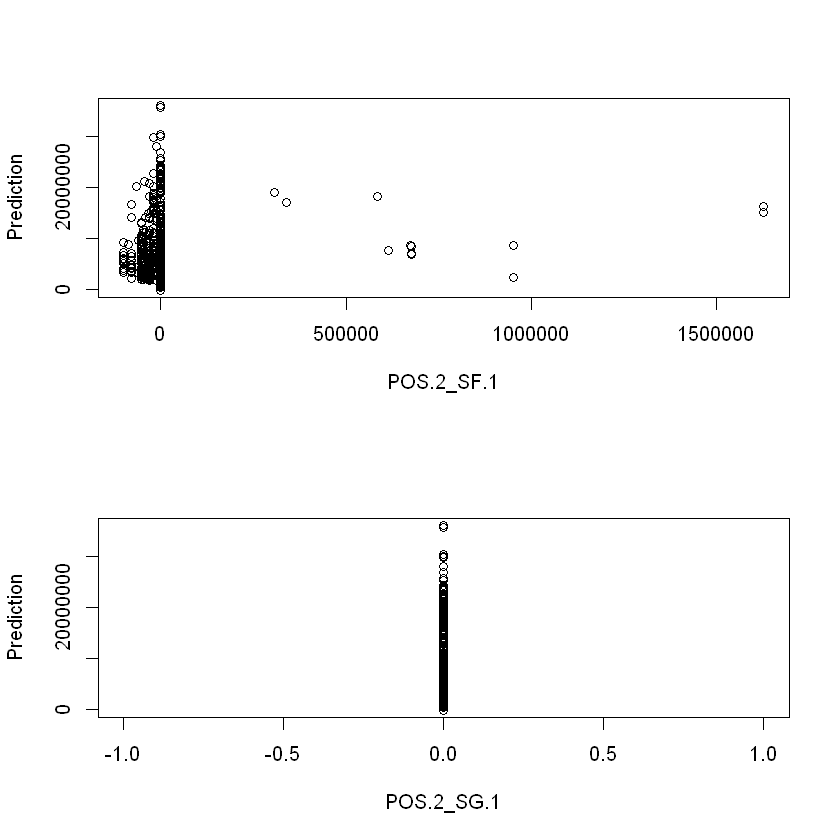

ERROR: Error in plot.window(...): need finite 'xlim' values


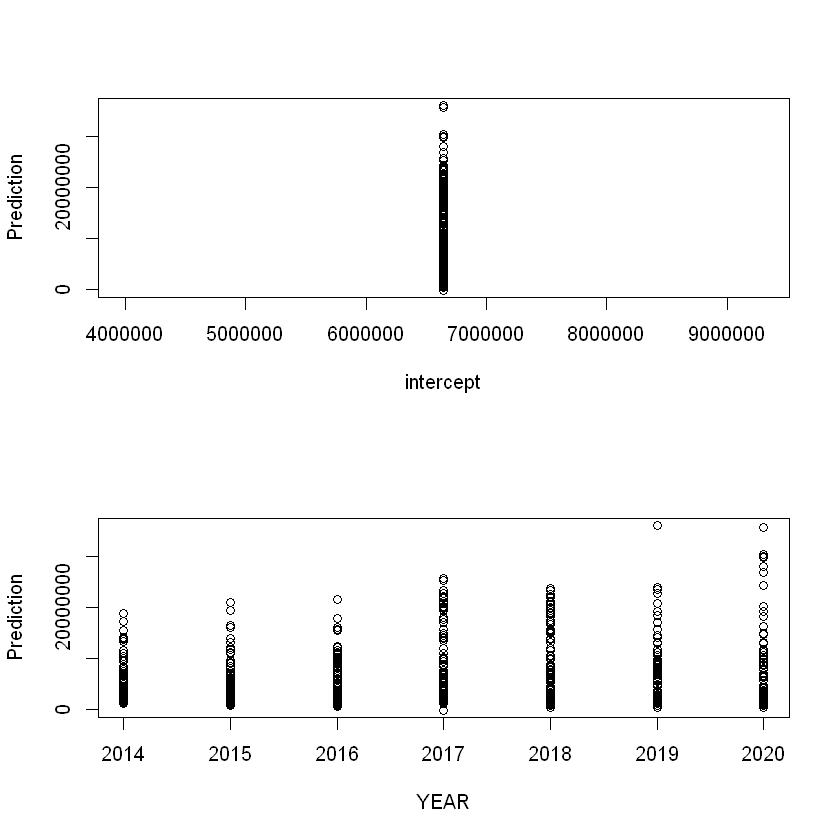

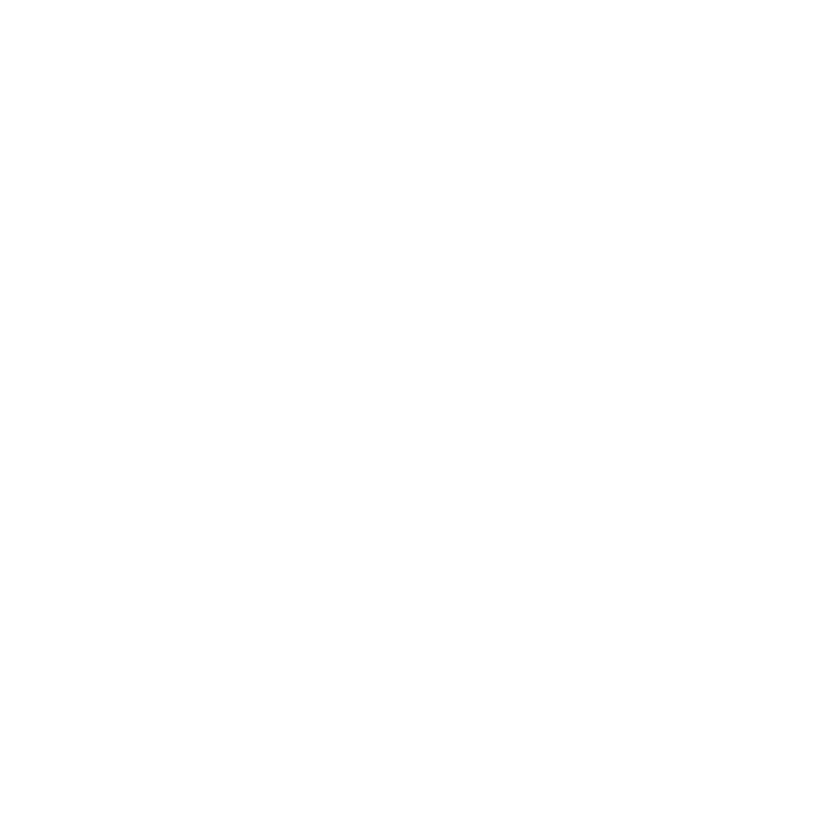

In [591]:
par(mfrow =c(2, 1))
for (c in names(res)) {
    plot(res$PREDICTION~res[[c]], xlab=c, ylab='Prediction')
}

# Feature Importance by Player - Top 10 Features

Warning message in xtfrm.data.frame(x):
"cannot xtfrm data frames"


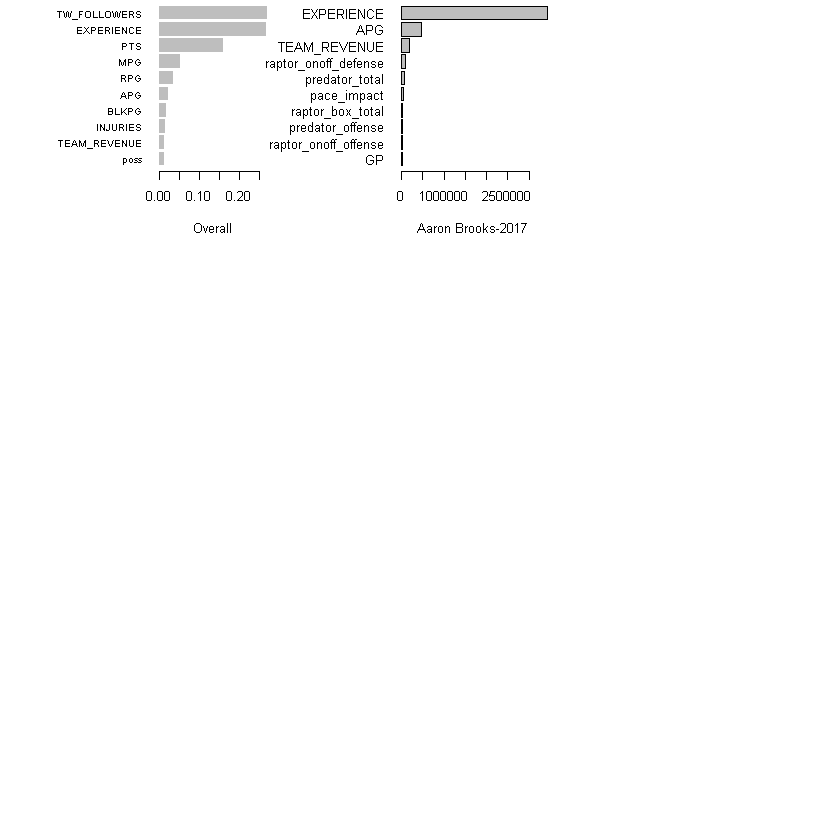

In [682]:
par(mfrow =c(3, 3), mai = c(0.9, 1, 0, 0.1))

fi = function(player, year) {
    df = res[res$PLAYER==player & res$YEAR==year,]
    data = subset(df, select=-c(TARGET, PREDICTION, quantile_rank, E, decile_rank, PLAYER, intercept))

    vals = sort(data) # sort(abs(data))
    
    barplot(tail(as.numeric(vals), 10), horiz=T, names.arg=tail(names(vals), 10), las=1, xlab=glue('{player}-{year}'))
}

xgb.plot.importance(importance_matrix[1:10], xlab='Overall')
fi('Aaron Brooks', 2017)


In [593]:
# write.csv(res, 'C:/Users/Lenovo/OneDrive/Documents/IU/Visualizations/final/viz_final/data/nba_salary_pred_xgb_explainer.csv')

# Partial Dependency Plots

In [594]:
model$params$objective = "reg:linear"
model$params$objective

[1] "reg:linear"

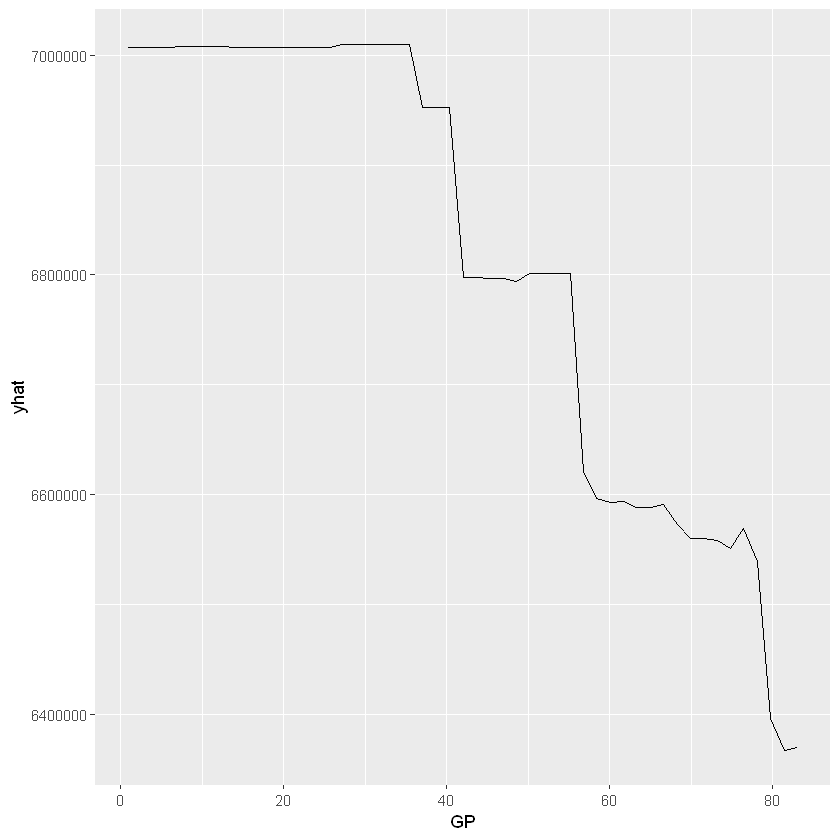

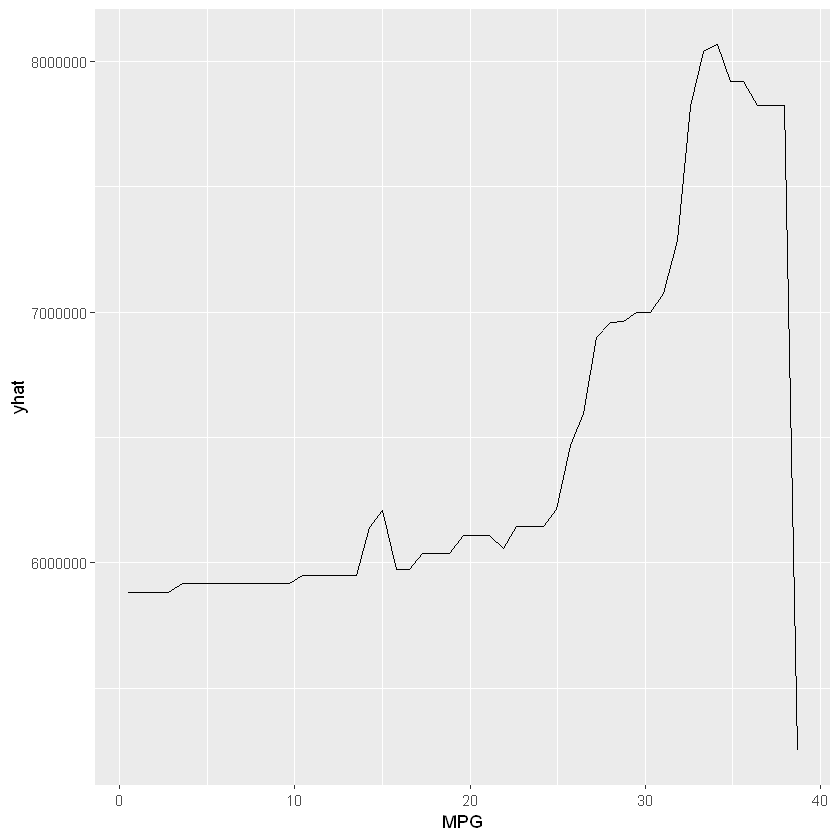

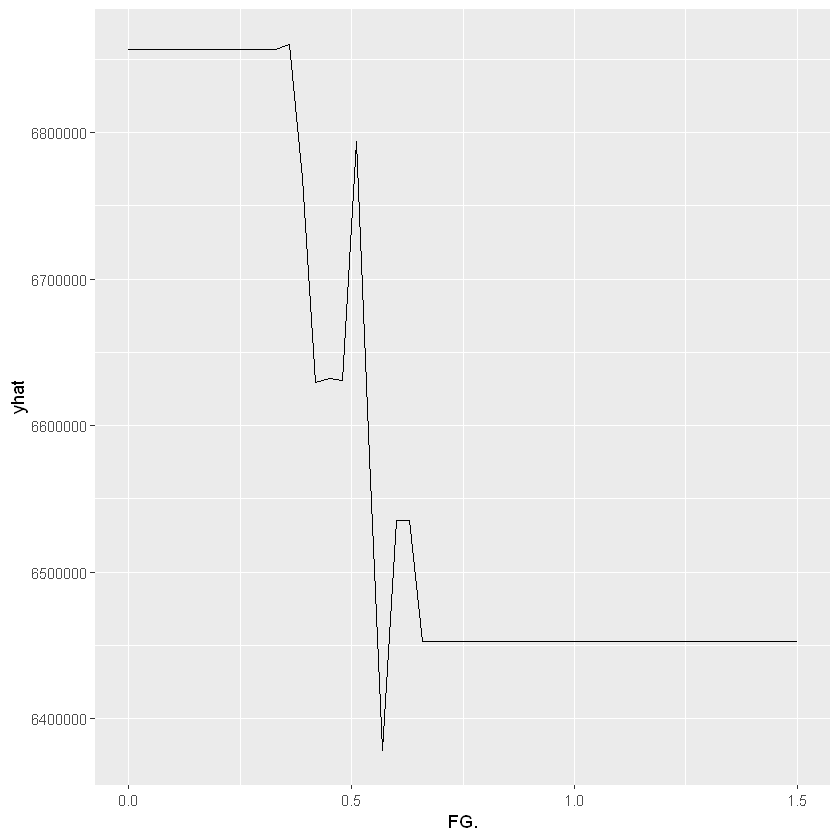

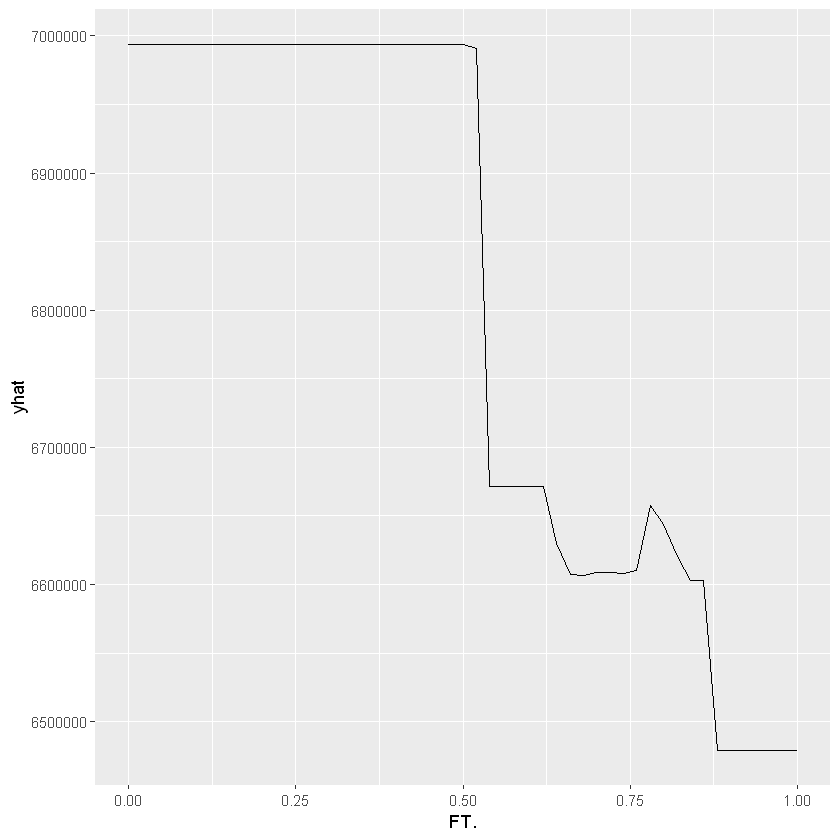

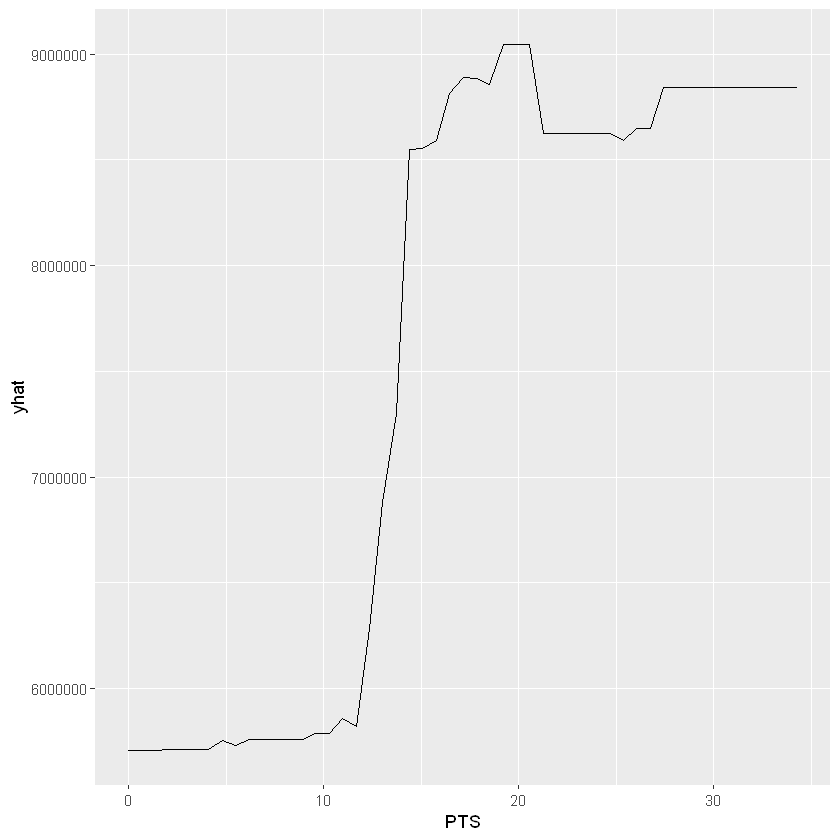

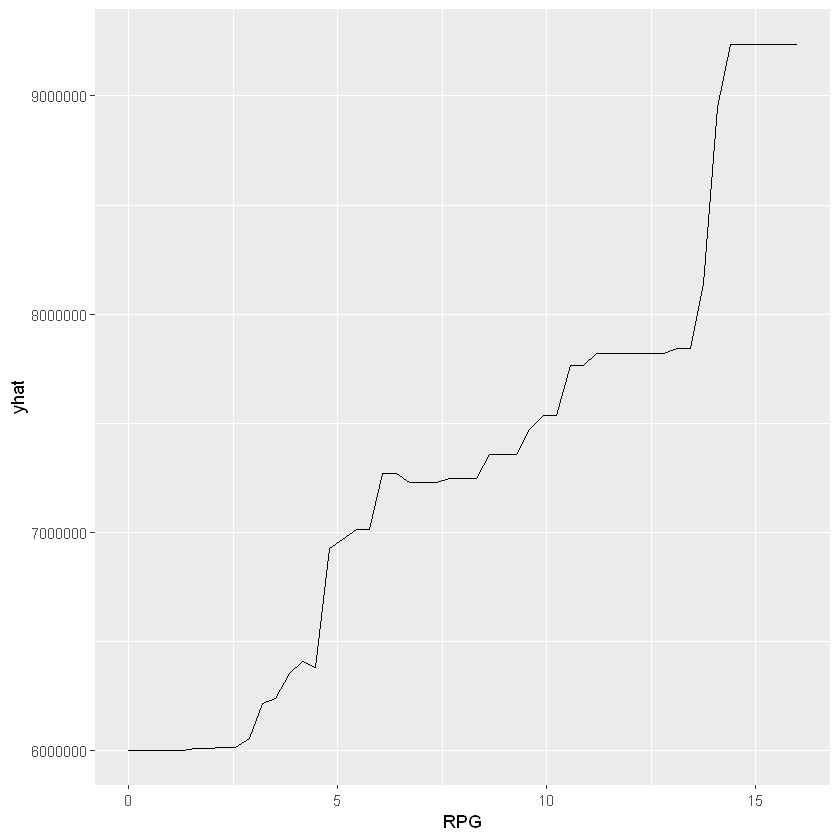

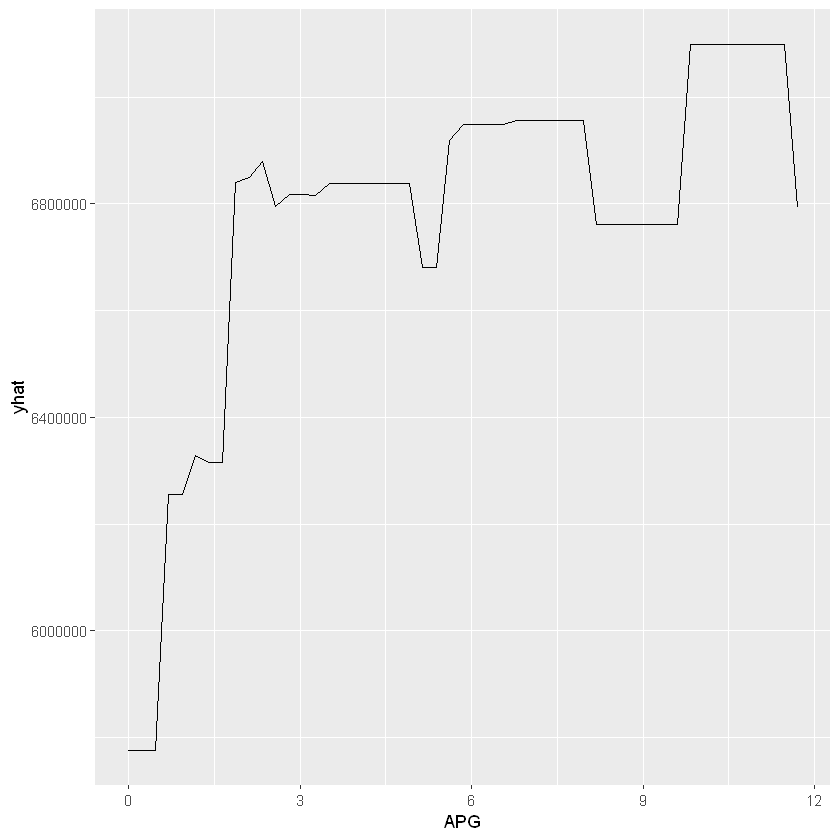

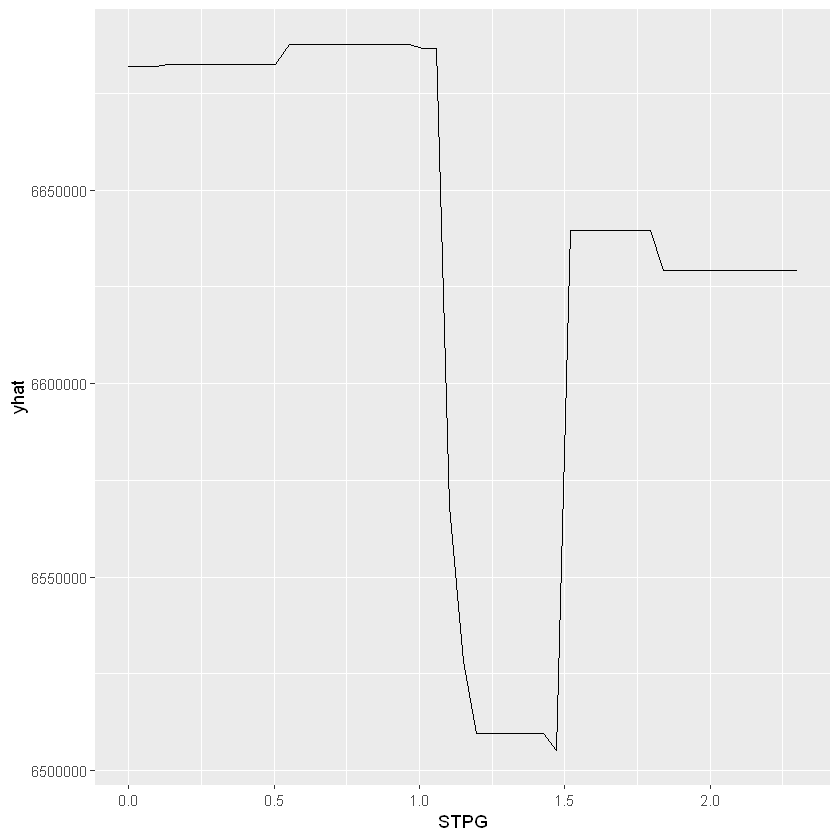

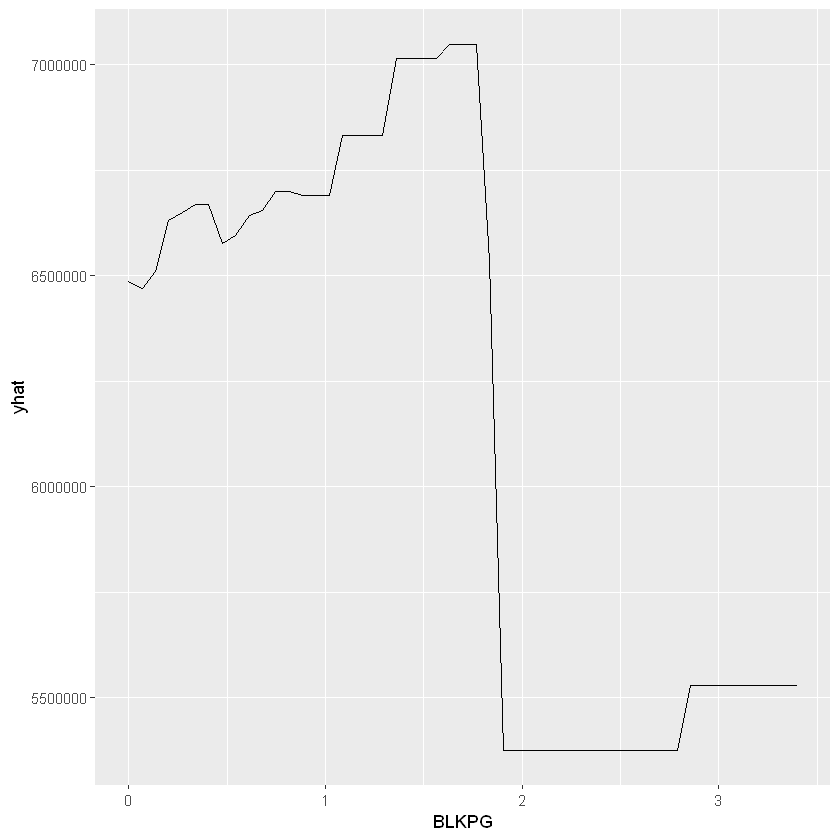

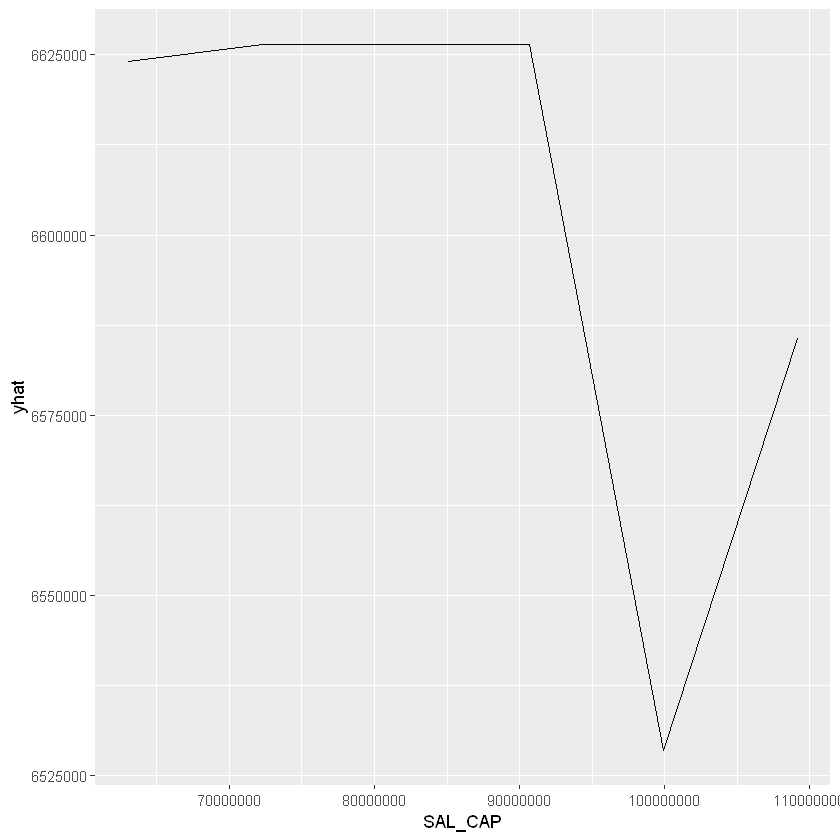

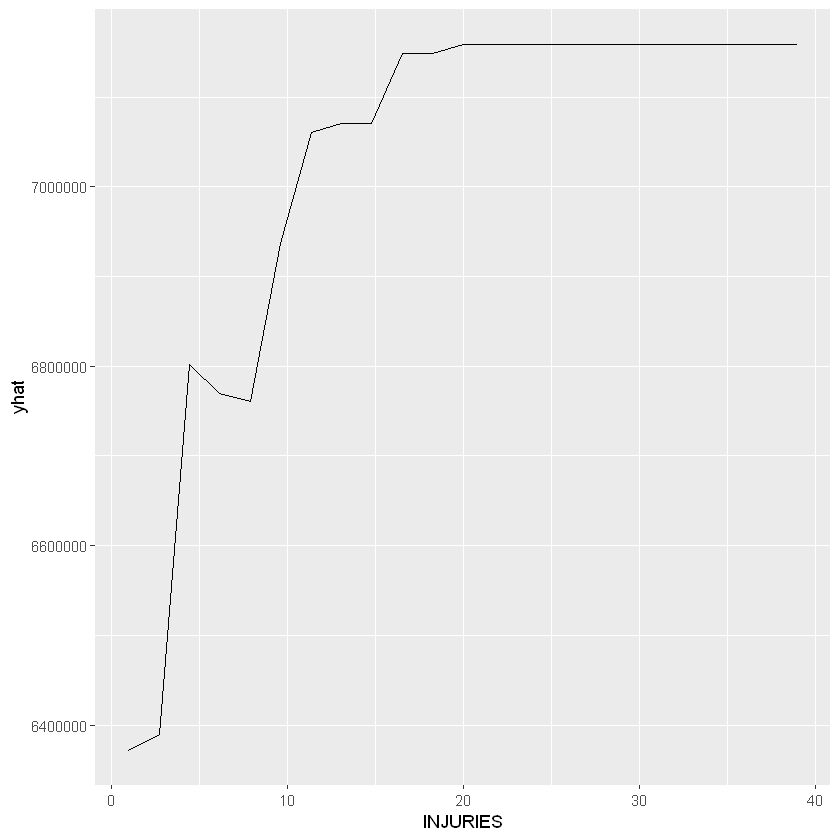

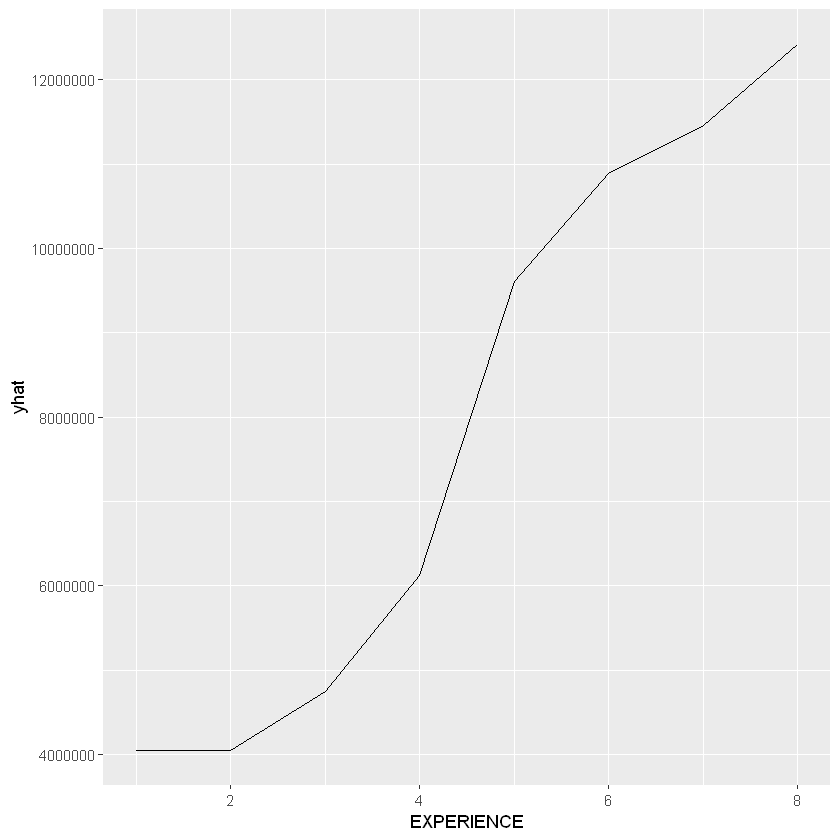

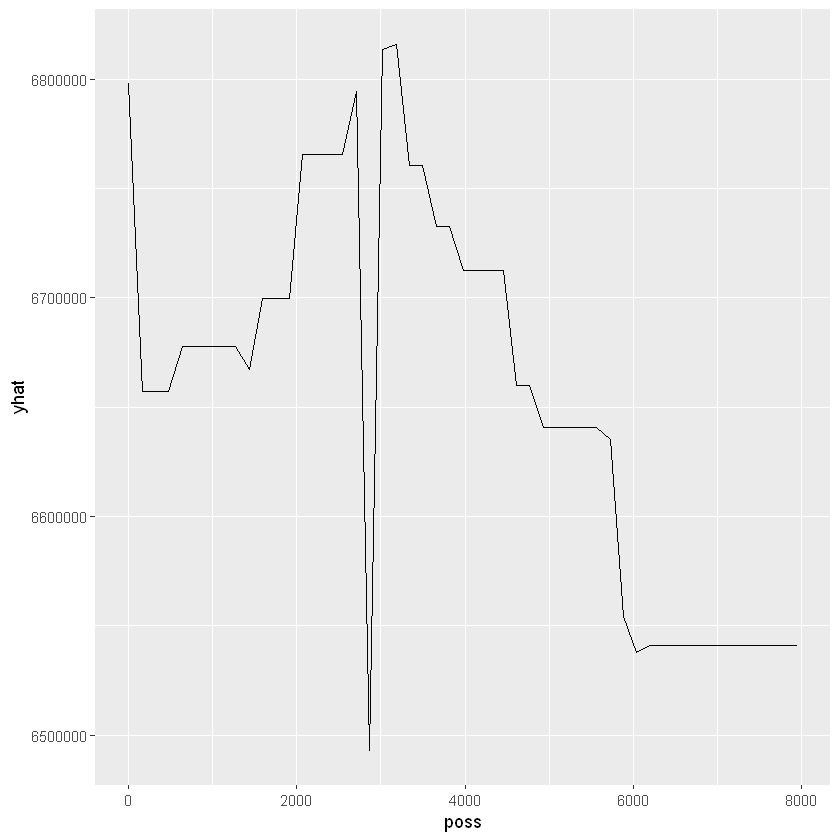

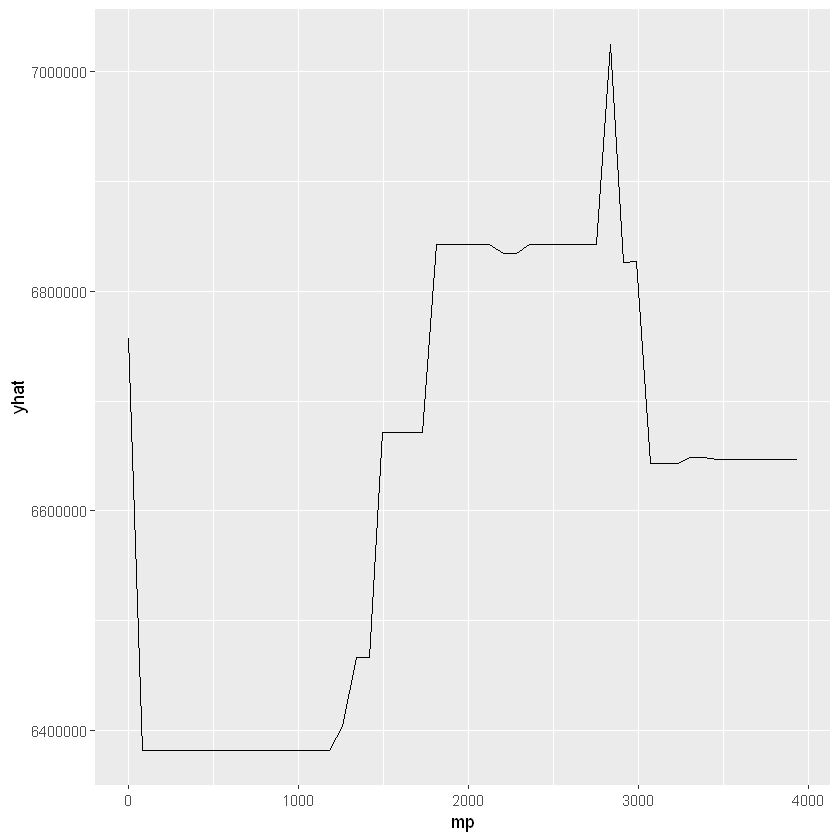

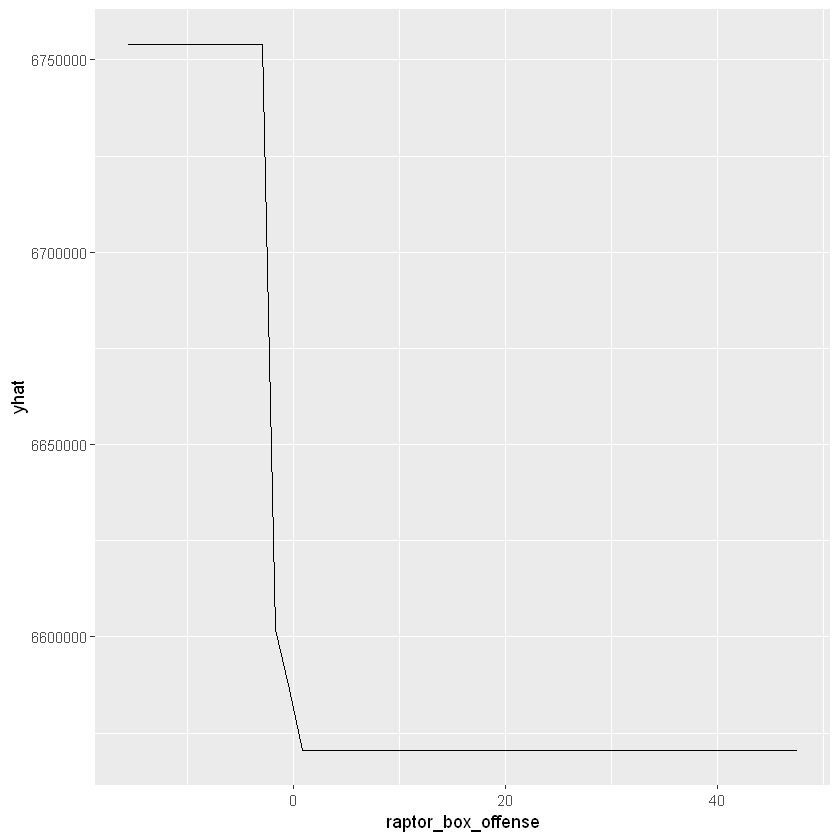

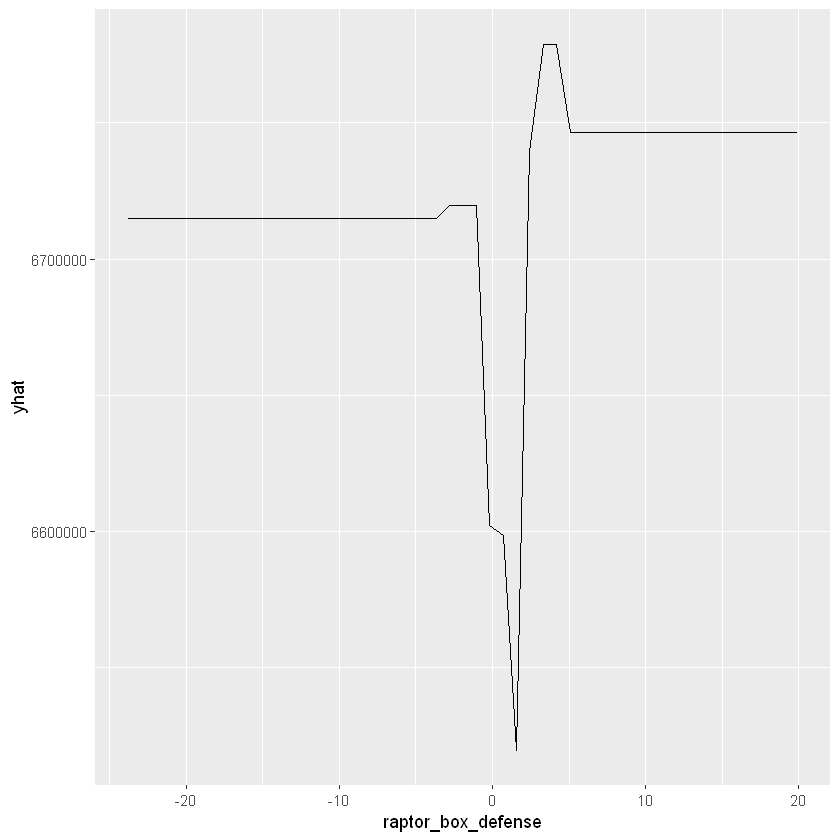

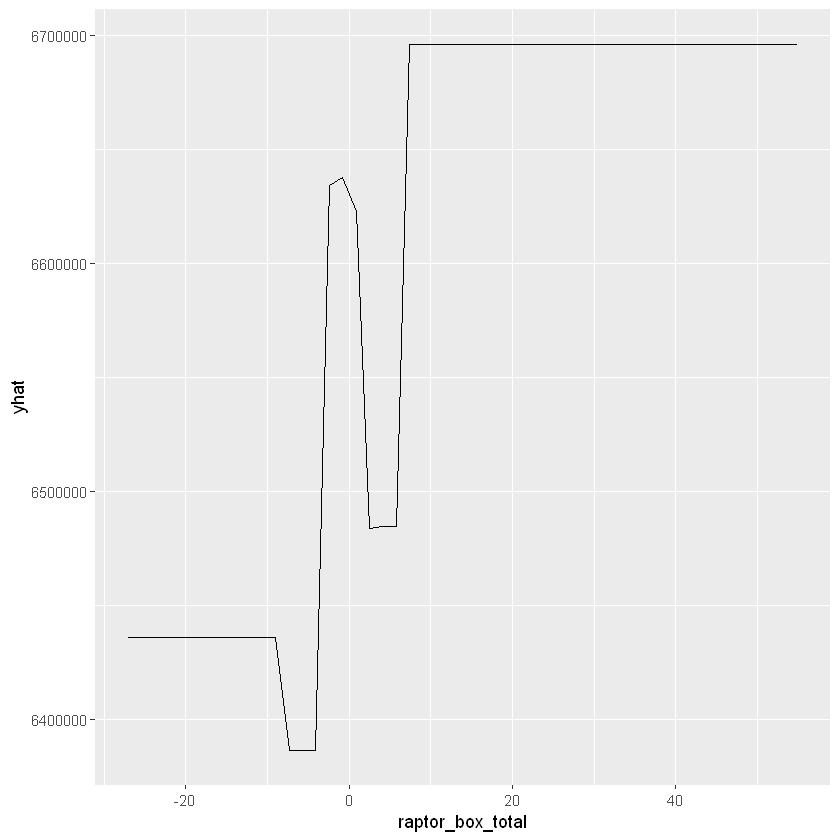

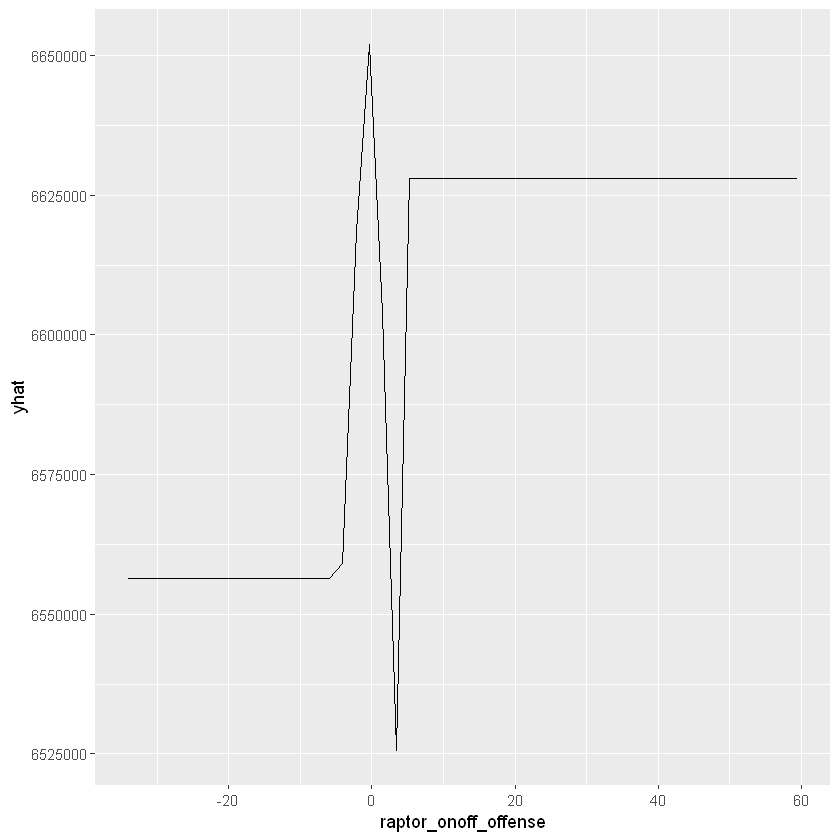

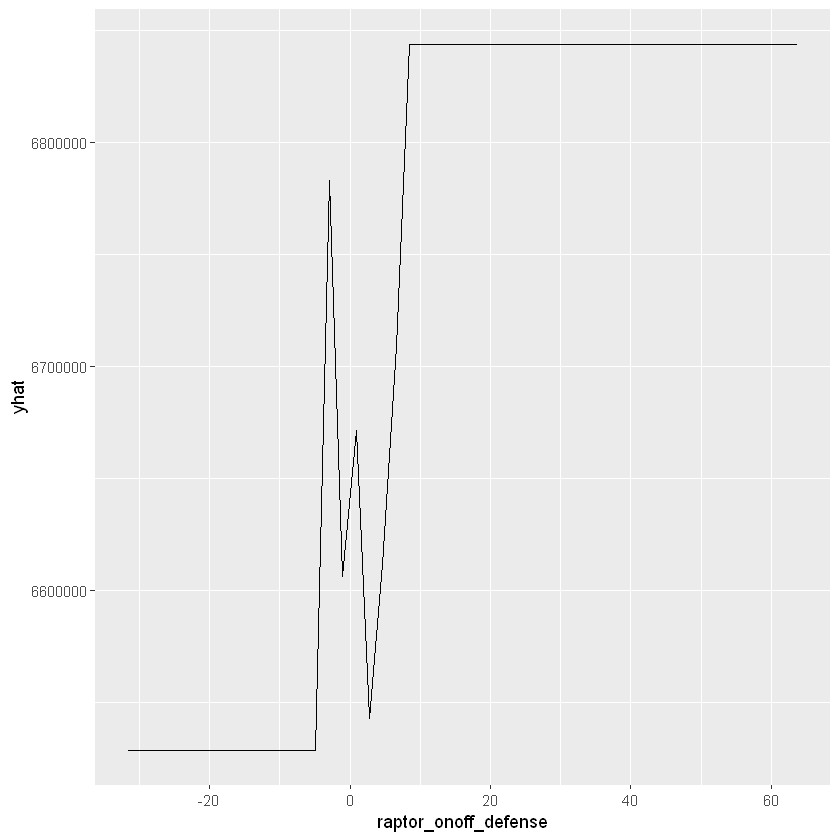

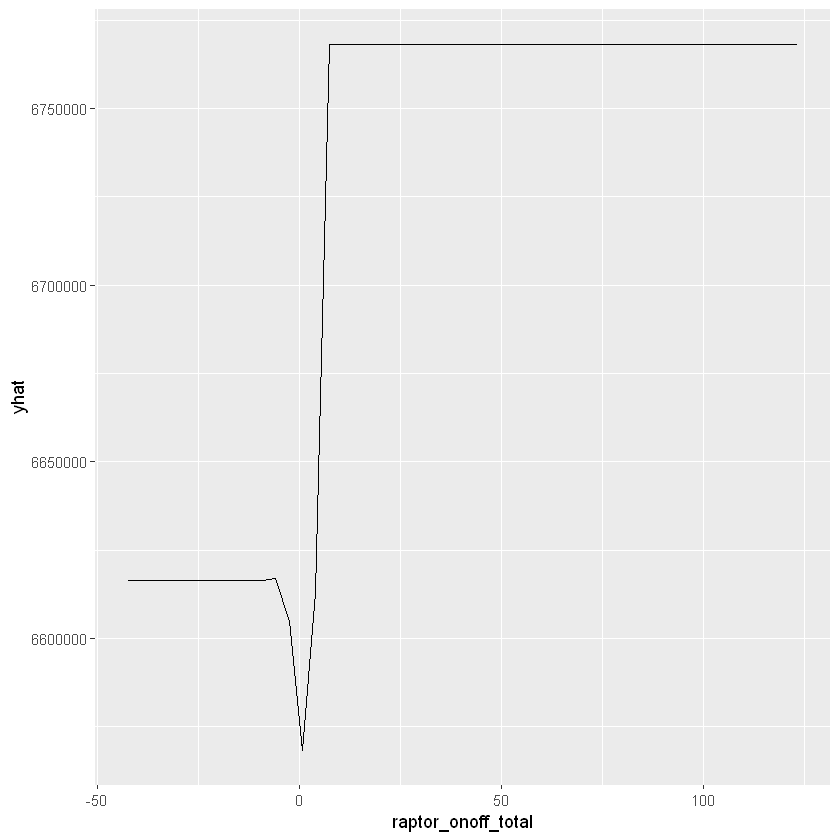

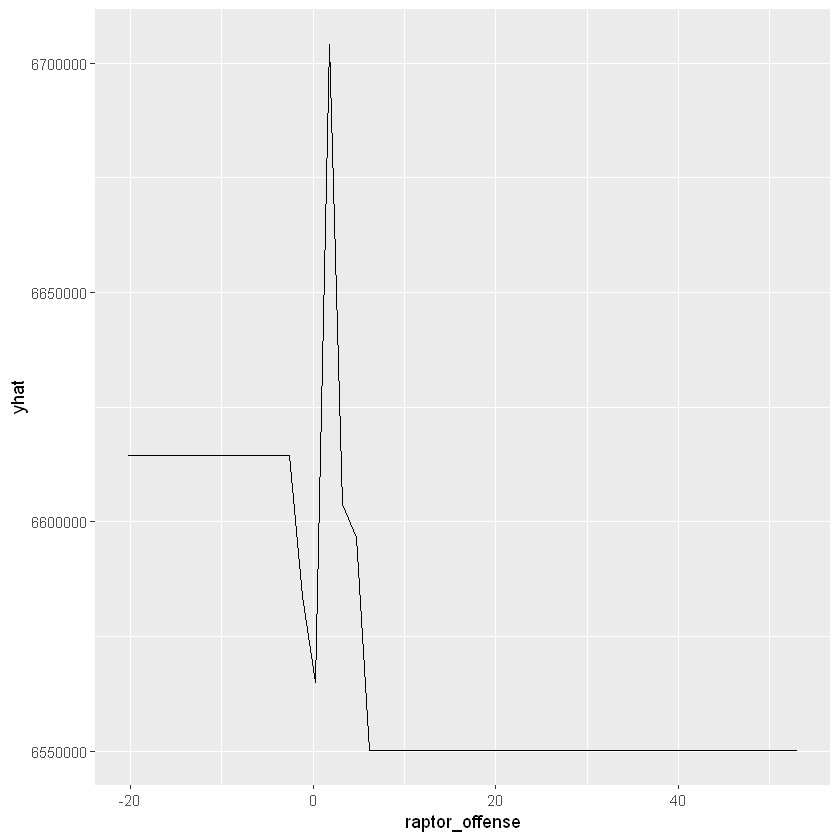

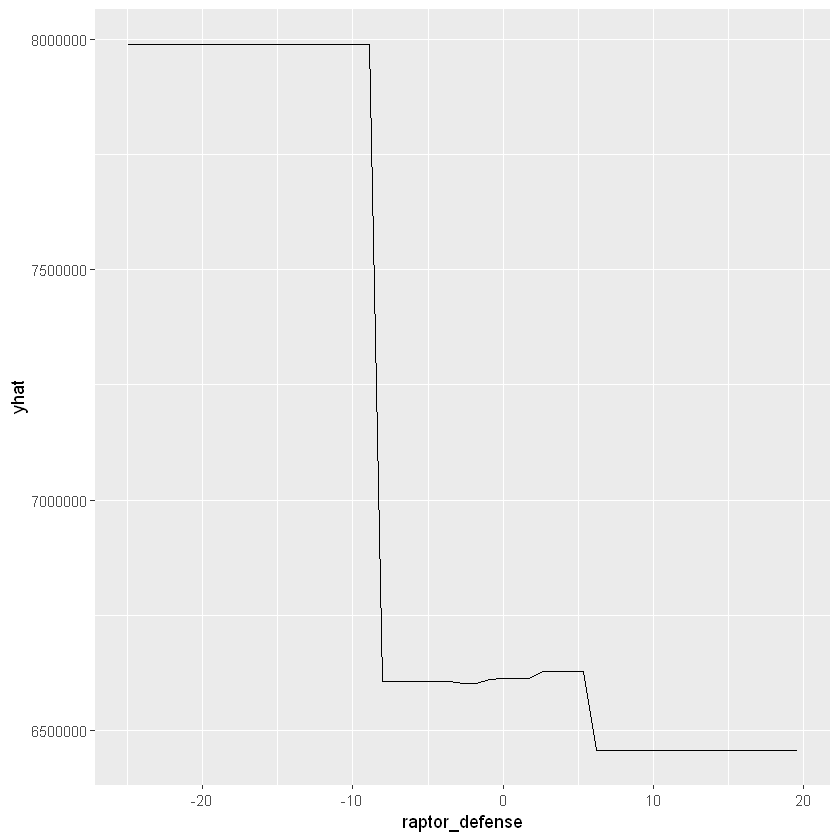

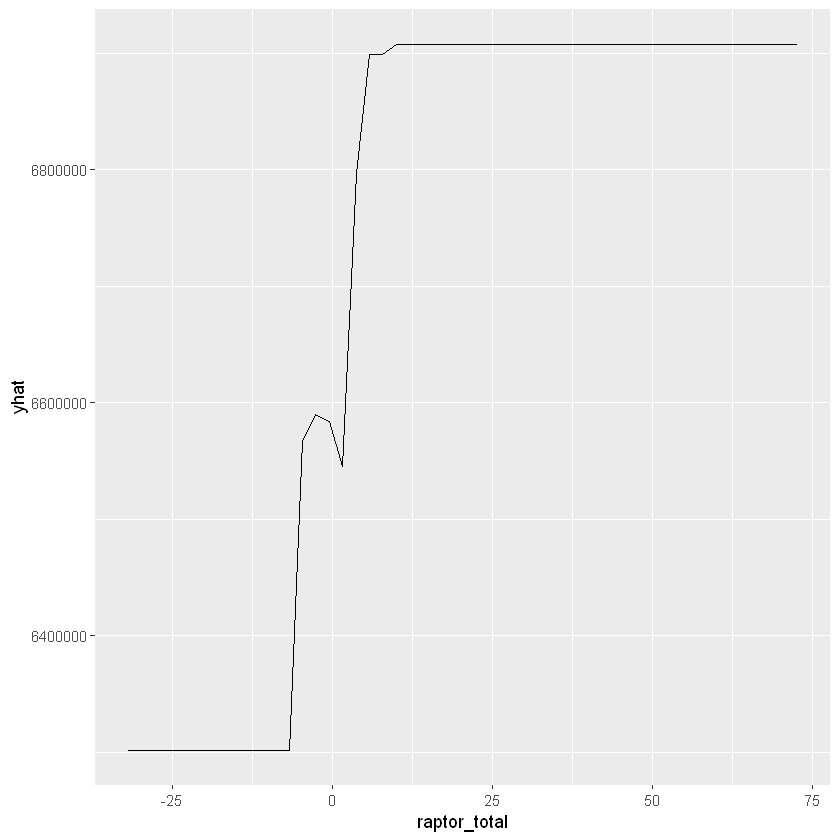

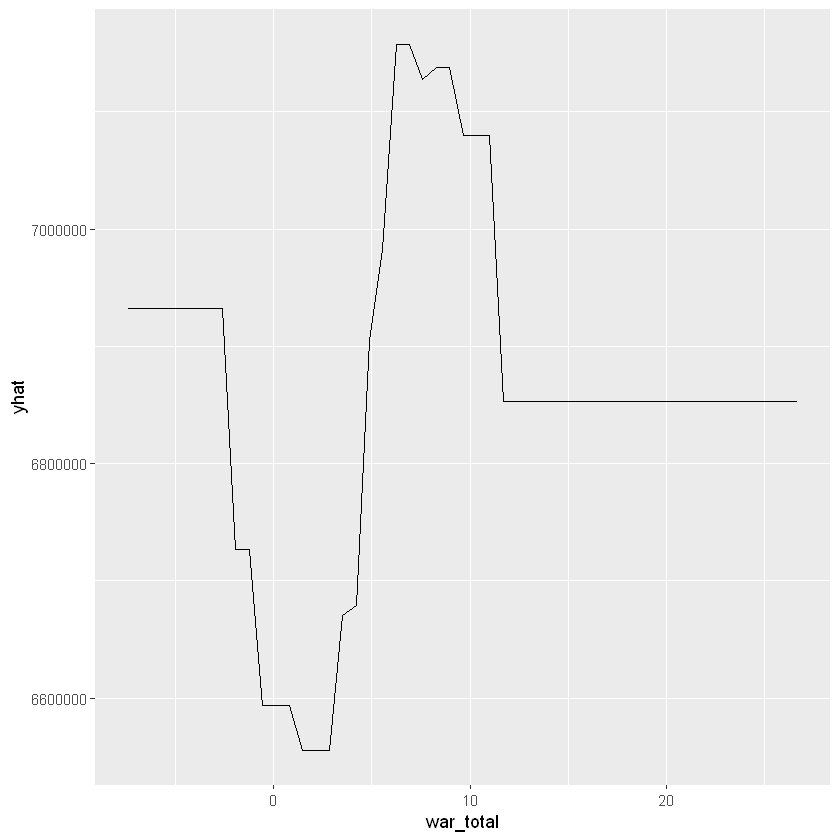

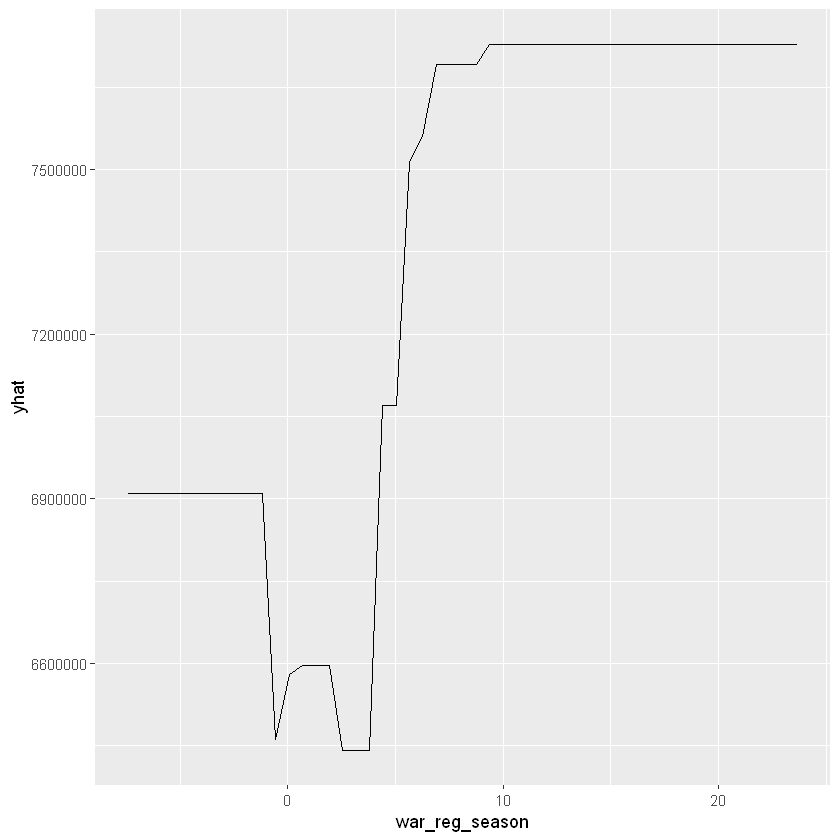

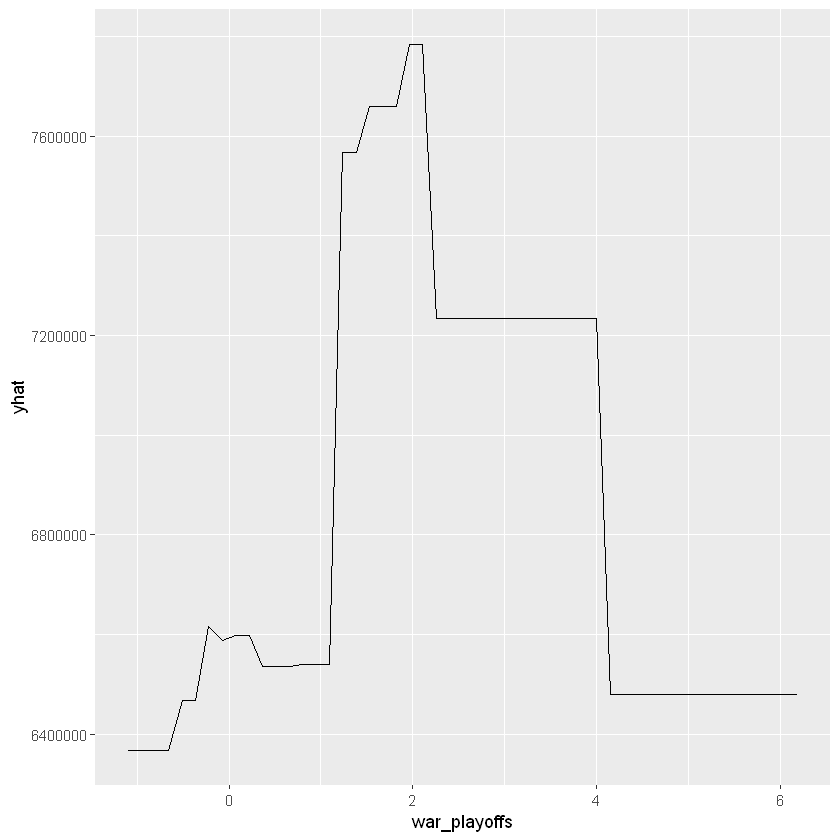

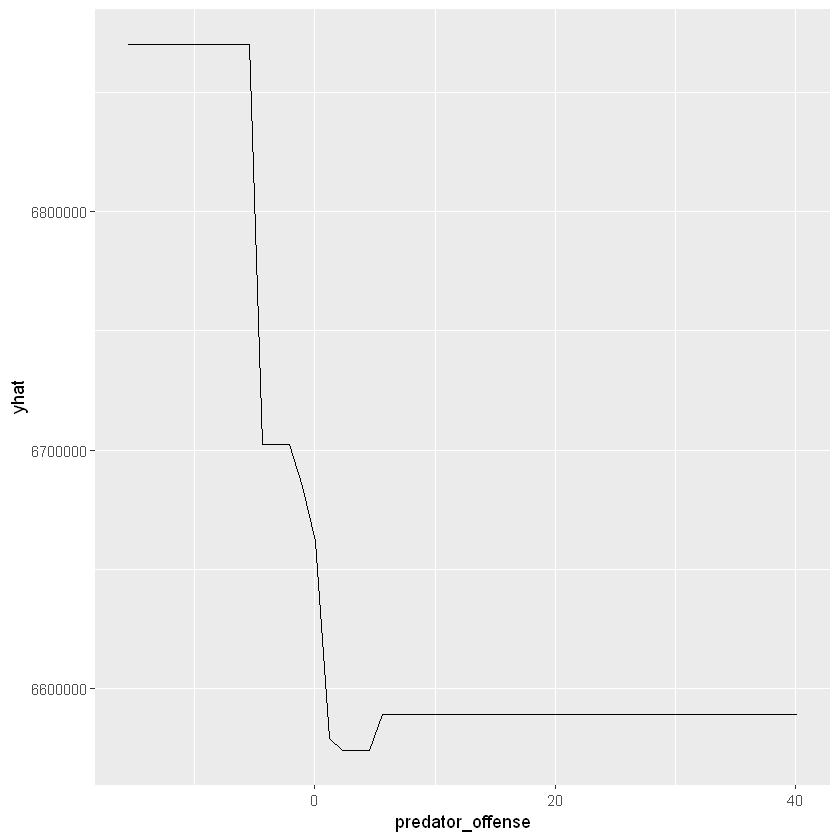

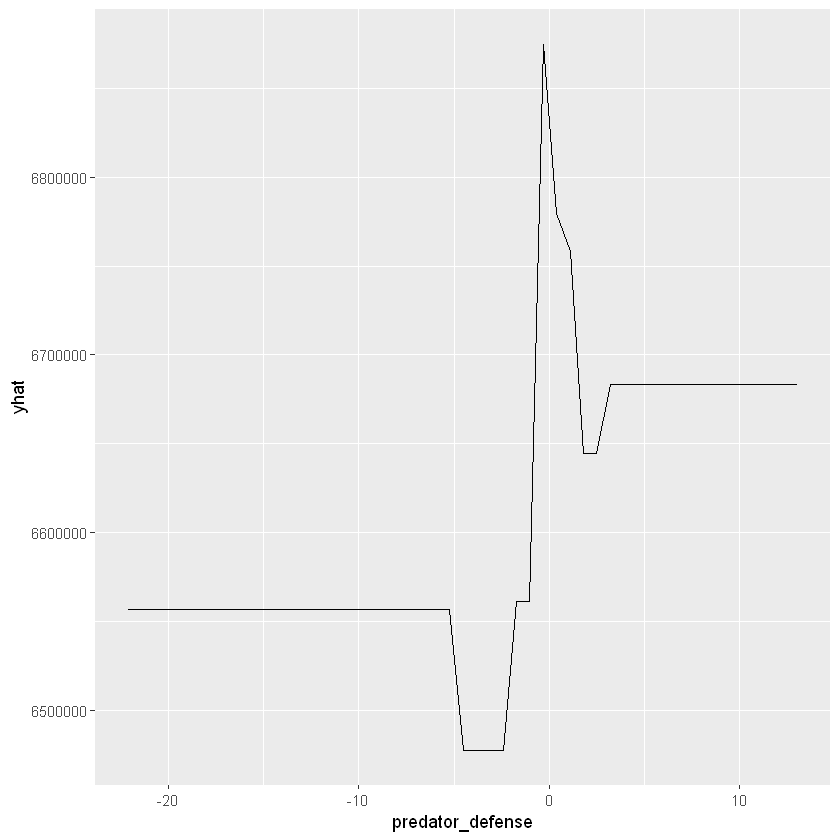

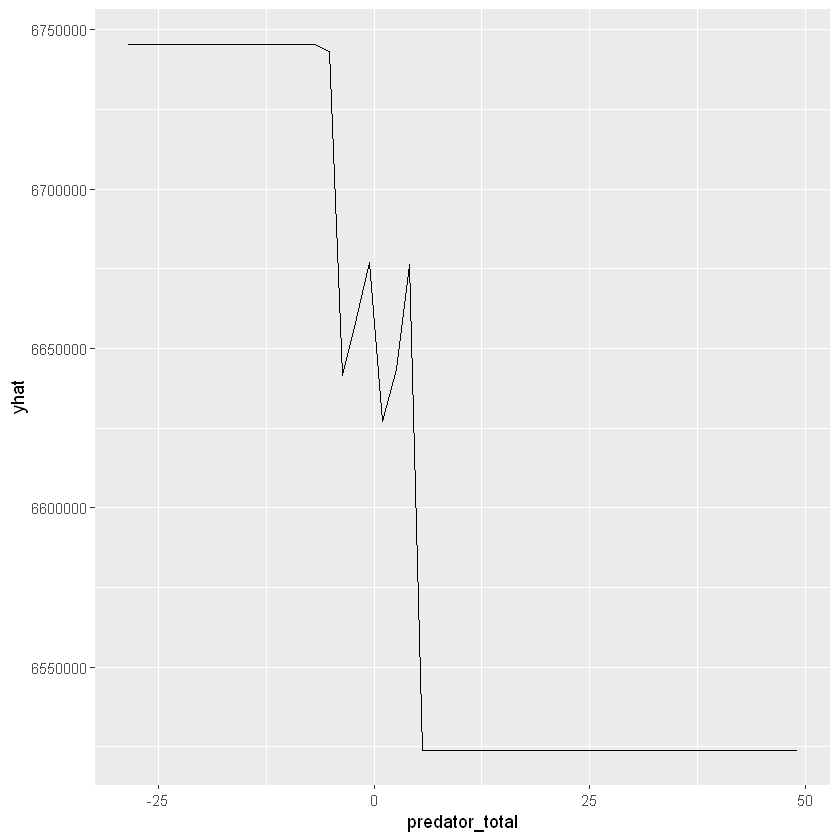

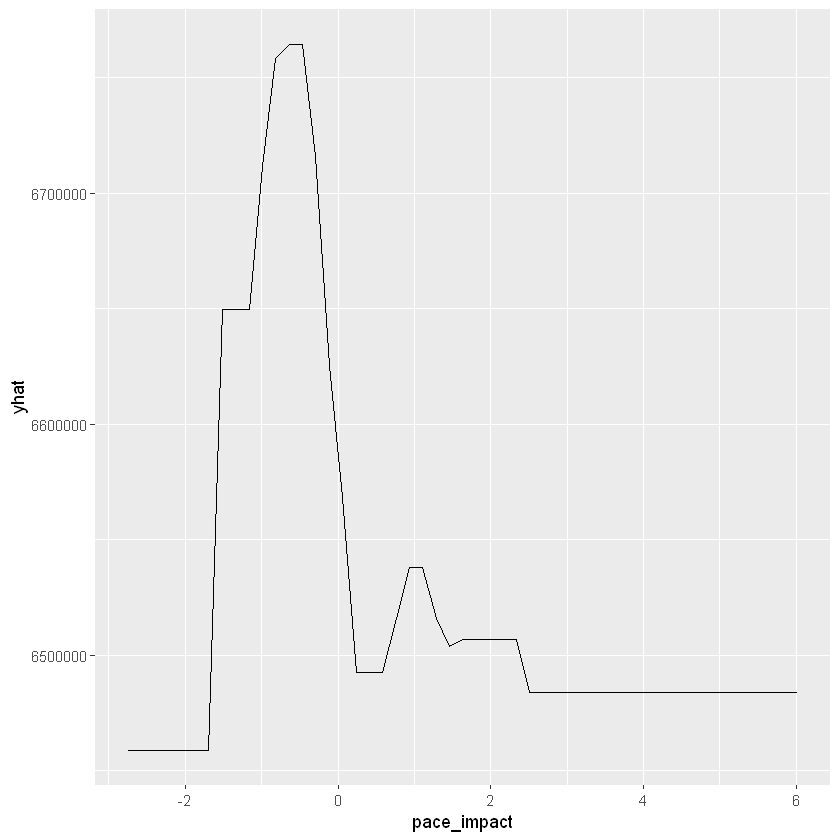

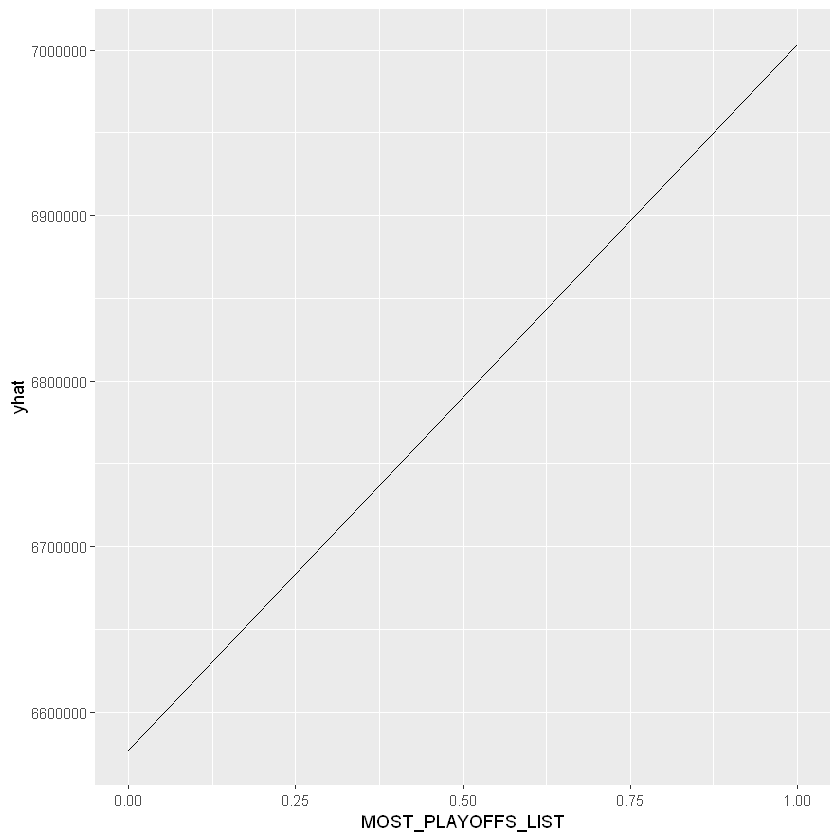

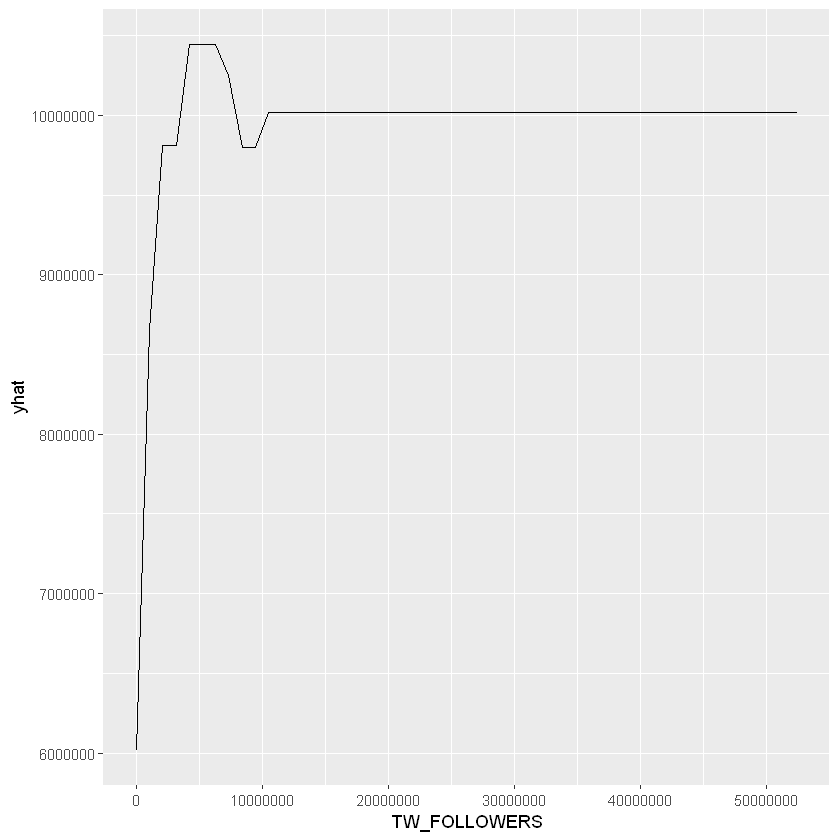

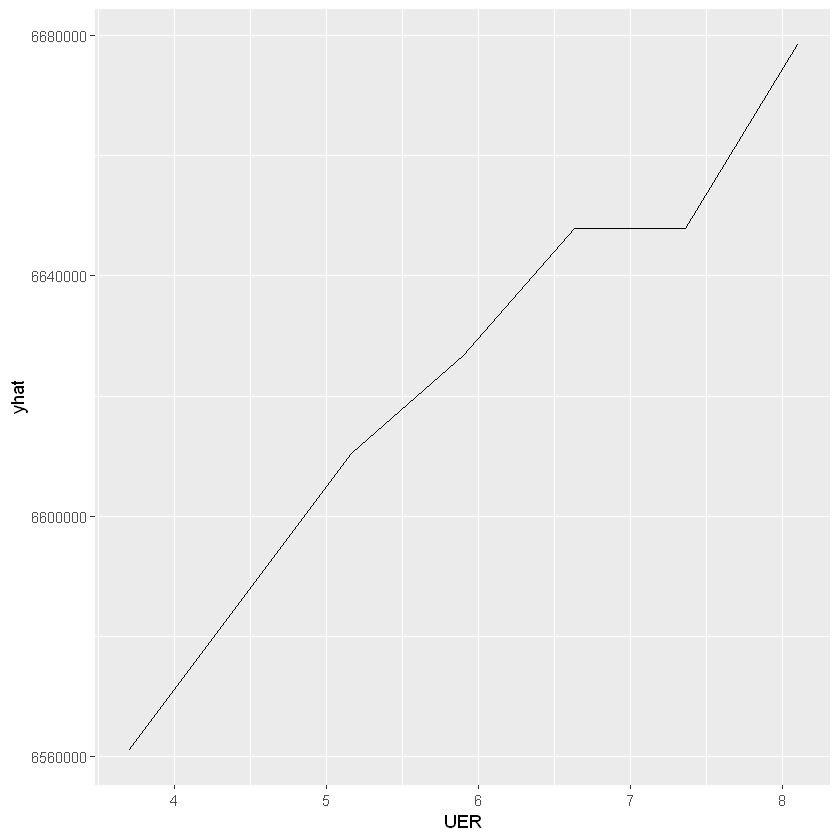

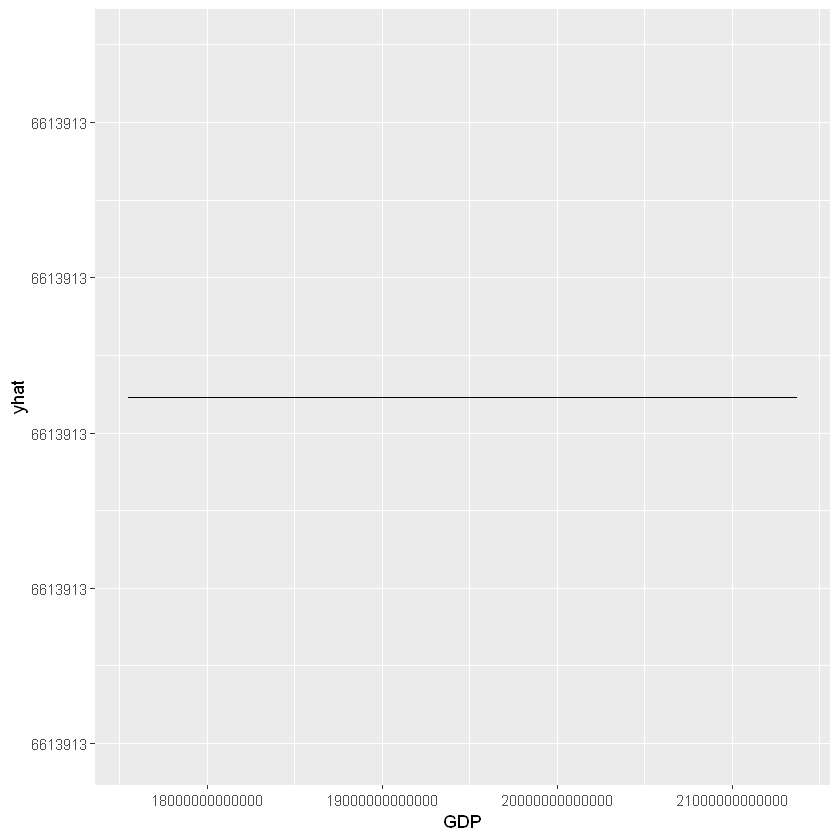

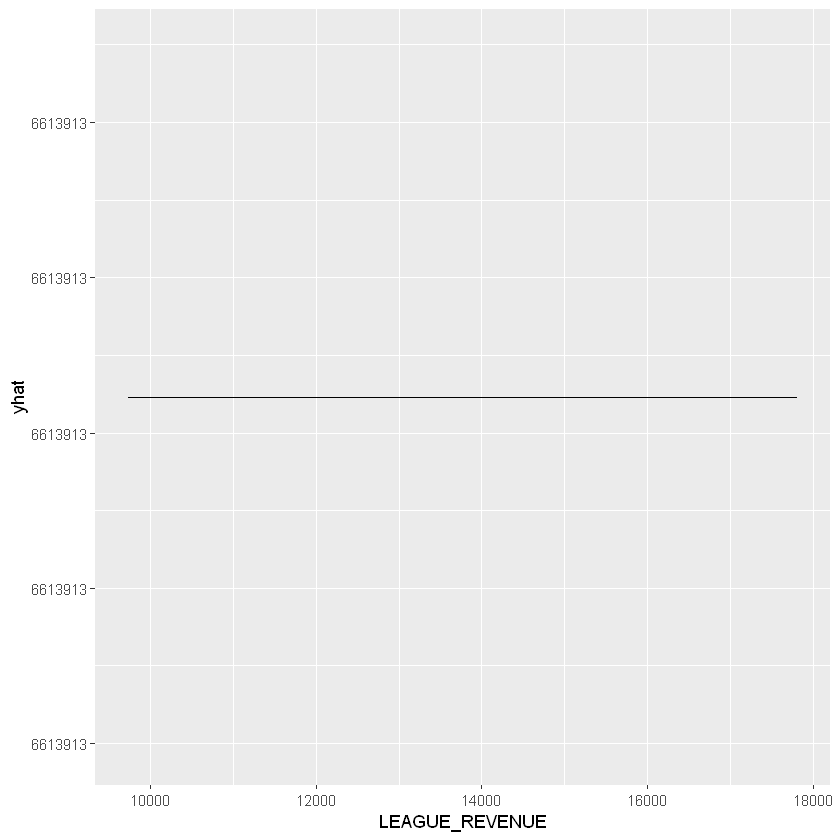

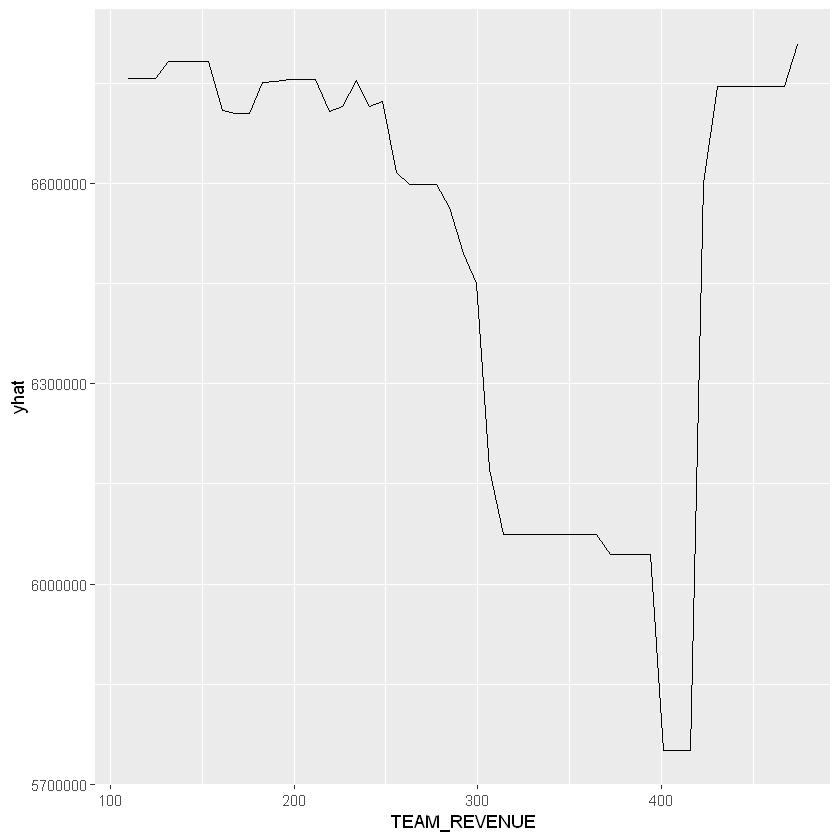

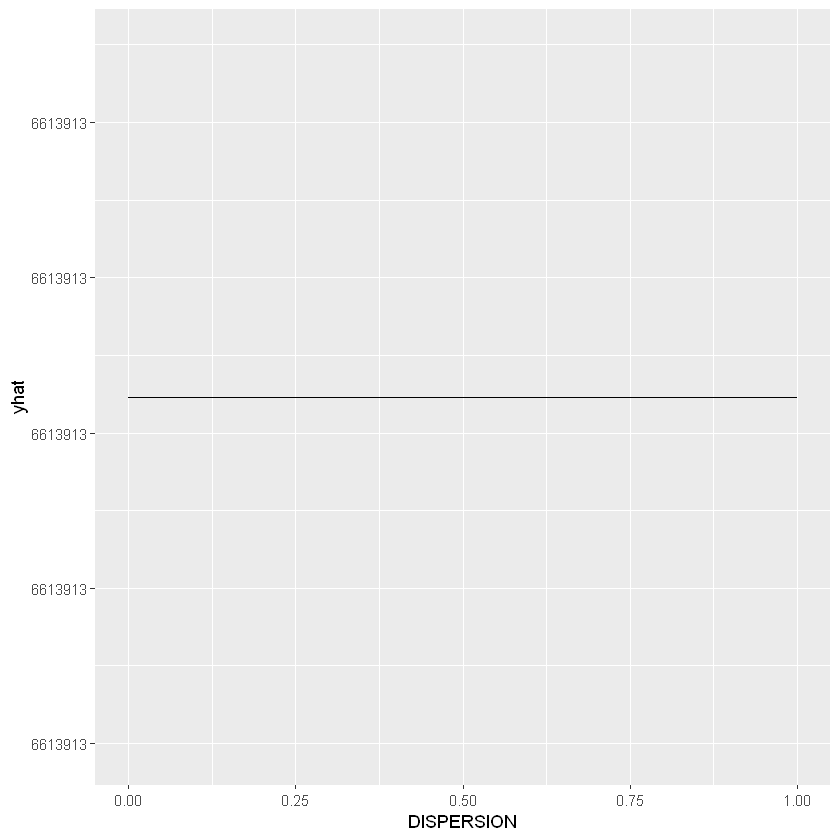

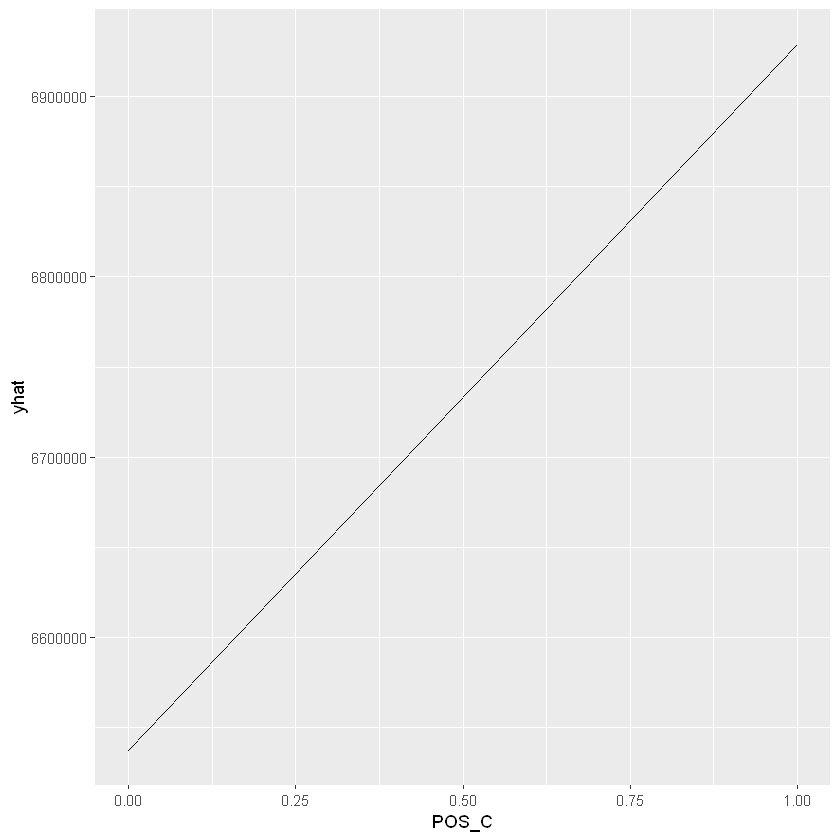

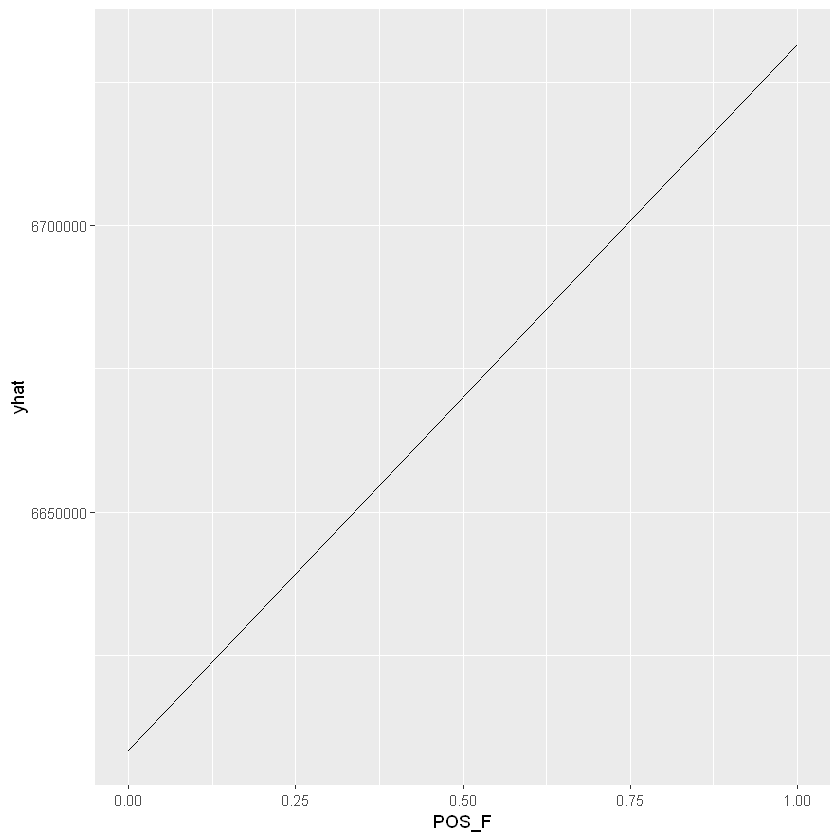

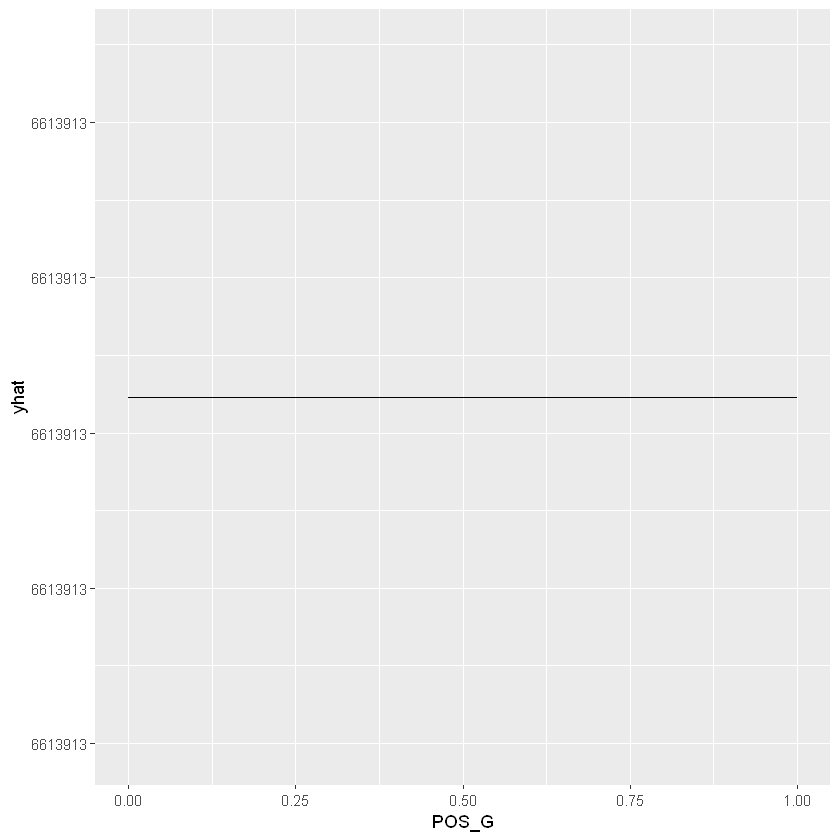

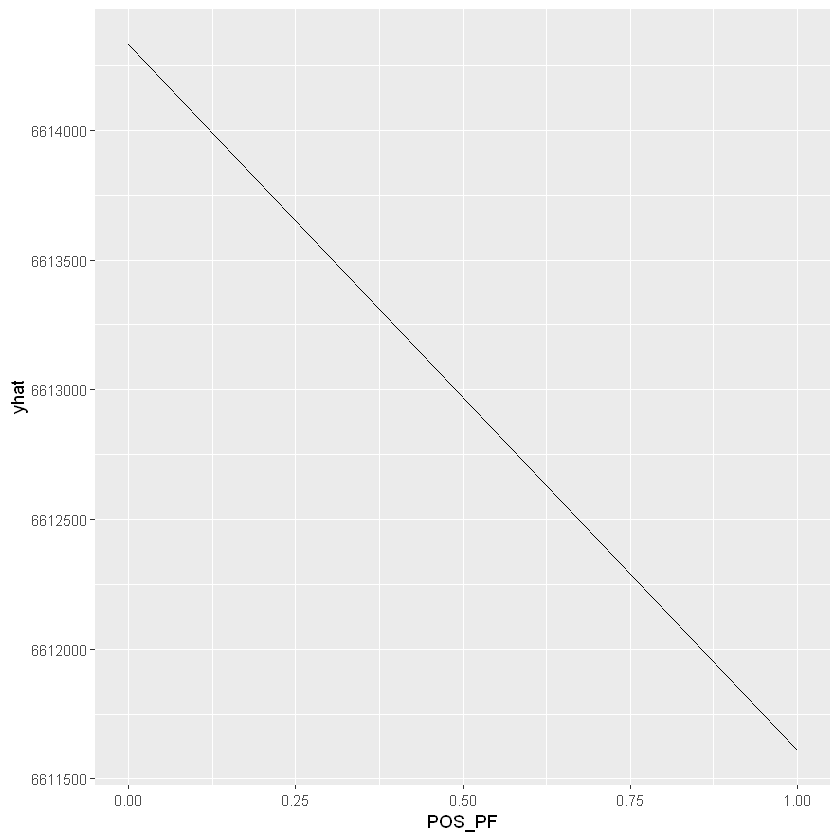

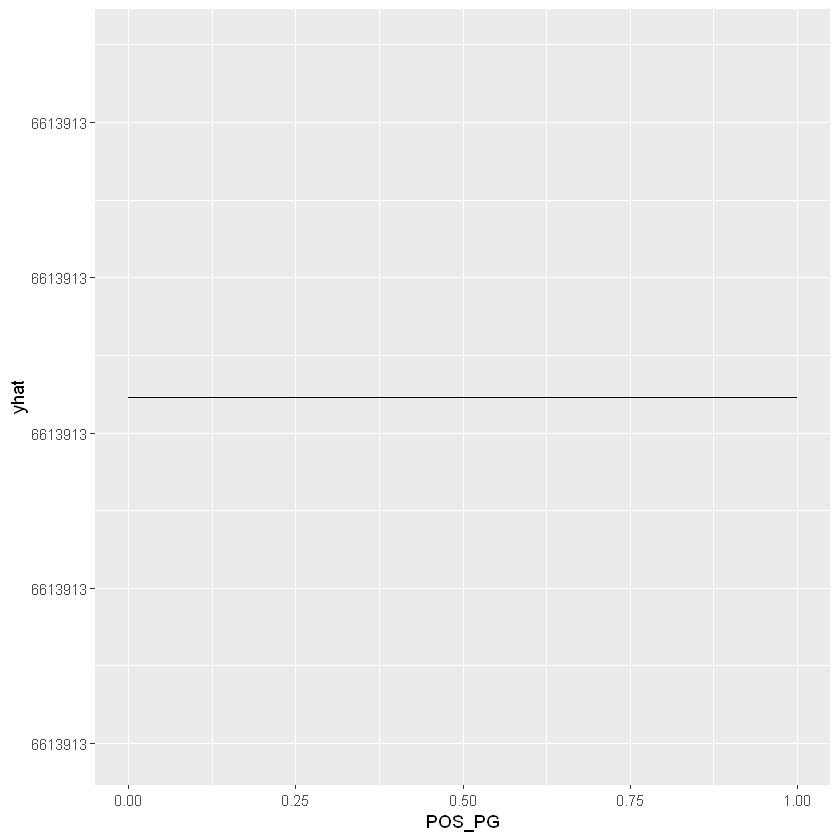

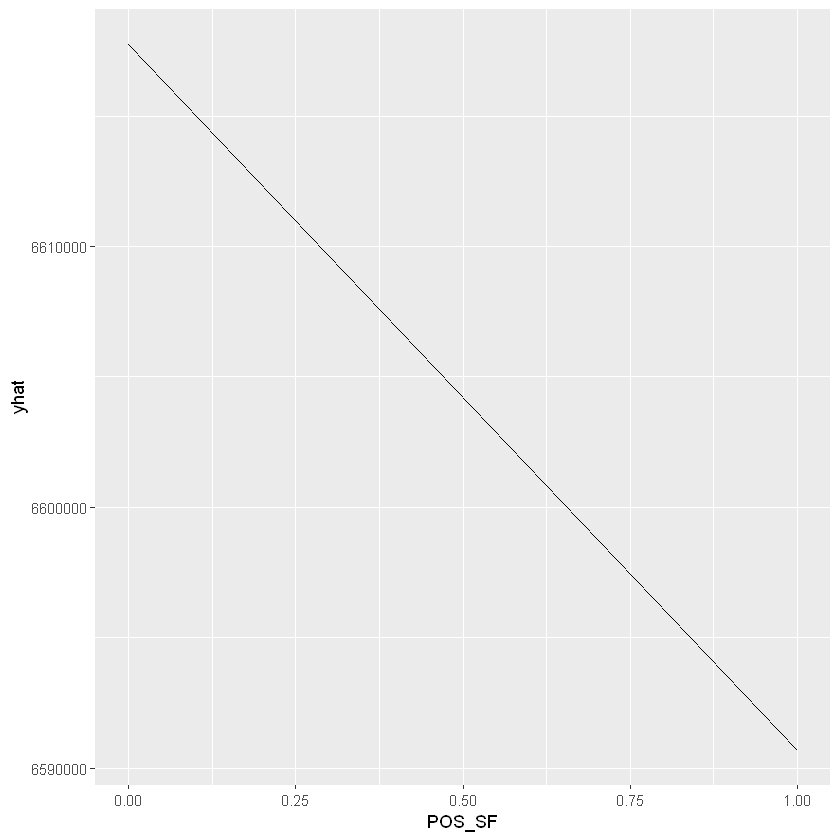

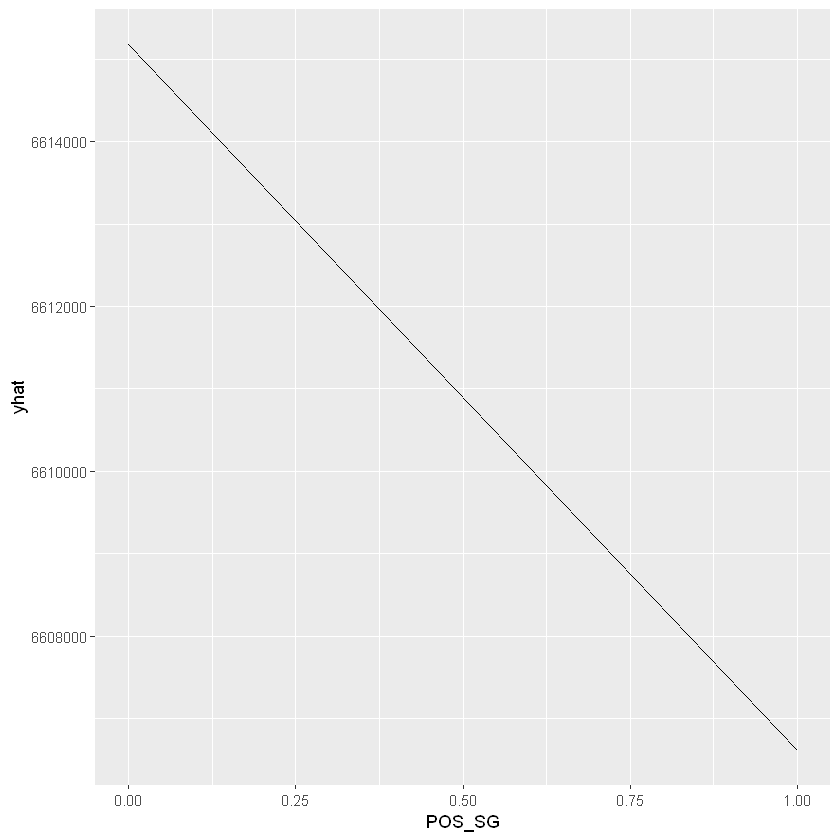

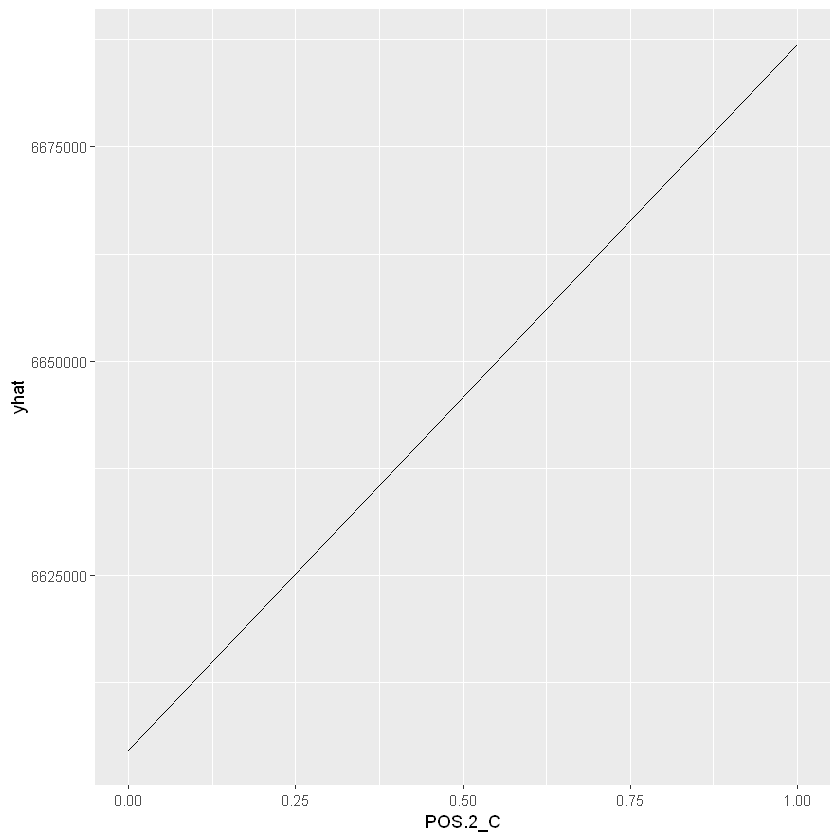

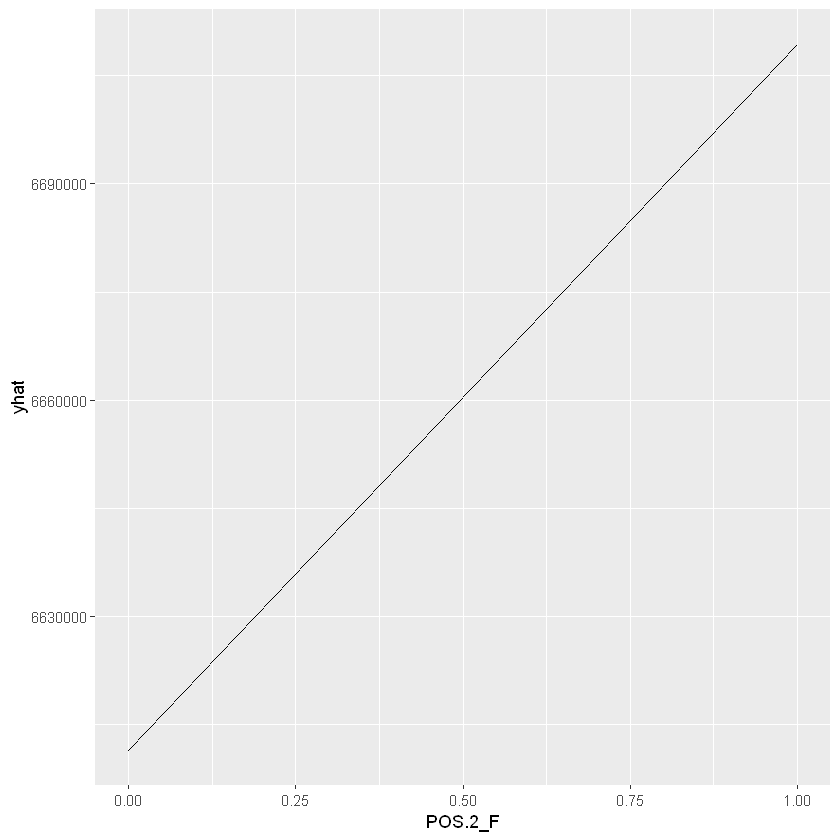

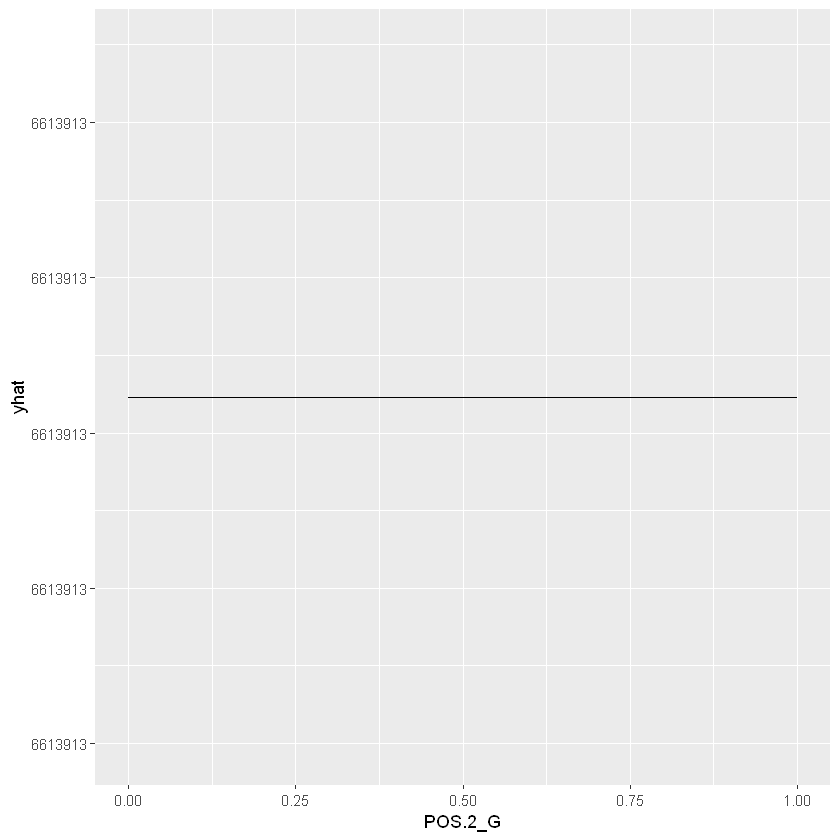

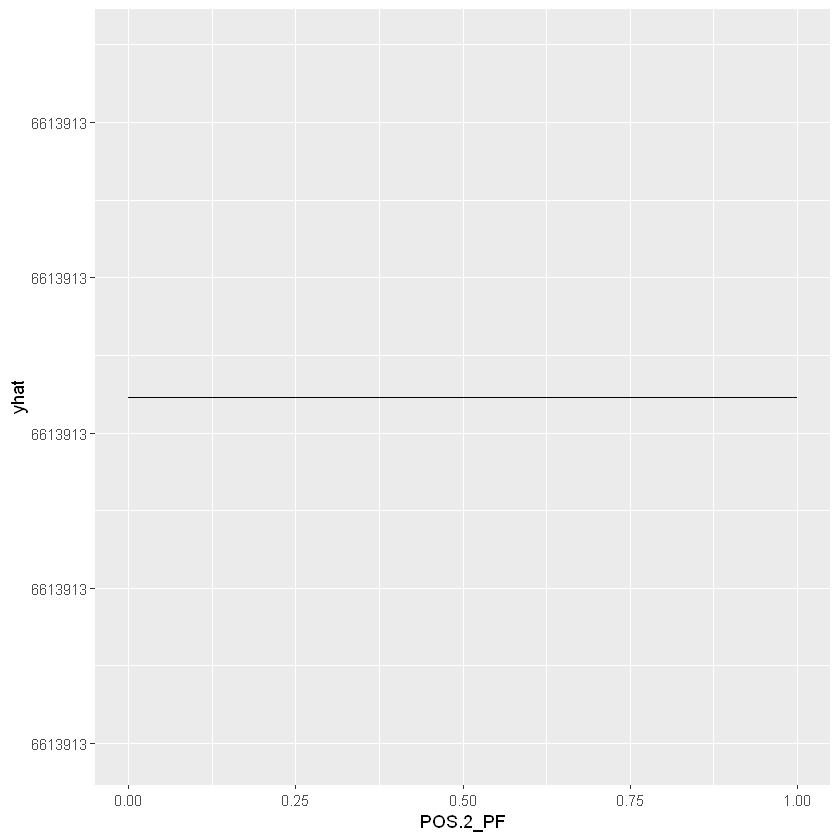

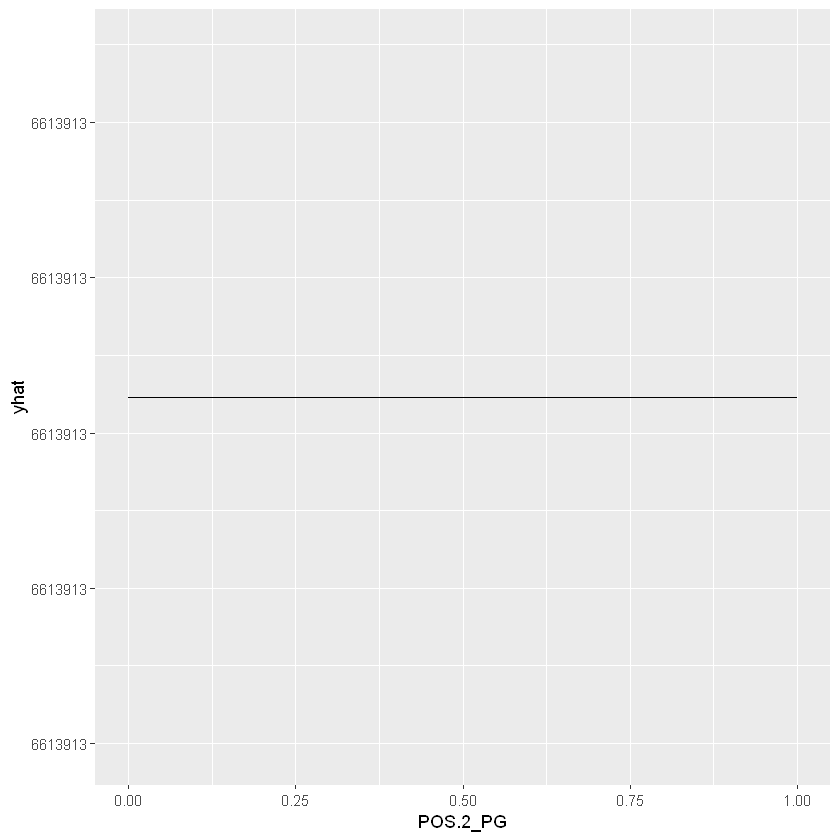

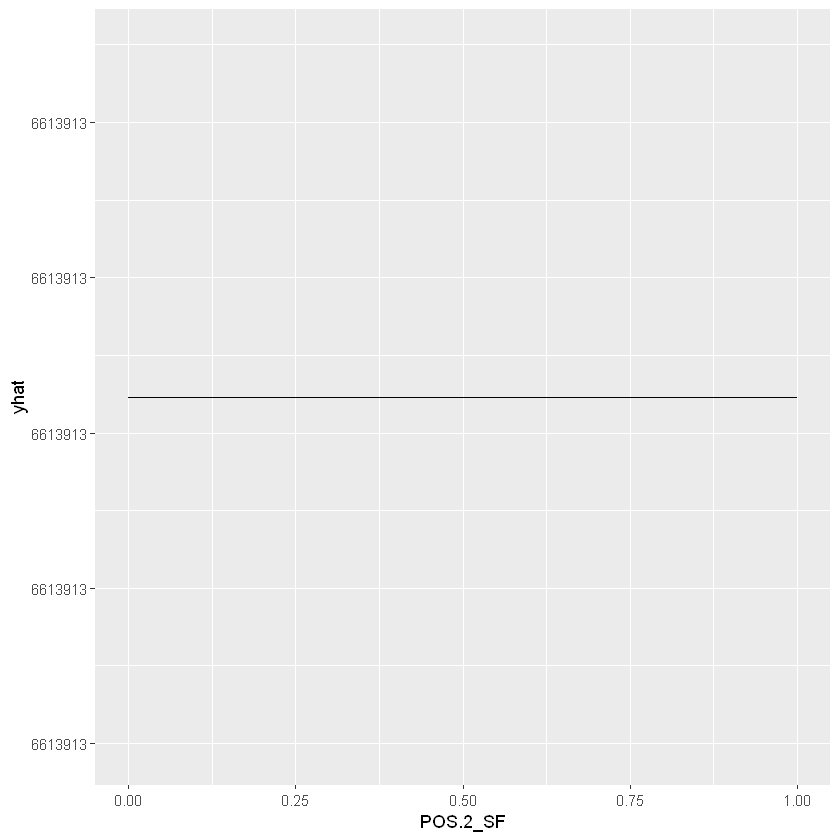

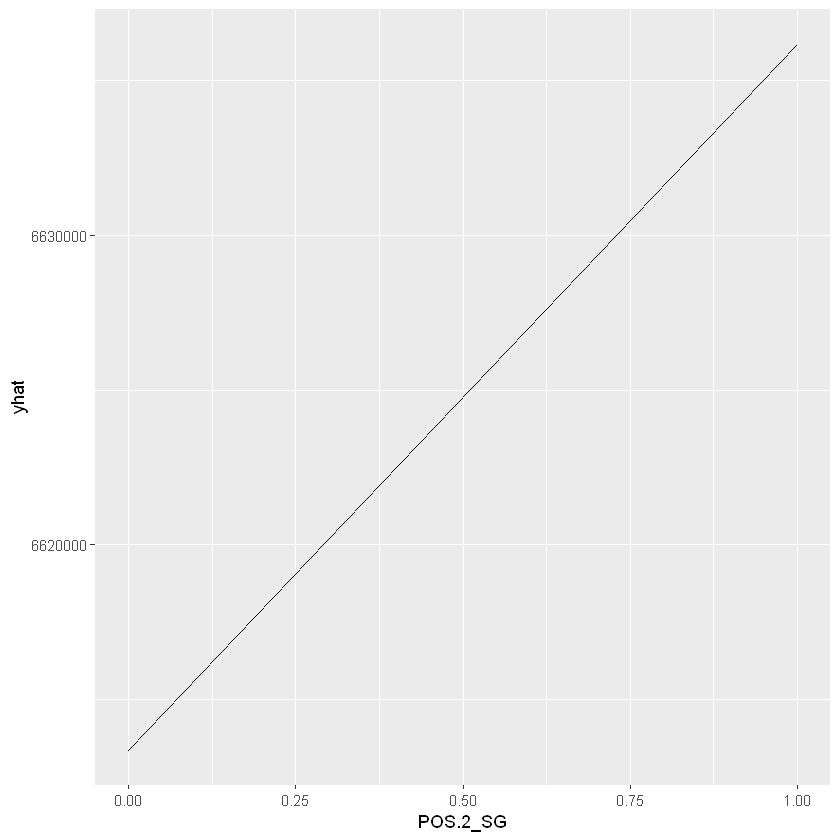

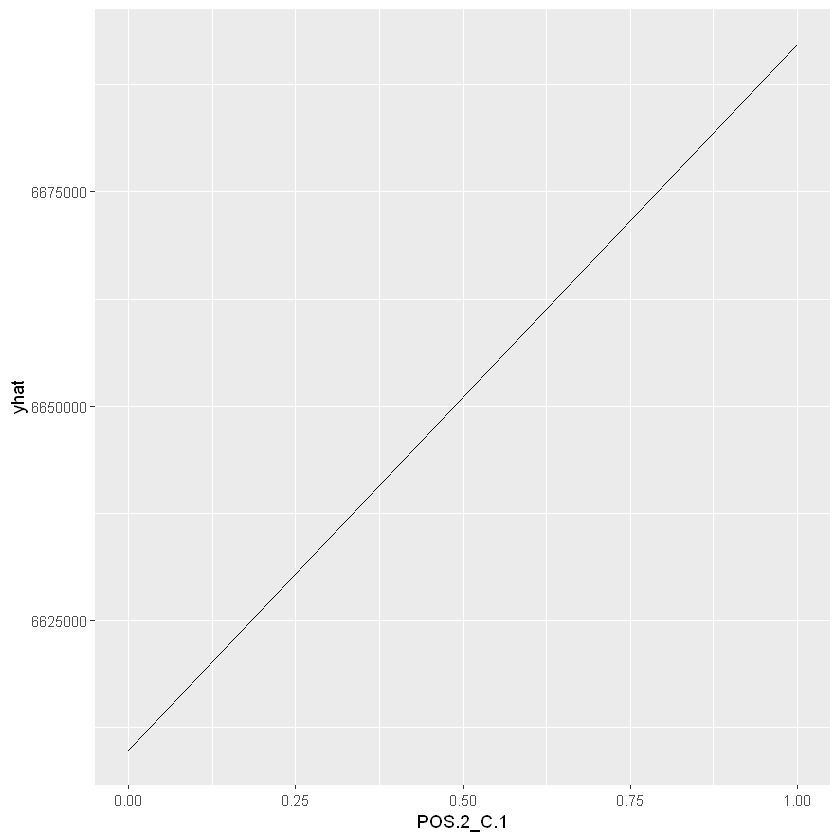

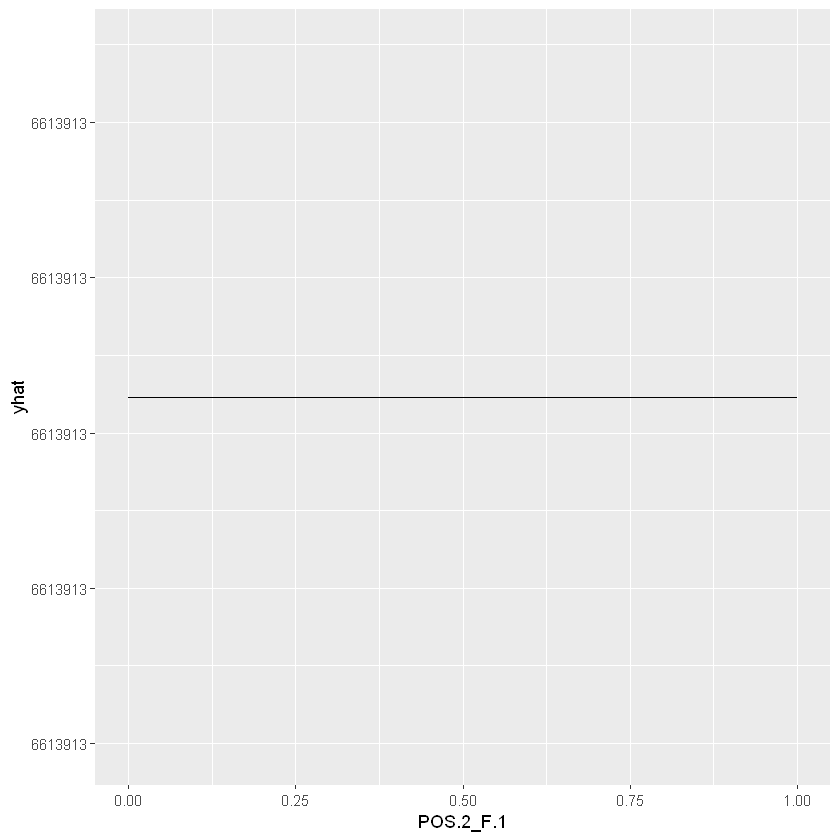

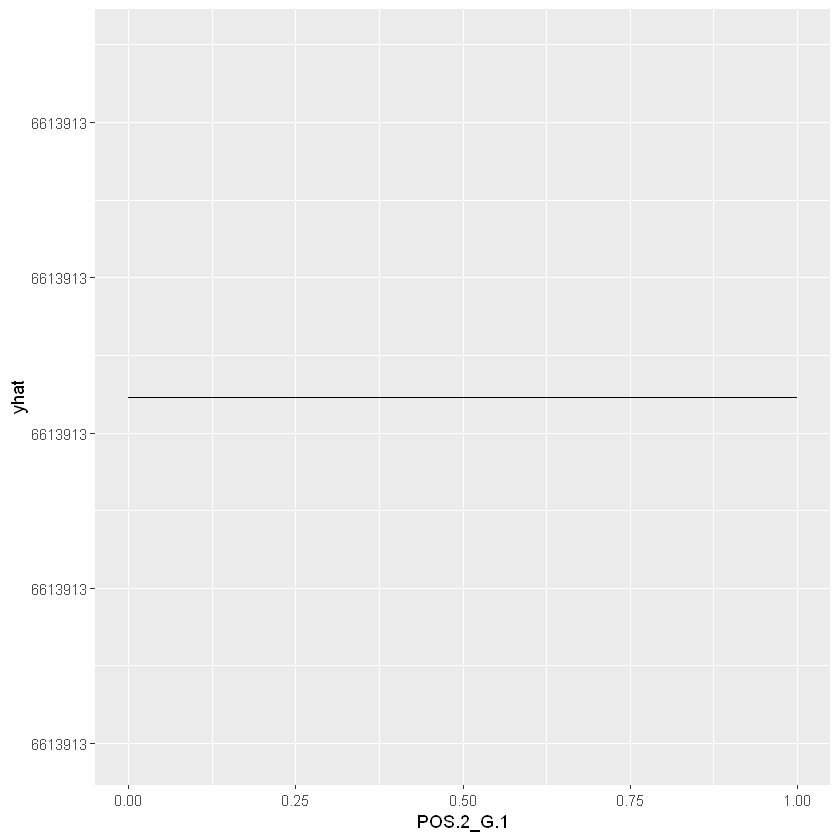

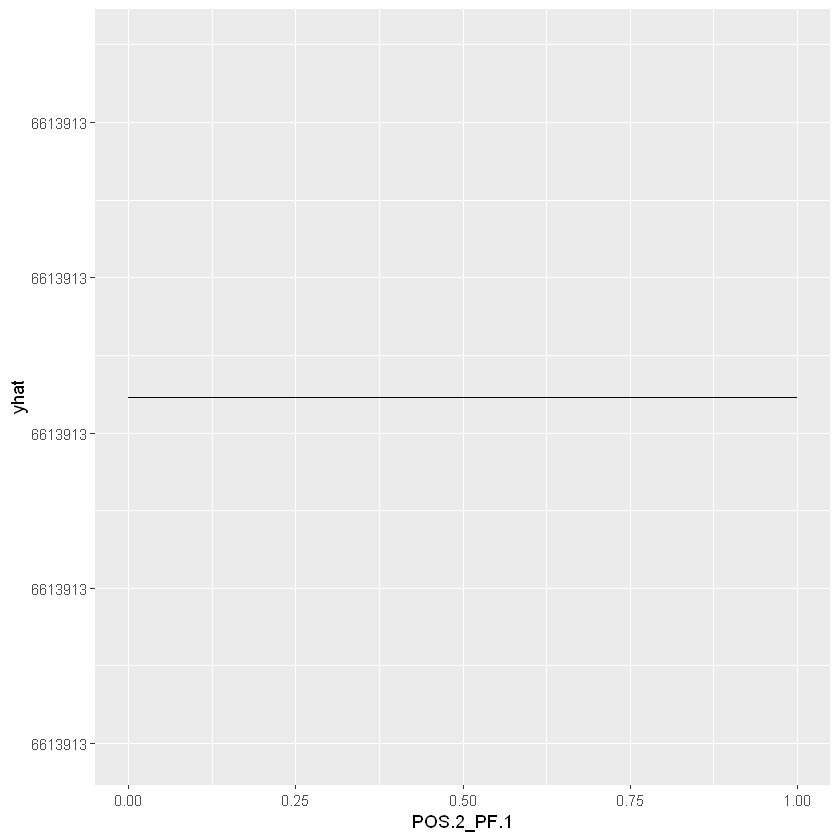

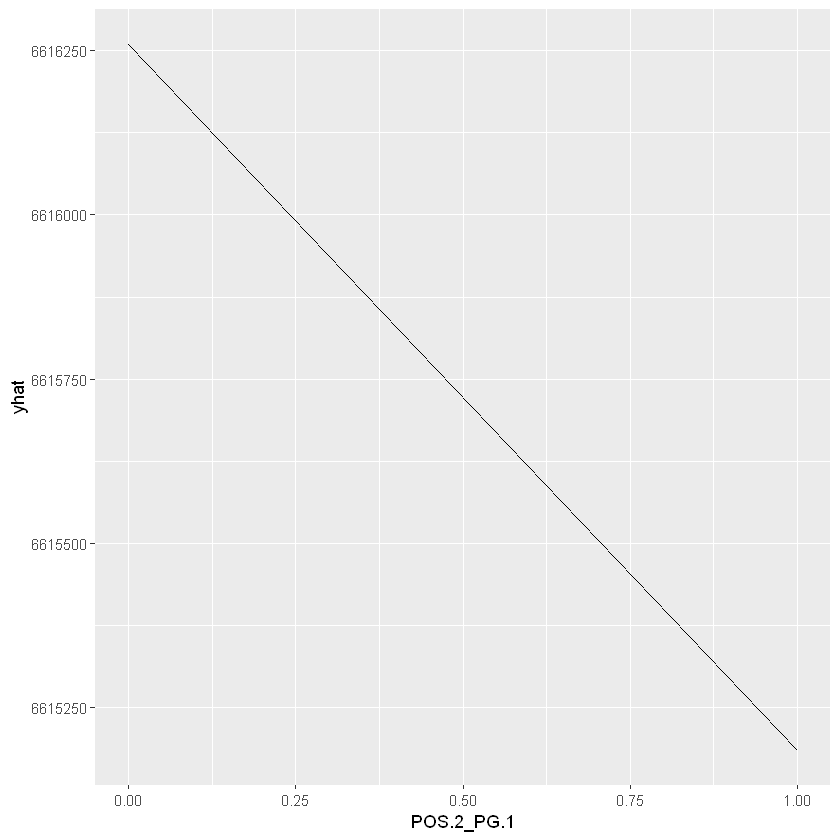

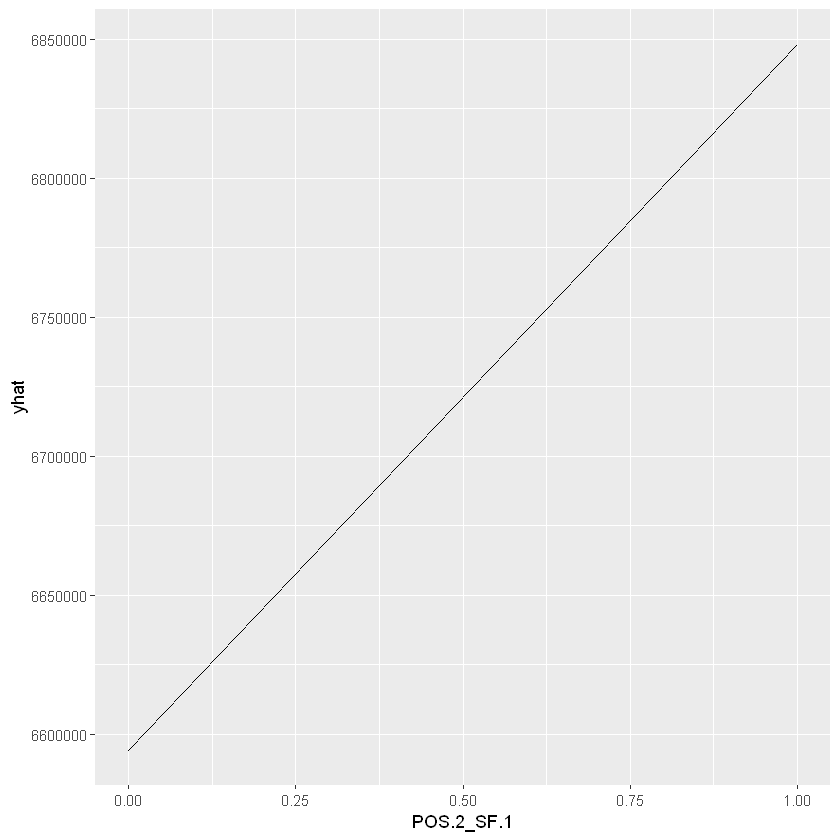

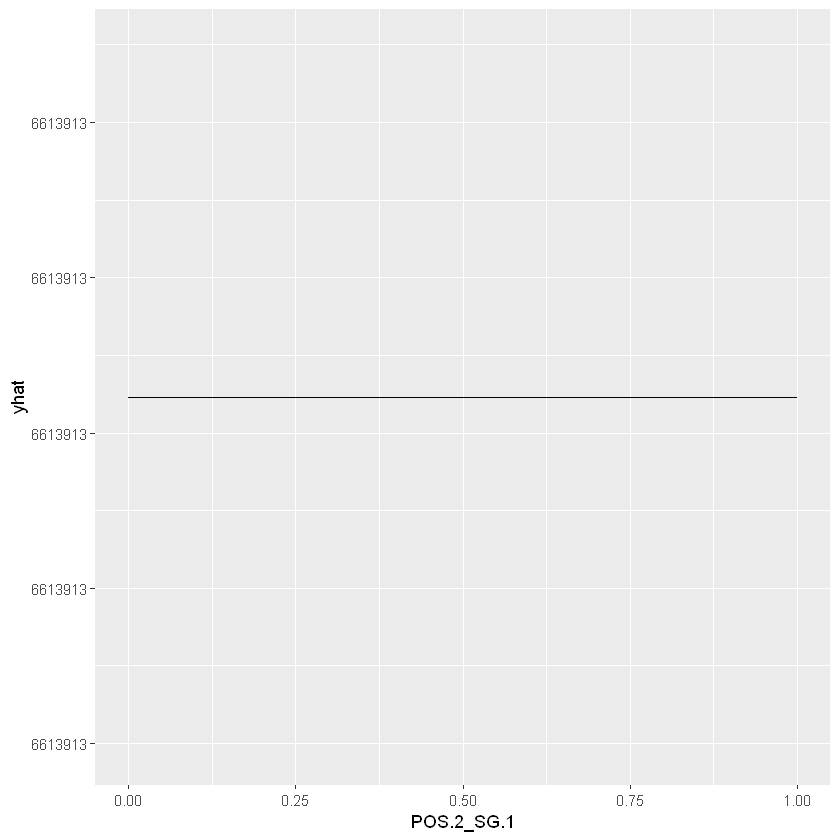

In [595]:
for (col in names(train_x)) {
    pdep = partial(model, train=train_x, pred.var = c(col), chull = TRUE)
    print(autoplot(pdep, contour = TRUE))
}